In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm import tqdm
import ephem

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
# Compute beta0
g  = 9.81  # m s-2
qb = 0.02  # kg/kg
L  = 2.5e6 # J/kg
Cp = 1e3   # J/kg/K
# dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.sst_pmd / (g * qb * L)
dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.temp_pmd / (g * qb * L)
dsg['beta0_T0'] = (dsg.uc ** 2) * Cp / (g * qb * L)

# # Rel SST
# dsg['rel_sst'] = dsg.sst_pmd - dsg.trop_sst_rms

# Group by basin
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016

for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0]

100%|████████████████████████████████████████| 816/816 [00:03<00:00, 228.97it/s]


In [4]:
cond = (dsg.center_quality_flag < 2) & (dsg.percent_outside < 50) & (abs(dsg.lat) < 30) & (dsg.rmx < 100000) & (dsg.vmx > 33) & (~np.isnan(dsg.sst_pmd)) & (~np.isnan(dsg.r34))
d    = dsg.where(cond, drop=True)

Text(0, 0.5, 'beta0 SAR')

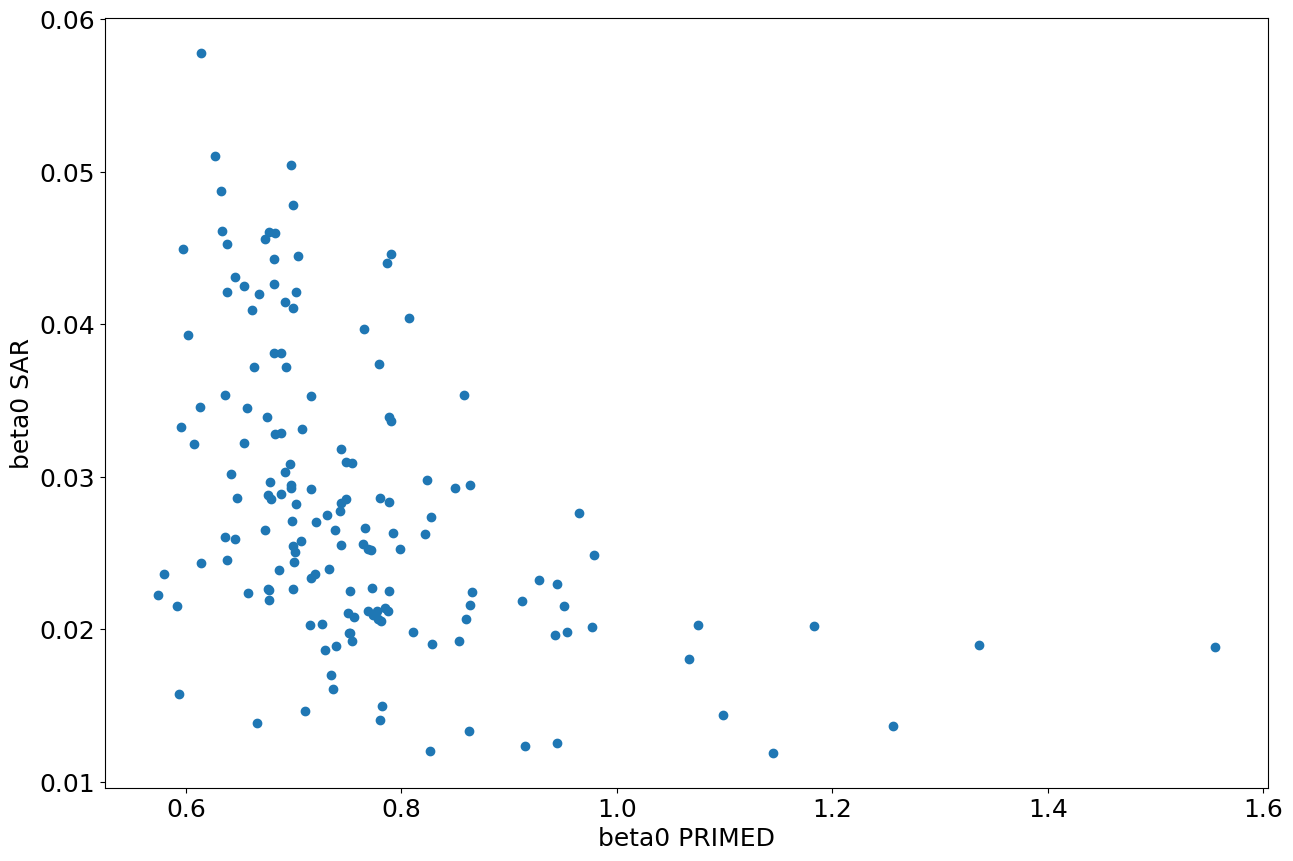

In [5]:
plt.scatter(d.beta0_pmd / 20000, d.beta0 / 20000)
plt.xlabel('beta0 PRIMED')
plt.ylabel('beta0 SAR')
# plt.xlim(0, 1)

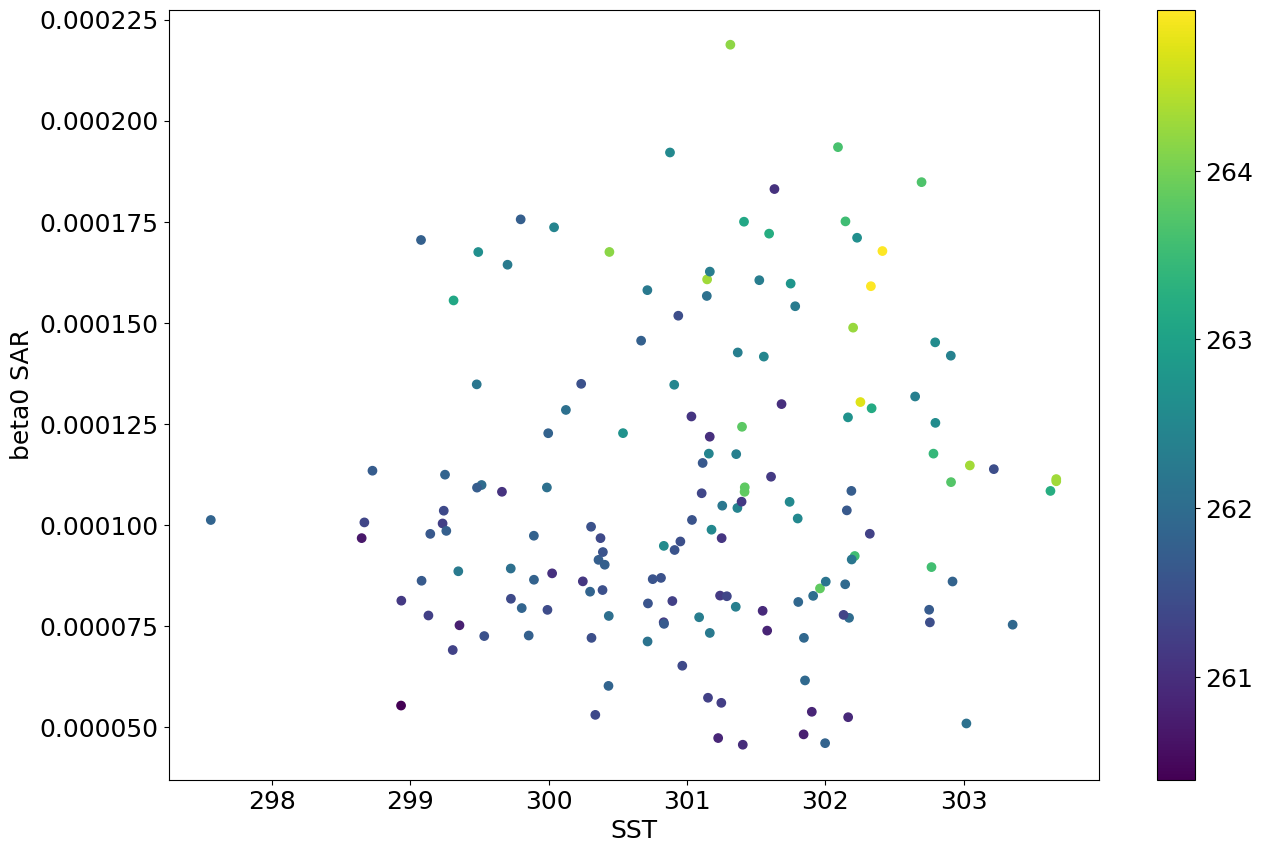

In [6]:
plt.scatter(d.sst_pmd, d.beta0_T0 / 20000, c=d.temp_pmd)
plt.xlabel('SST')
plt.ylabel('beta0 SAR')
plt.colorbar()
# plt.xlim(0, 1)

In [7]:
# plt.scatter(d.beta0_T0_pmd / 20000, d.beta0_T0 / 20000)
# plt.xlabel('beta0 / T0 PRIMED')
# plt.ylabel('beta0 / T0 SAR')
# # plt.xlim(0, 0.005)

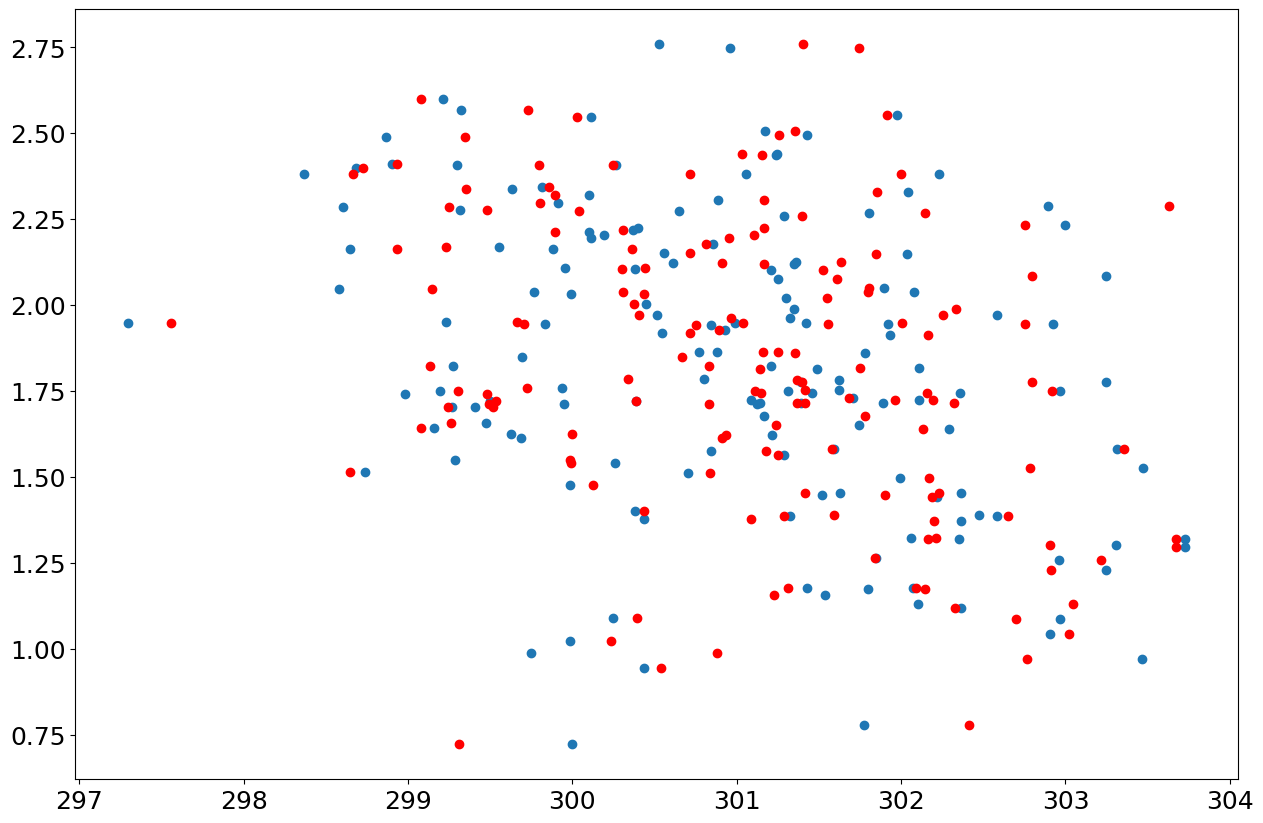

In [8]:
plt.scatter(d.sst_rms, d.B_hol)
plt.scatter(d.sst_pmd, d.B_hol, c='r')

(array([13., 25., 36., 31., 16.,  9., 12., 10.,  3.,  1.]),
 array([0.01588026, 0.02199841, 0.02811657, 0.03423472, 0.04035287,
        0.04647103, 0.05258918, 0.05870733, 0.06482549, 0.07094364,
        0.07706179]),
 <BarContainer object of 10 artists>)

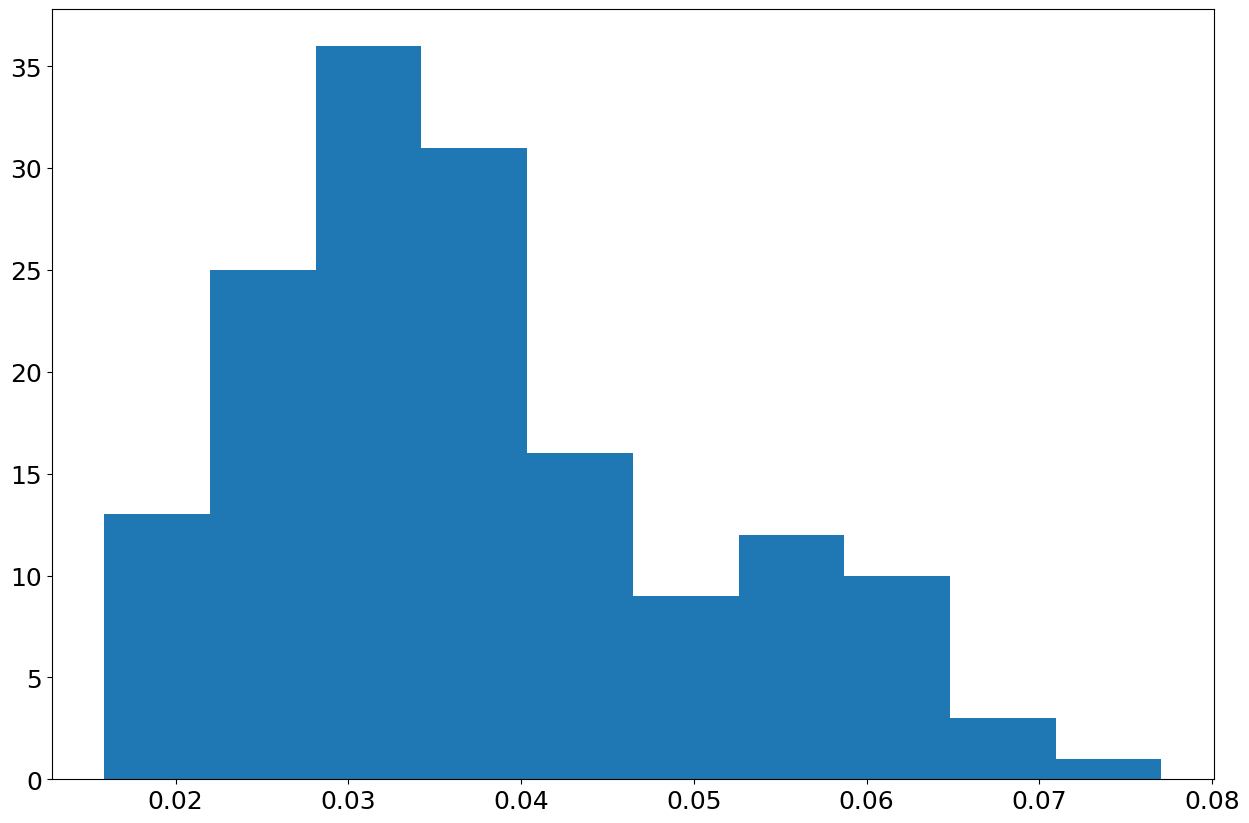

In [9]:
plt.hist(d.beta0 / 15000)

In [10]:
# print(dsg.where(dsg.basin == 'al', drop=True).temp_pmd.mean())
# print(dsg.where(dsg.basin == 'wp', drop=True).temp_pmd.mean())

/tmp/ipykernel_17341/3892731901.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


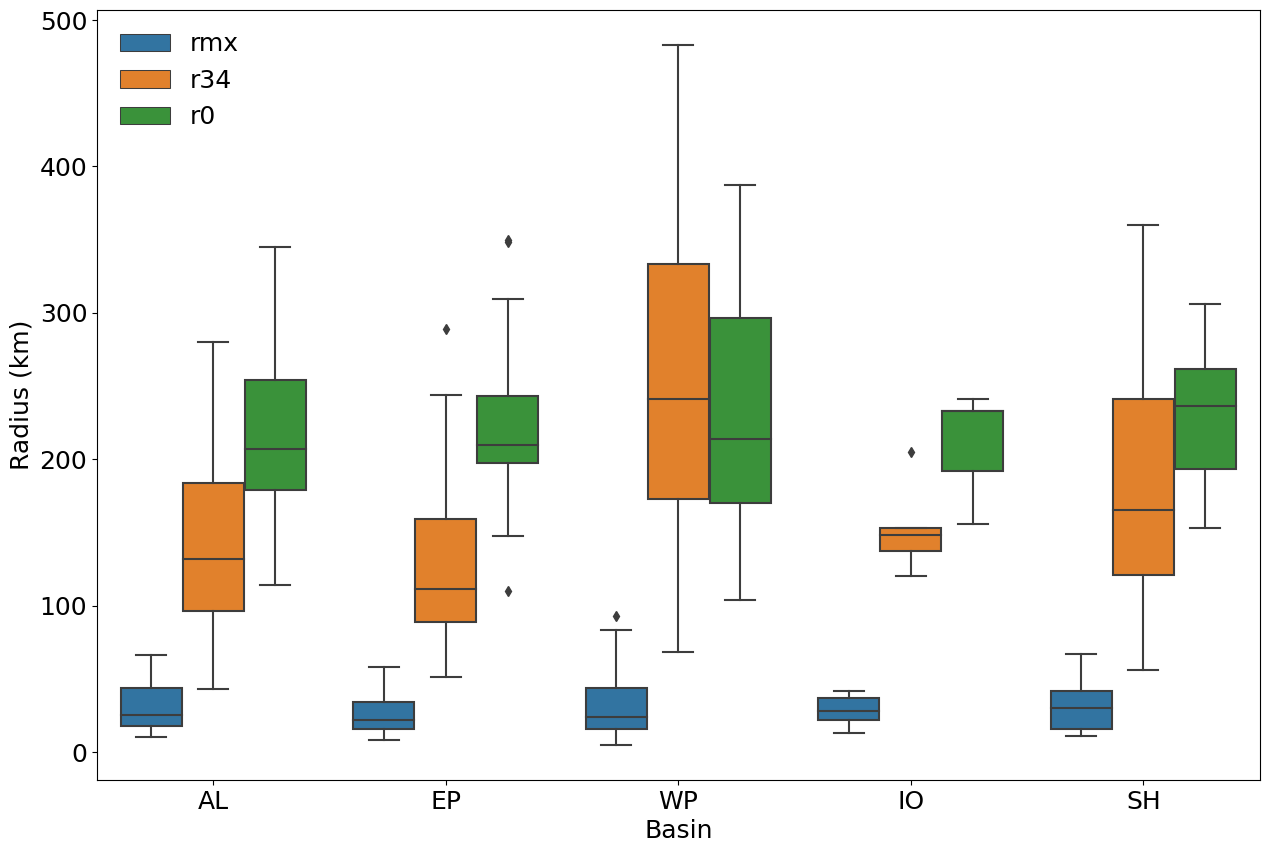

In [11]:
df      = d[['basin_idx', 'rmx', 'r34', 'r0']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rmx', 'r34', 'r0'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks() / 1000]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Radius (km)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

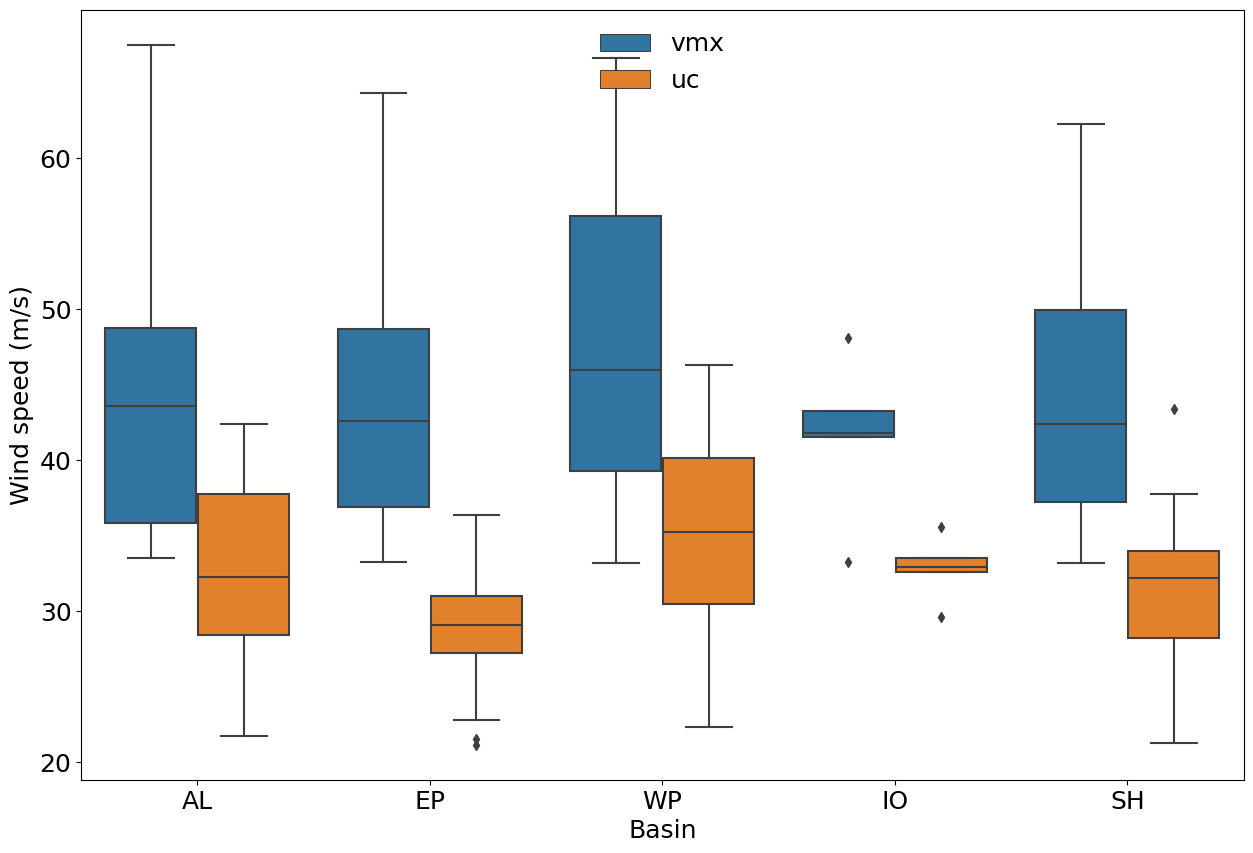

In [12]:
df      = d[['basin_idx', 'vmx', 'uc']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmx', 'uc'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Wind speed (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper center')

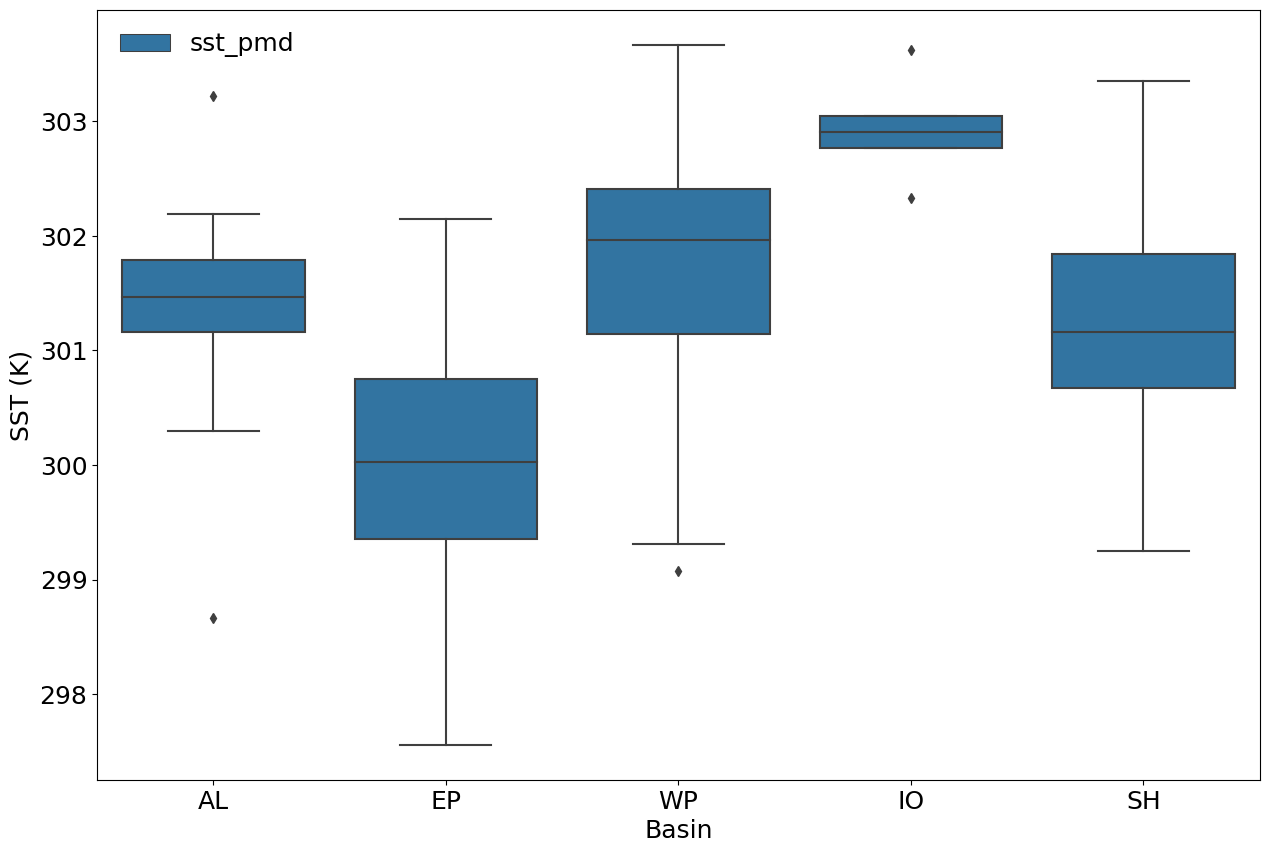

In [13]:
df      = d[['basin_idx', 'sst_pmd']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['sst_pmd'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('SST (K)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

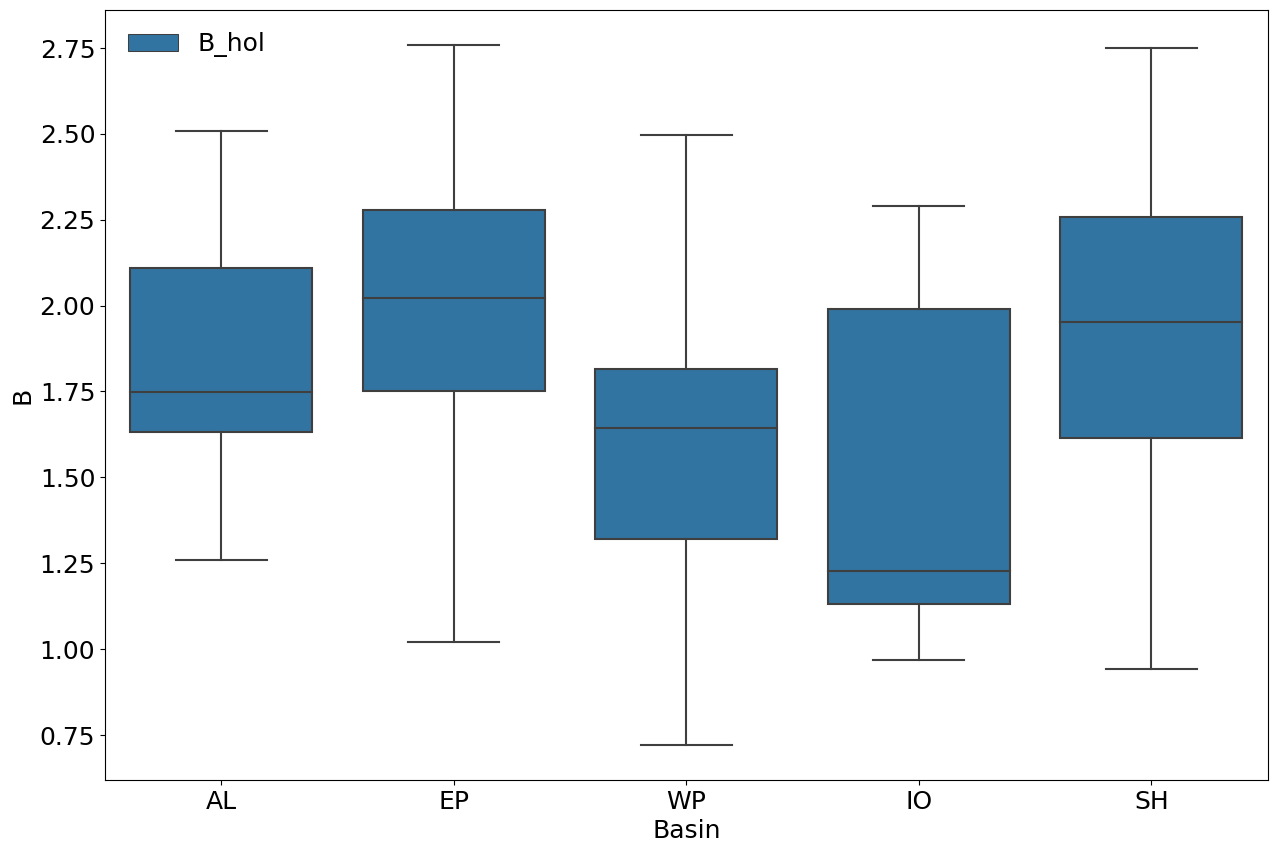

In [14]:
df      = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['B_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('B')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

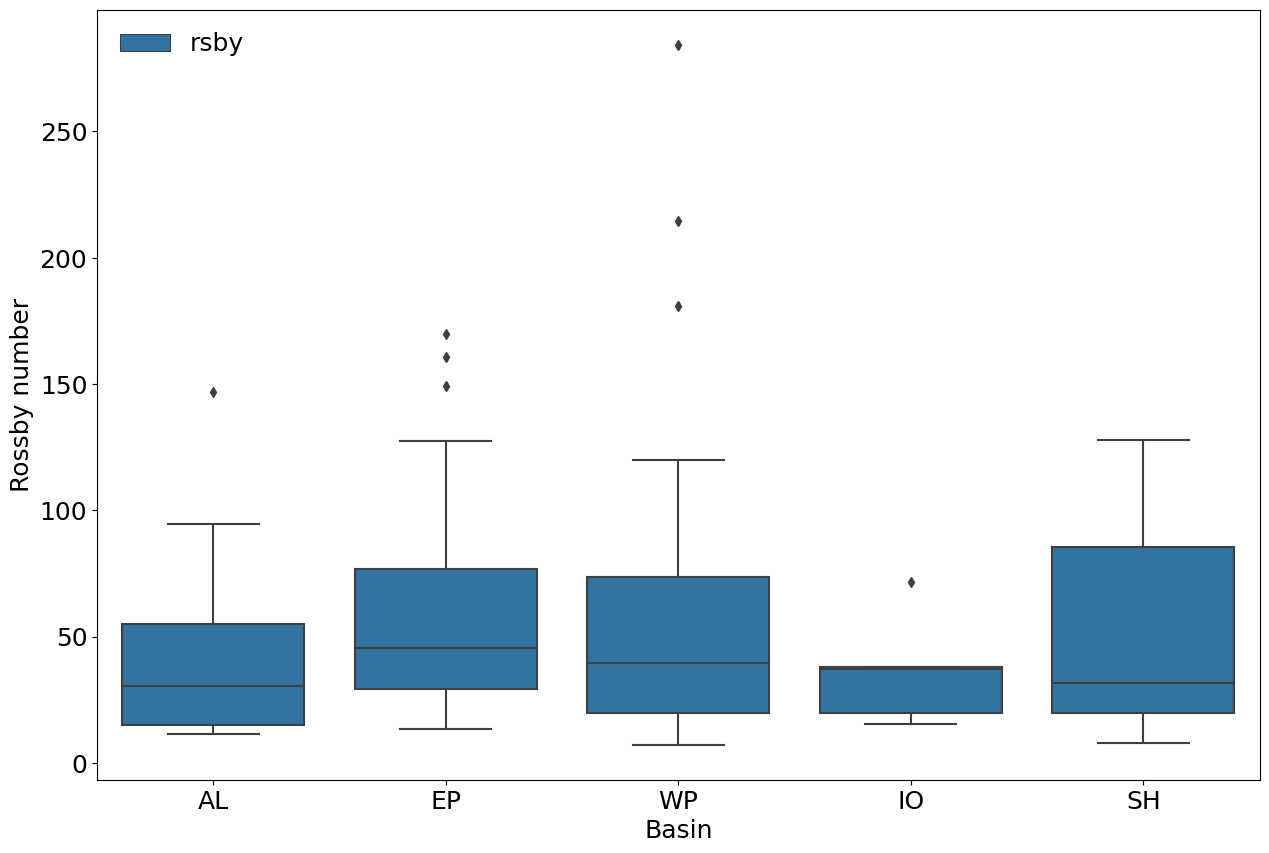

In [15]:
df      = d[['basin_idx', 'rsby']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rsby'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Rossby number')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

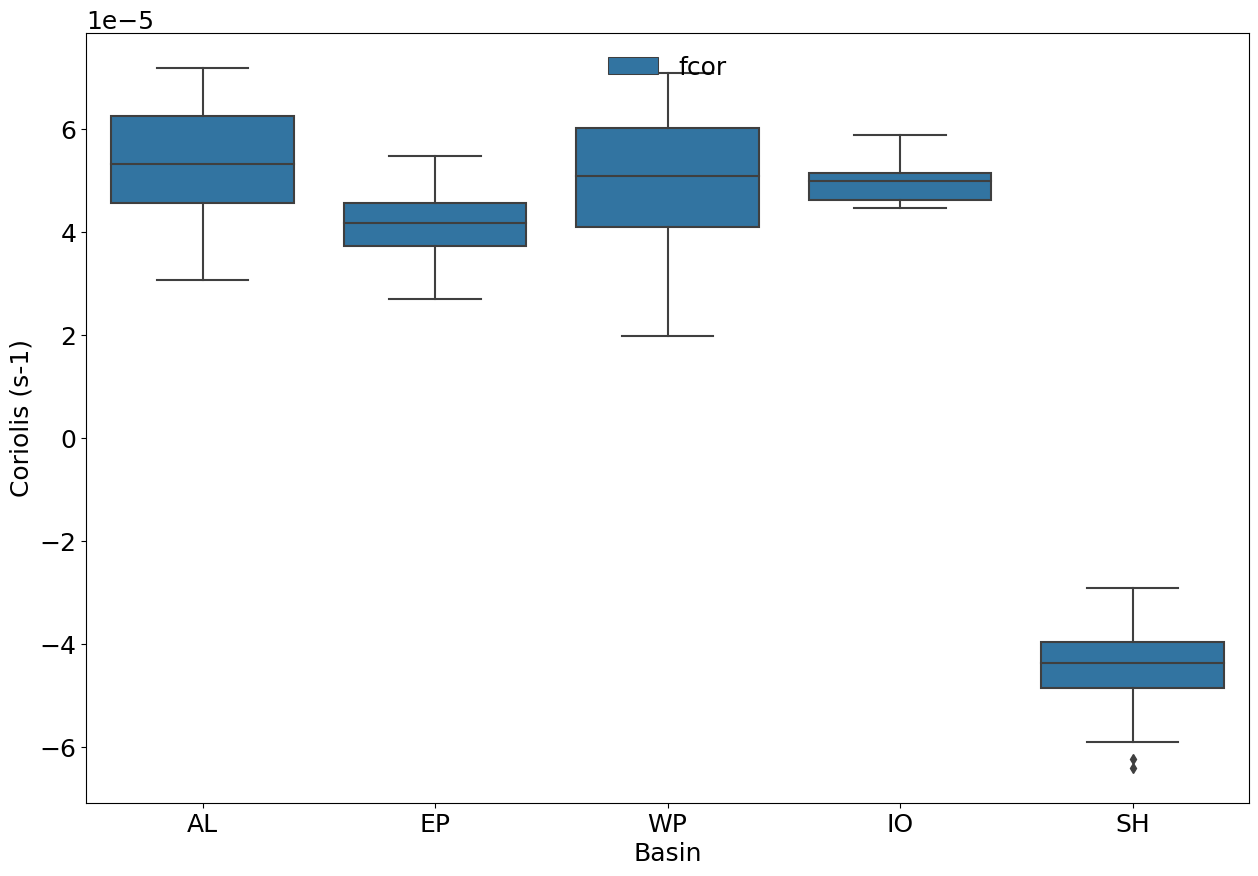

In [16]:
df      = d[['basin_idx', 'fcor']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['fcor'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Coriolis (s-1)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper center')

In [17]:
da = d.where(d.basin == 'al', drop=True)
dc = d.where(d.basin == 'cp', drop=True)
de = d.where(d.basin == 'ep', drop=True)
di = d.where(d.basin == 'io', drop=True)
ds = d.where(d.basin == 'sh', drop=True)
dw = d.where(d.basin == 'wp', drop=True)

In [18]:
di.speed

<xarray.DataArray 'speed' (time: 5)>
array([4.29271663, 1.95654404, 1.29419905, 3.99373355, 4.1794836 ])
Coordinates:
  * time     (time) datetime64[ns] 2019-06-12T01:18:27 ... 2021-10-02T01:54:50
Attributes:
    long_name:    Estimated cyclone propagation speed
    description:  Taken from Ifremer TCVA product
    units:        m/s

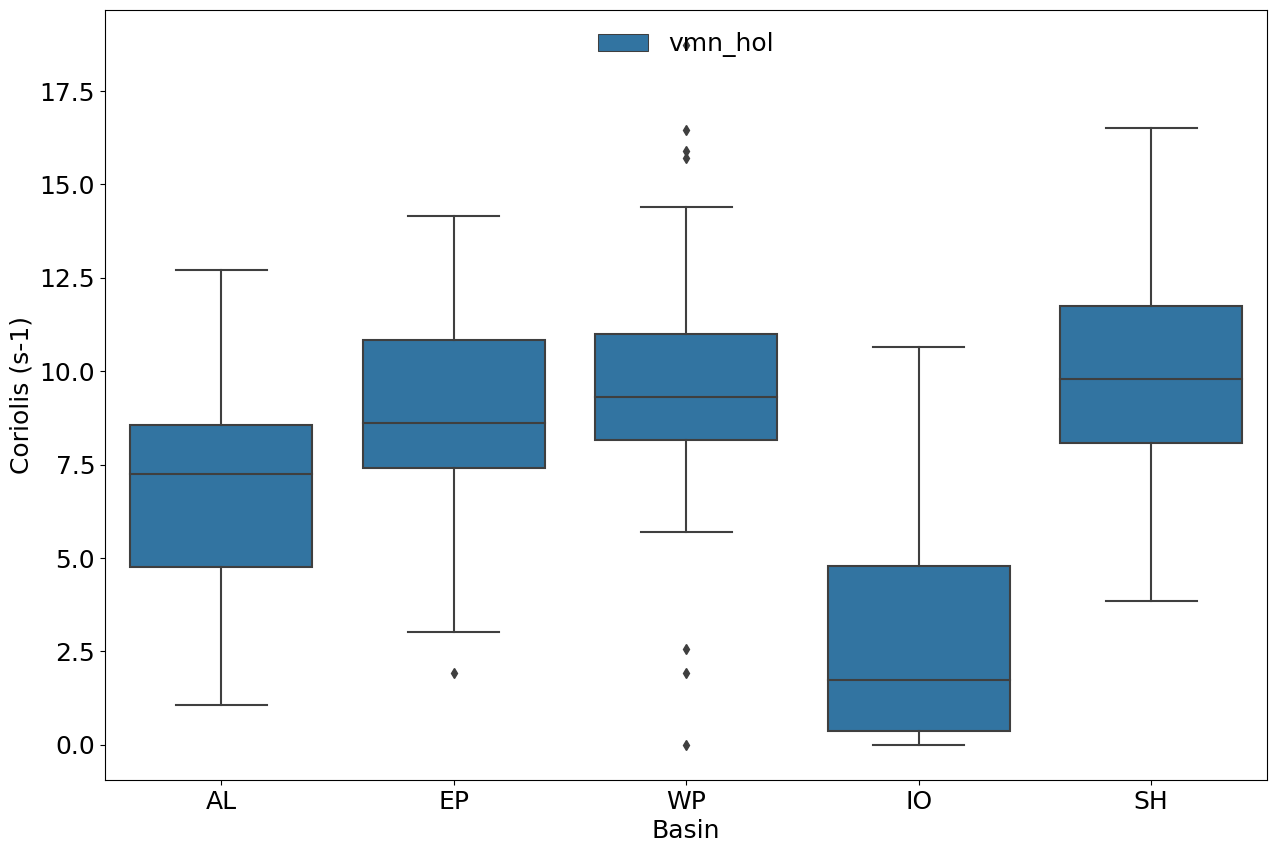

In [19]:
df      = d[['basin_idx', 'vmn_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmn_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Coriolis (s-1)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper center')

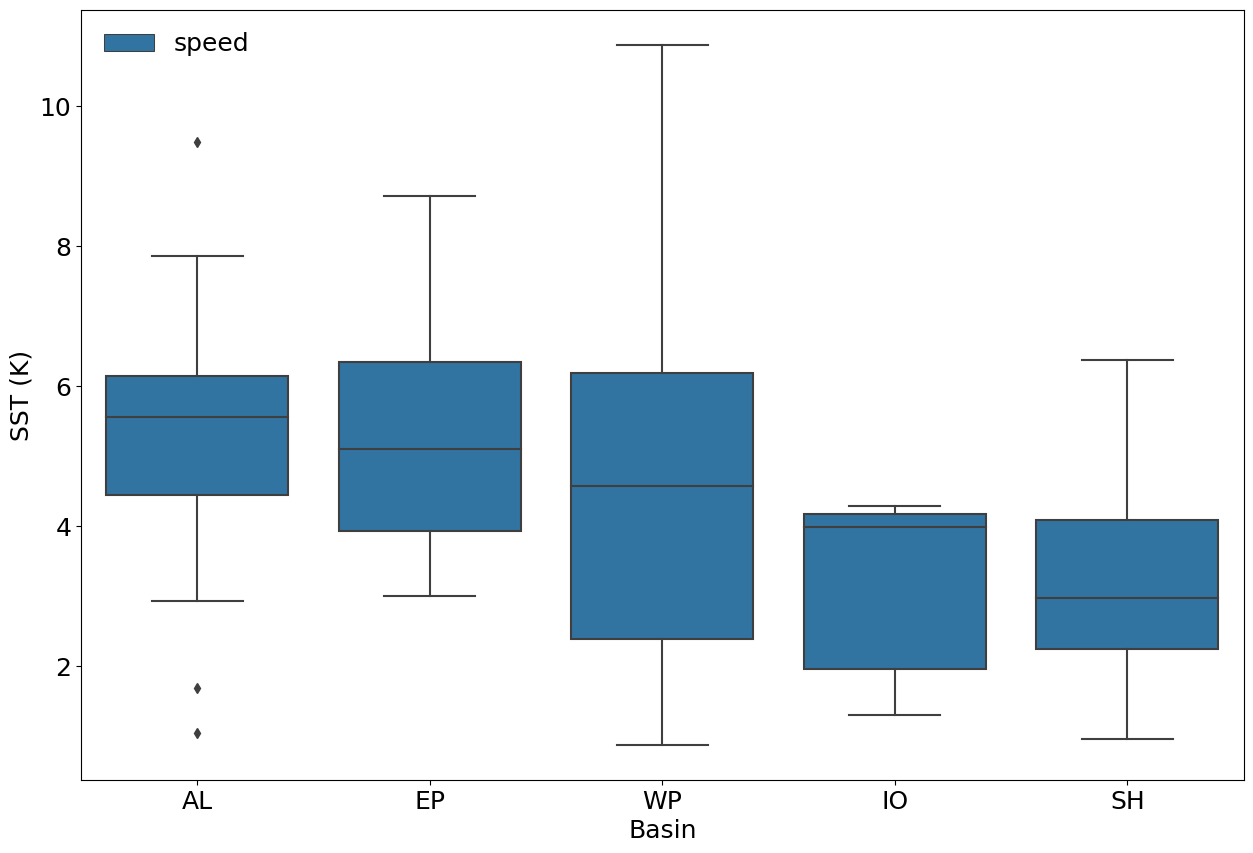

In [20]:
df      = d[['basin_idx', 'speed']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['speed'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('SST (K)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

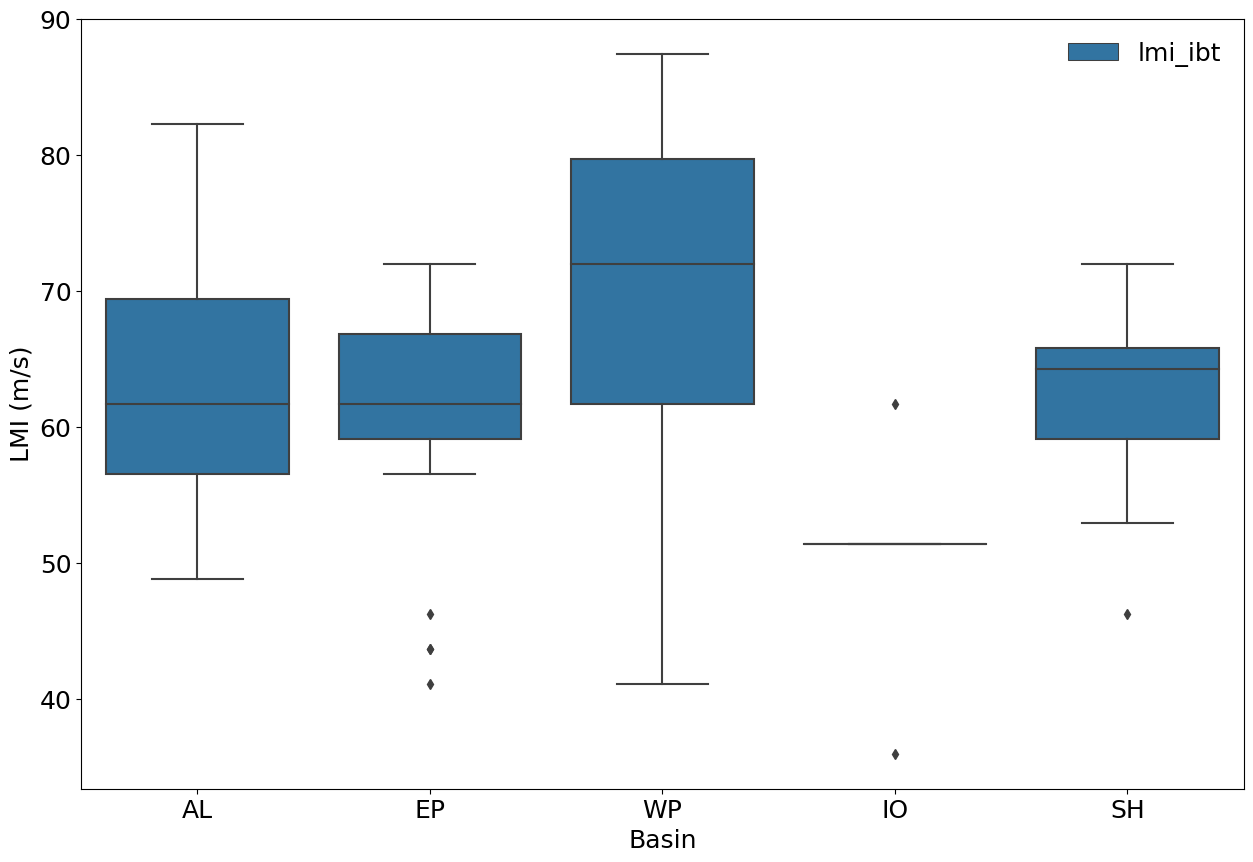

In [21]:
df      = d[['basin_idx', 'lmi_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['lmi_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('LMI (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

/tmp/ipykernel_17341/2202944619.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


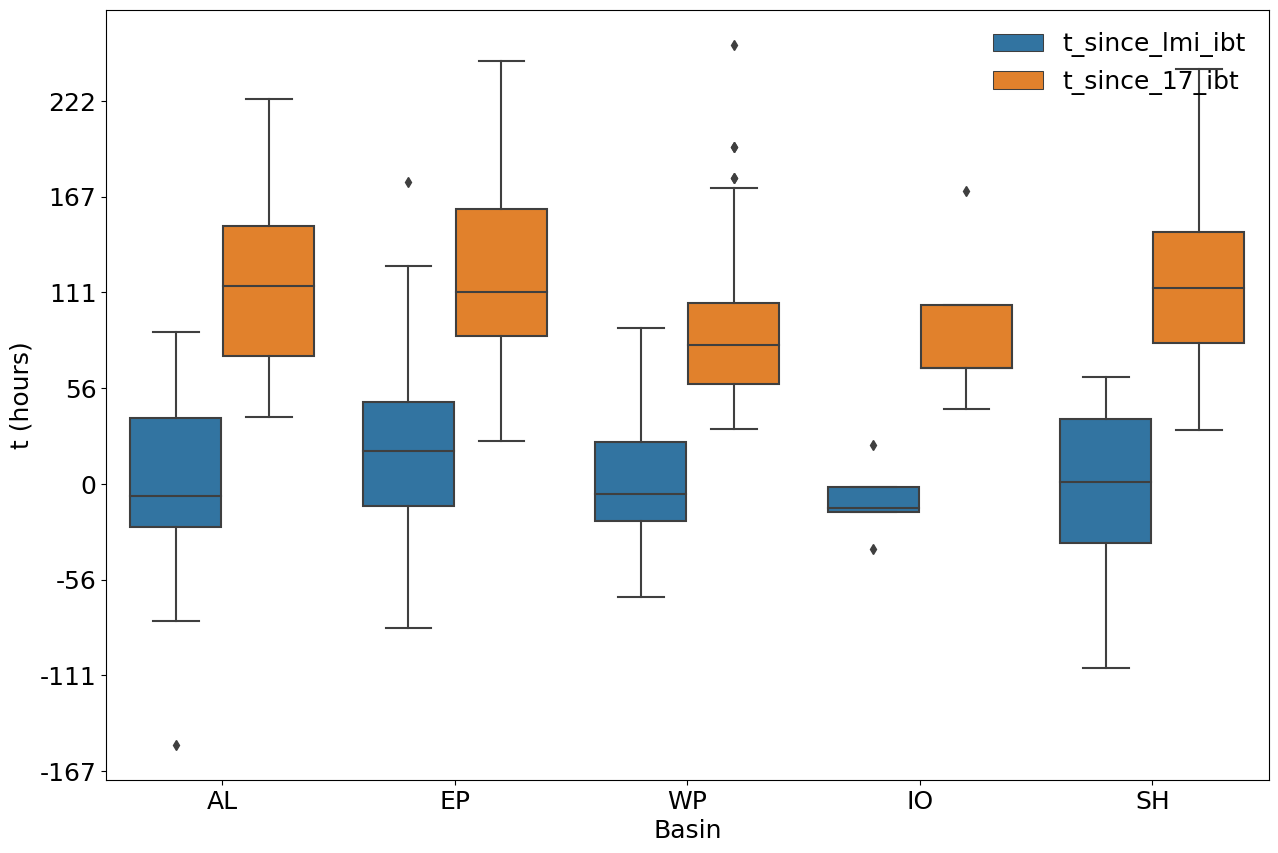

In [22]:
df      = d[['basin_idx', 't_since_lmi_ibt', 't_since_17_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['t_since_lmi_ibt', 't_since_17_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y / 3600) for y in g.get_yticks()]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('t (hours)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

In [23]:
a = d.where(d.t_since_lmi_ibt < 0, drop=True)

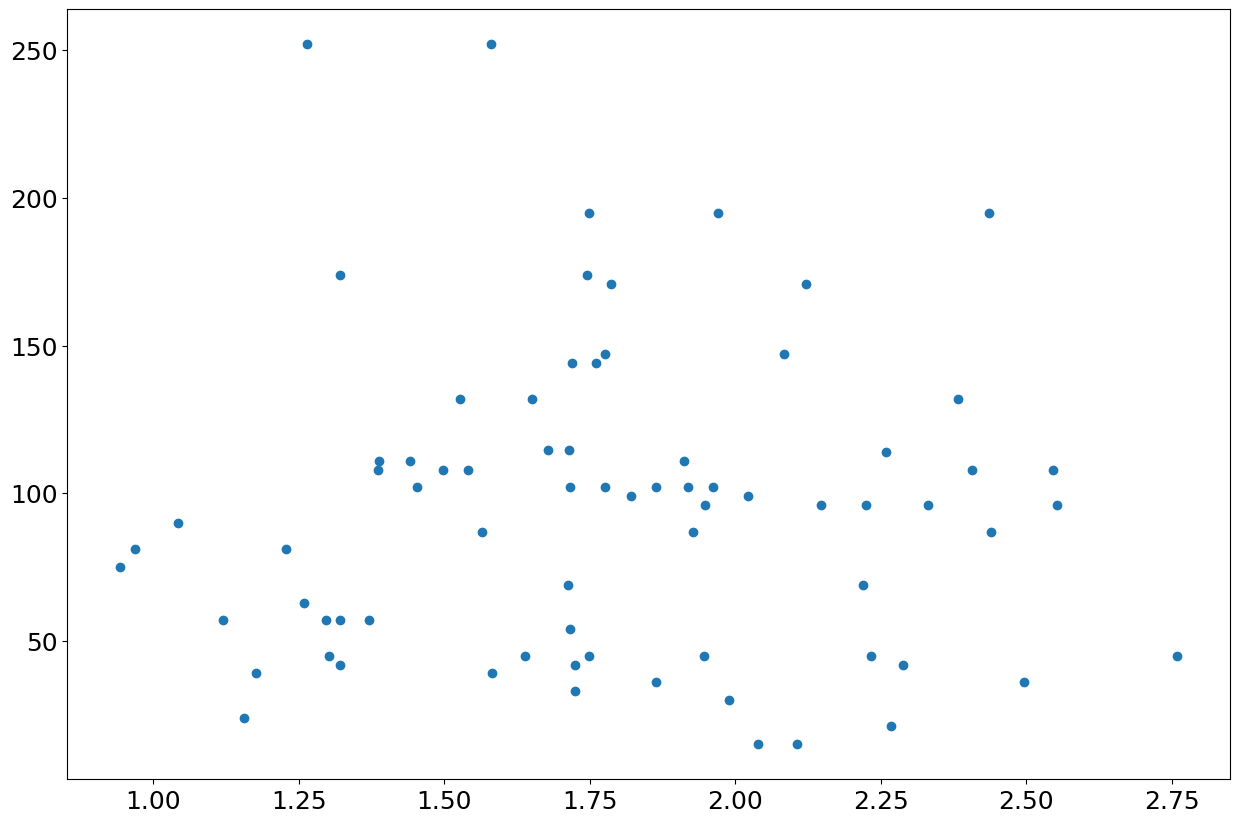

In [24]:
plt.scatter(a.B_hol, (a.t_17_end_ibt - a.t_lmi_ibt) / (3600 * np.timedelta64(1, 's')))

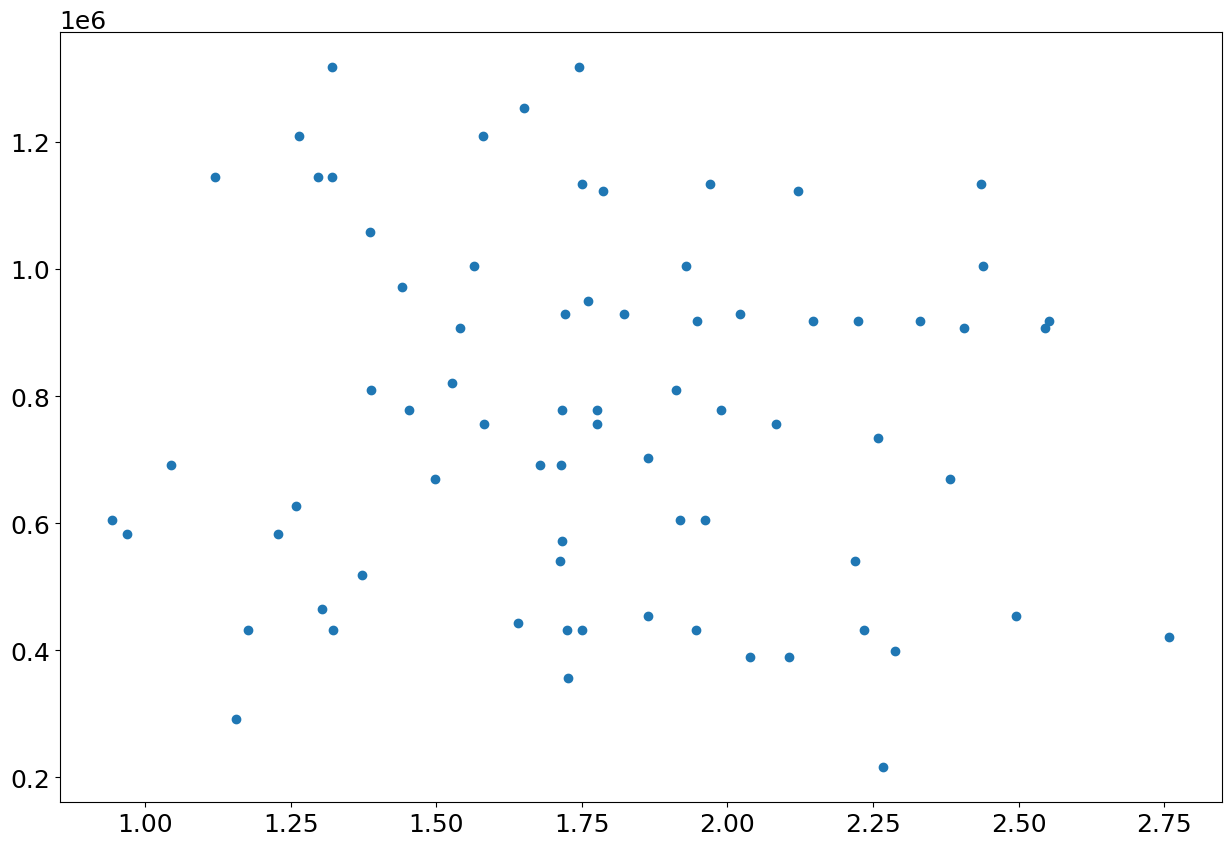

In [25]:
plt.scatter(a.B_hol, a.dt_17_ibt)

In [26]:
a = d.where((d.vmx >= 40) & (d.vmx <= 50), drop=True)
b = a.where((a.rsby >= 50) & (a.rsby <= 70), drop=True)

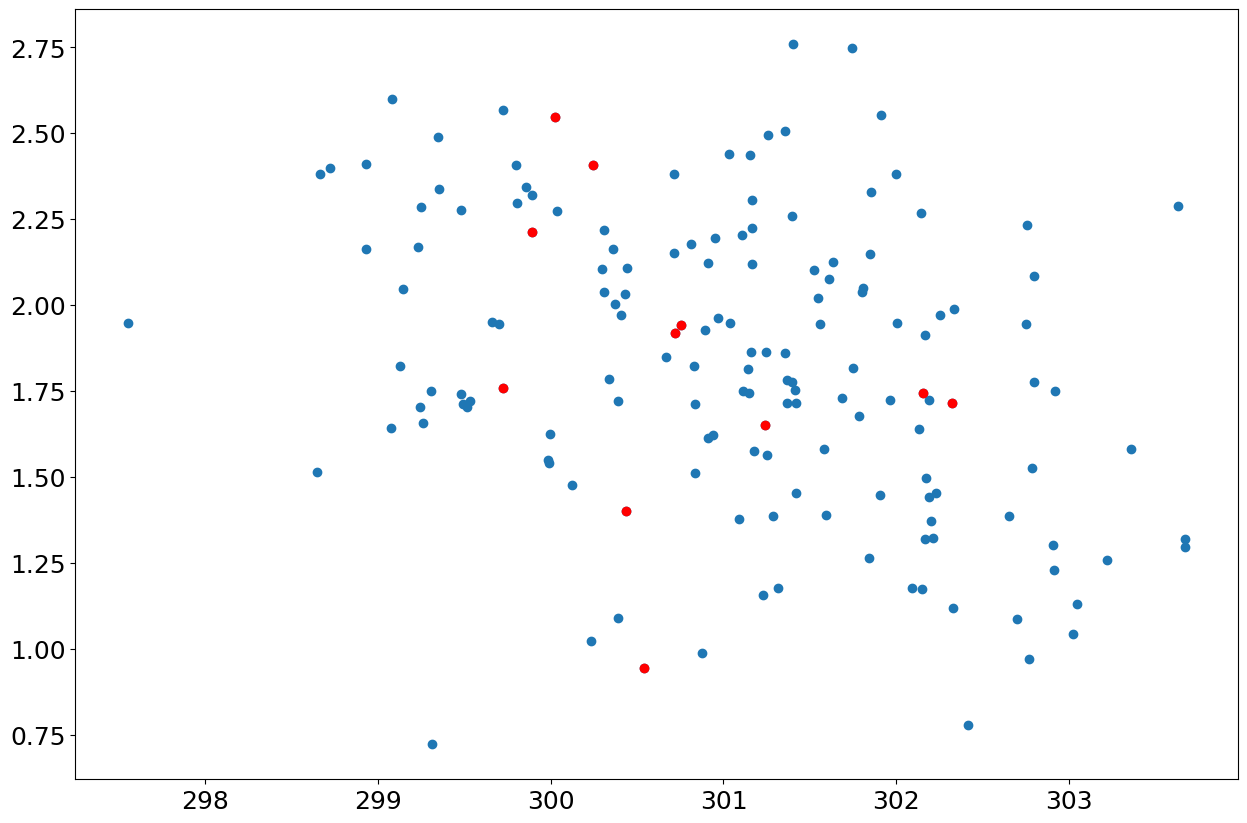

In [27]:
plt.scatter(d.sst_pmd, d.B_hol)
plt.scatter(b.sst_pmd, b.B_hol, c='r')

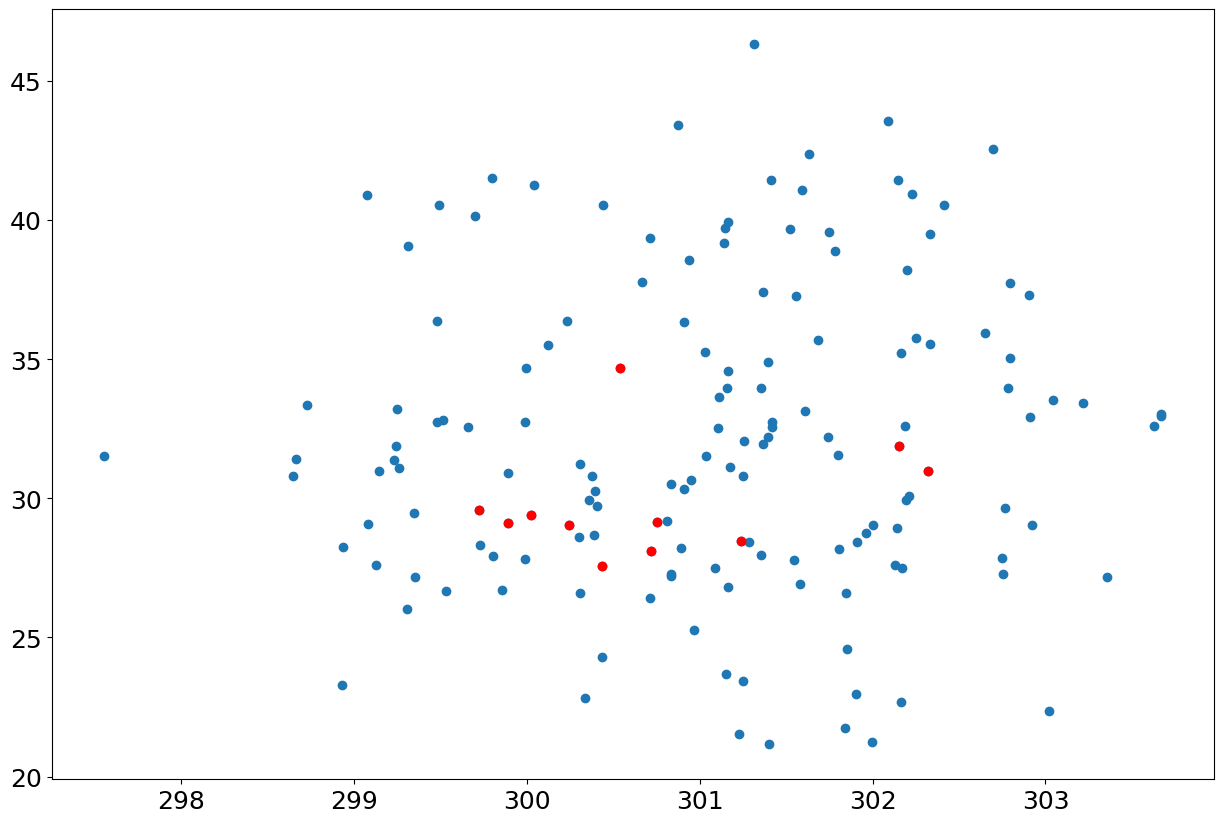

In [28]:
plt.scatter(d.sst_pmd, d.uc)
plt.scatter(b.sst_pmd, b.uc, c='r')

(array([13., 25., 36., 31., 16.,  9., 12., 10.,  3.,  1.]),
 array([0.02382039, 0.03299762, 0.04217485, 0.05135208, 0.06052931,
        0.06970654, 0.07888377, 0.088061  , 0.09723823, 0.10641546,
        0.11559269]),
 <BarContainer object of 10 artists>)

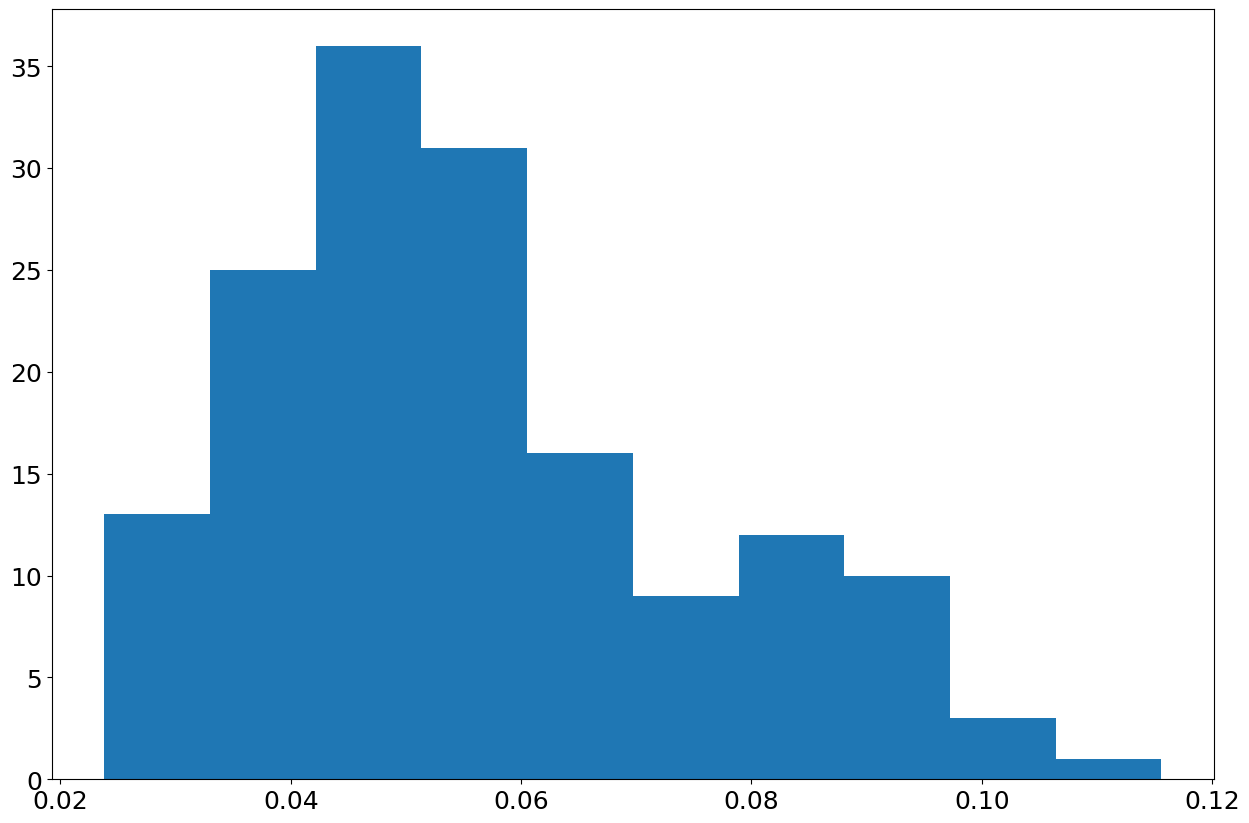

In [29]:
plt.hist(d.beta0 / 10000)

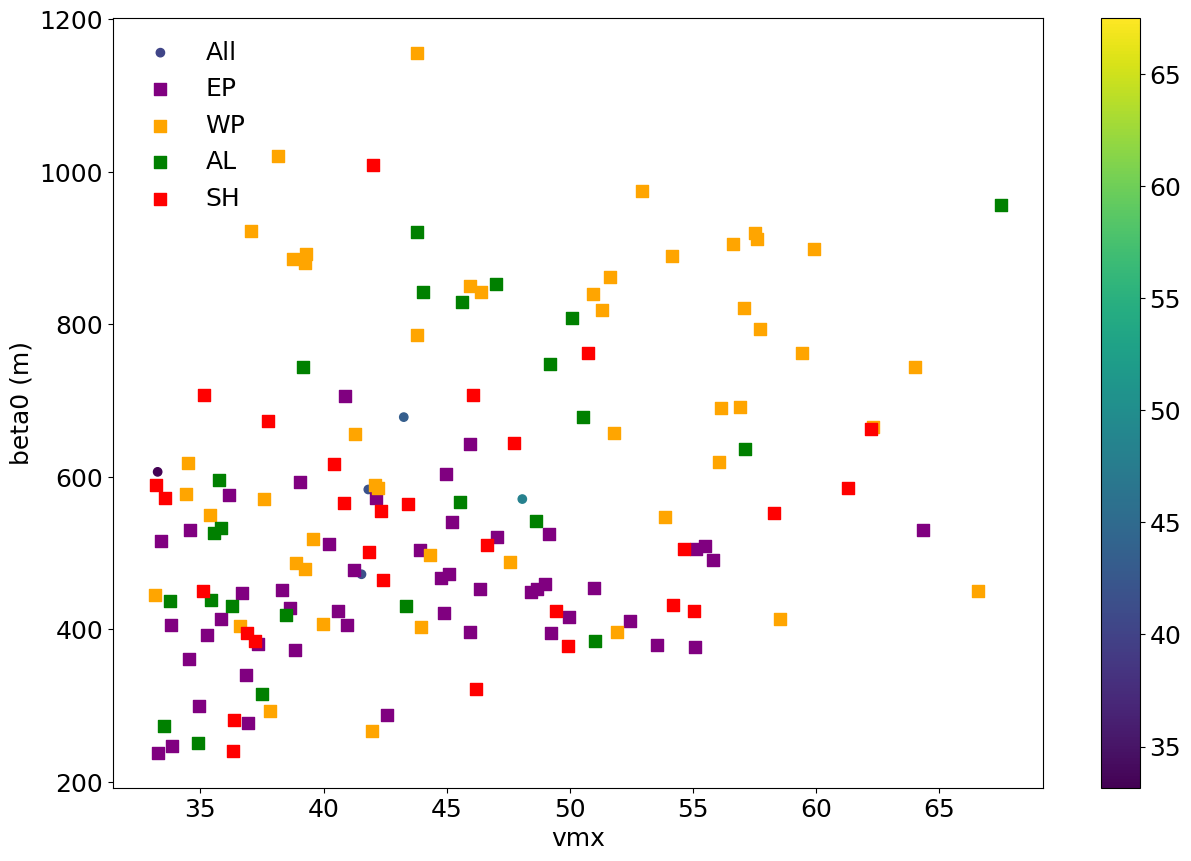

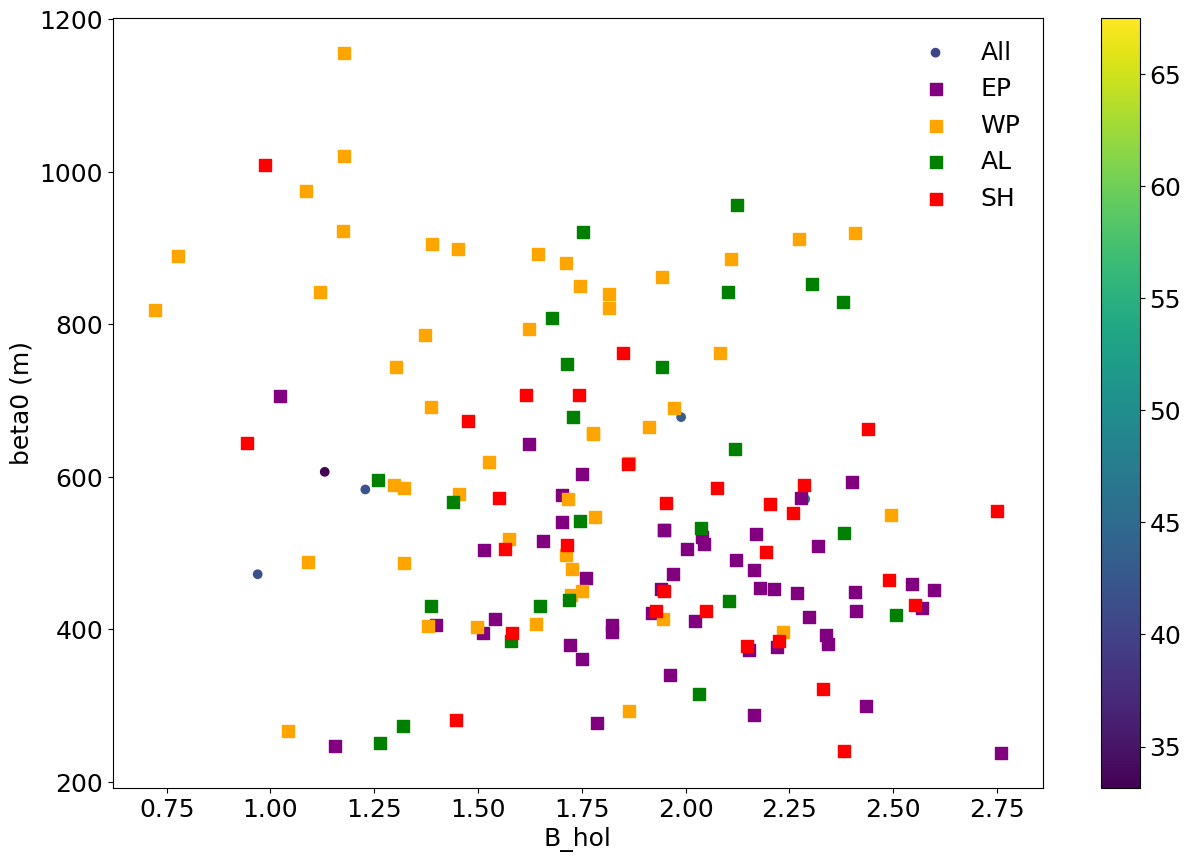

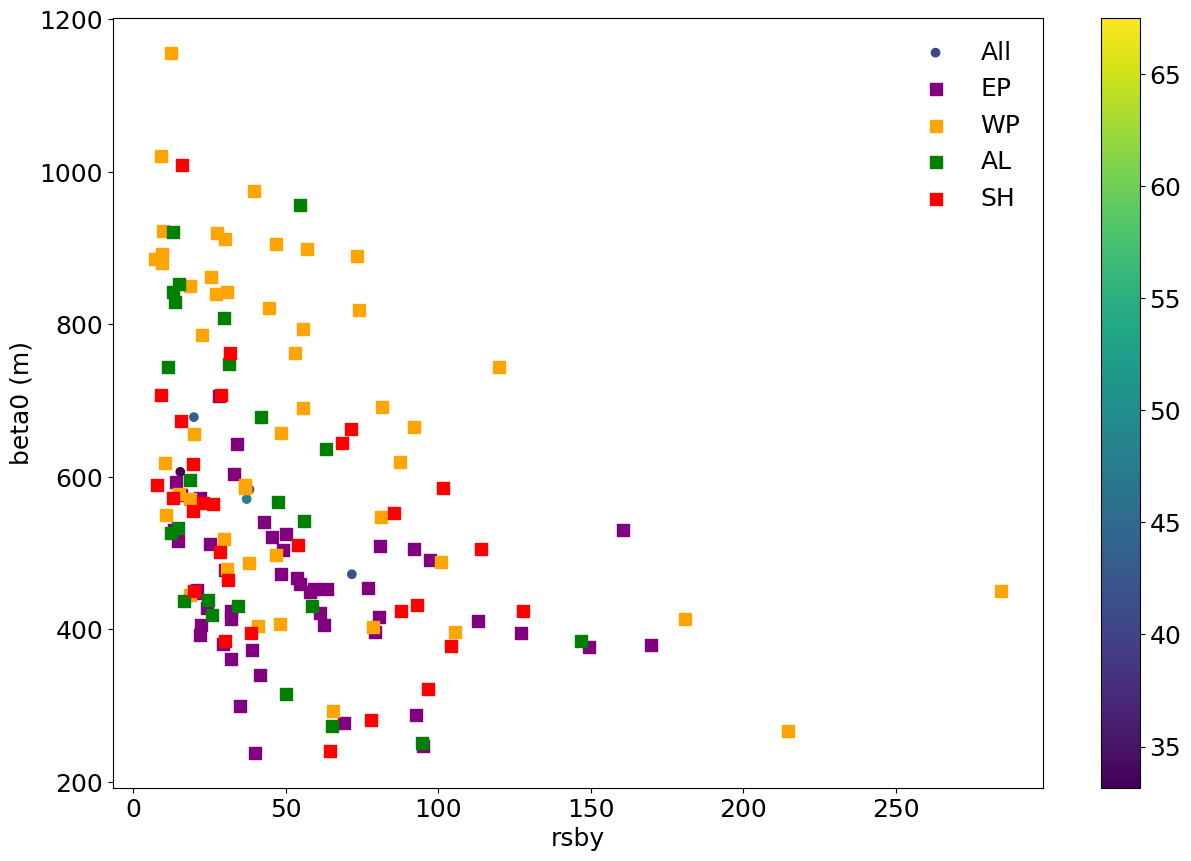

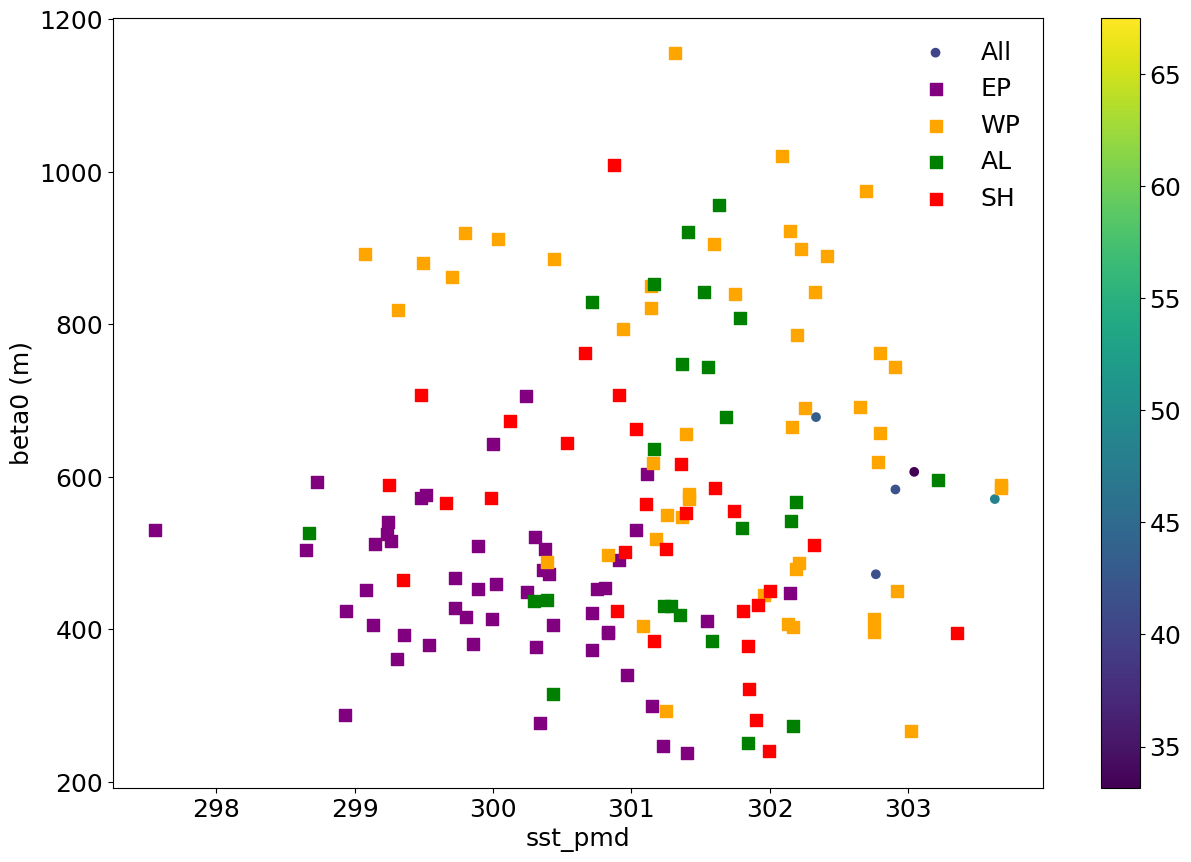

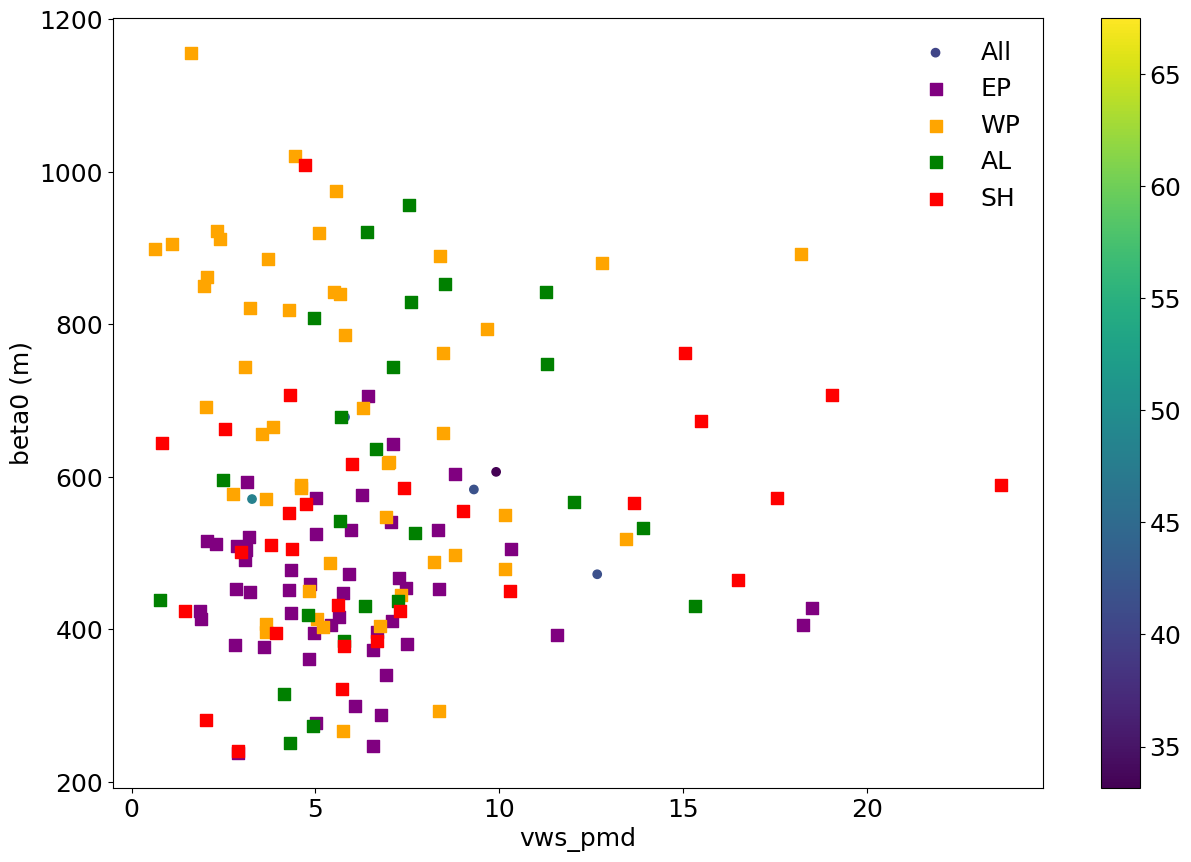

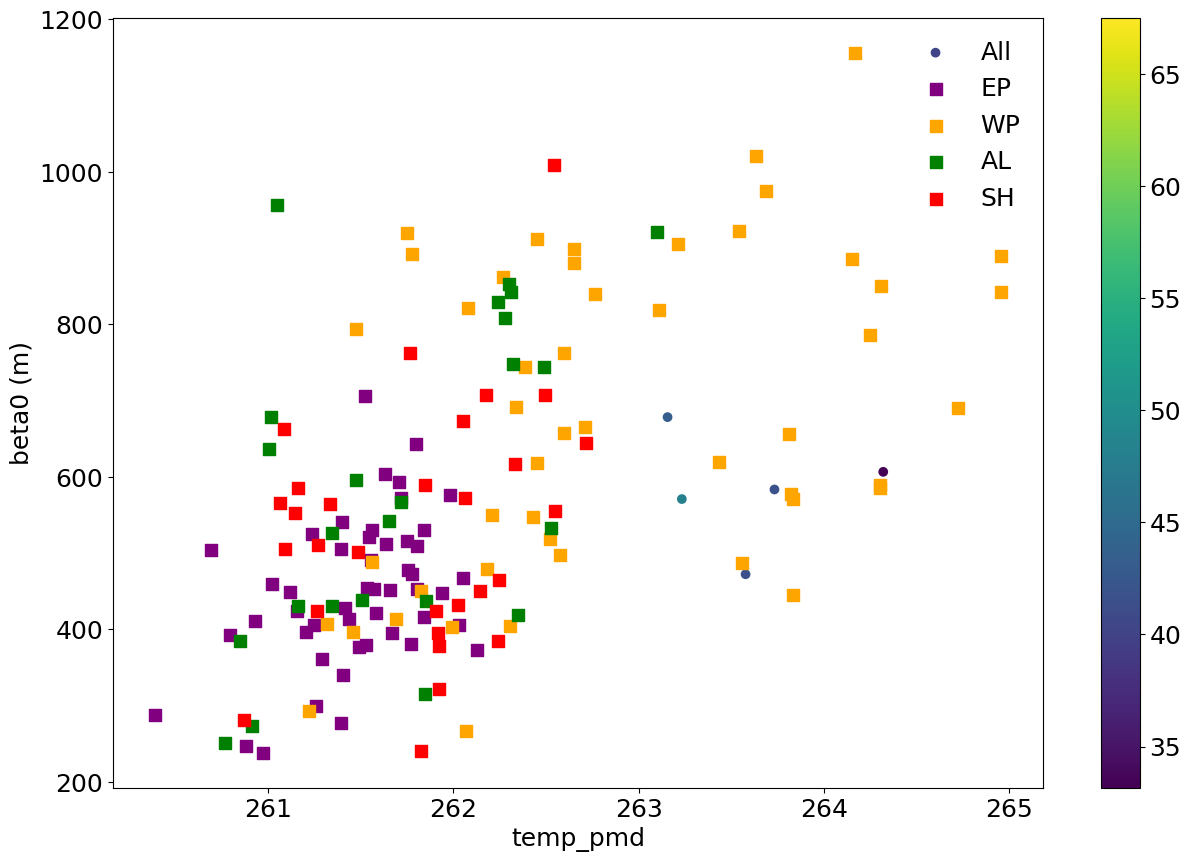

In [31]:
for prm in ['vmx', 'B_hol', 'rsby', 'sst_pmd', 'vws_pmd', 'temp_pmd']:
    plt.scatter(d[prm],  d.beta0,  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de.beta0, c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw.beta0, c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da.beta0, c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds.beta0, c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('beta0 (m)')
    plt.show()

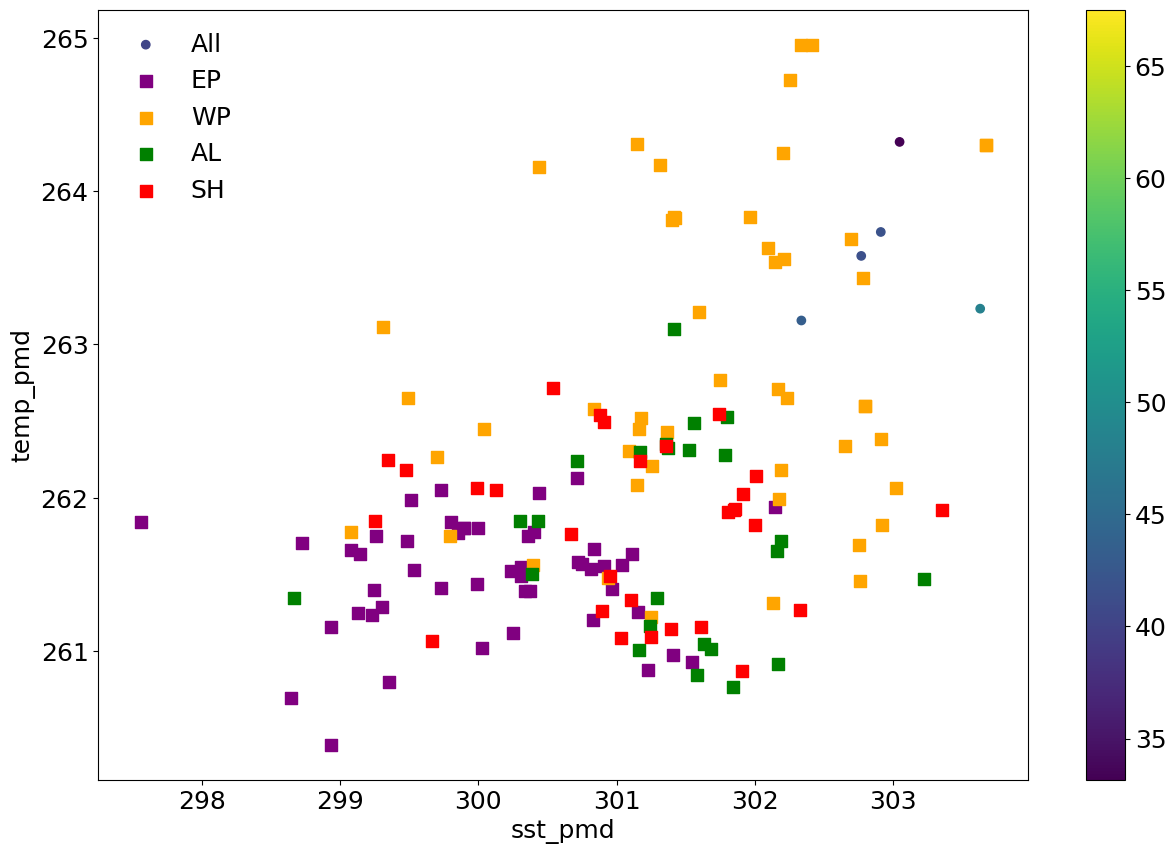

In [33]:
y = 'temp_pmd'

for prm in ['sst_pmd']:
    plt.scatter(d[prm],  d[y],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel(y)
    plt.show()

(array([13., 28., 29., 16.,  1.,  0.,  6., 19., 19., 25.]),
 array([-1.26640832, -1.05254229, -0.83867626, -0.62481023, -0.4109442 ,
        -0.19707817,  0.01678786,  0.23065388,  0.44451991,  0.65838594,
         0.87225197]),
 <BarContainer object of 10 artists>)

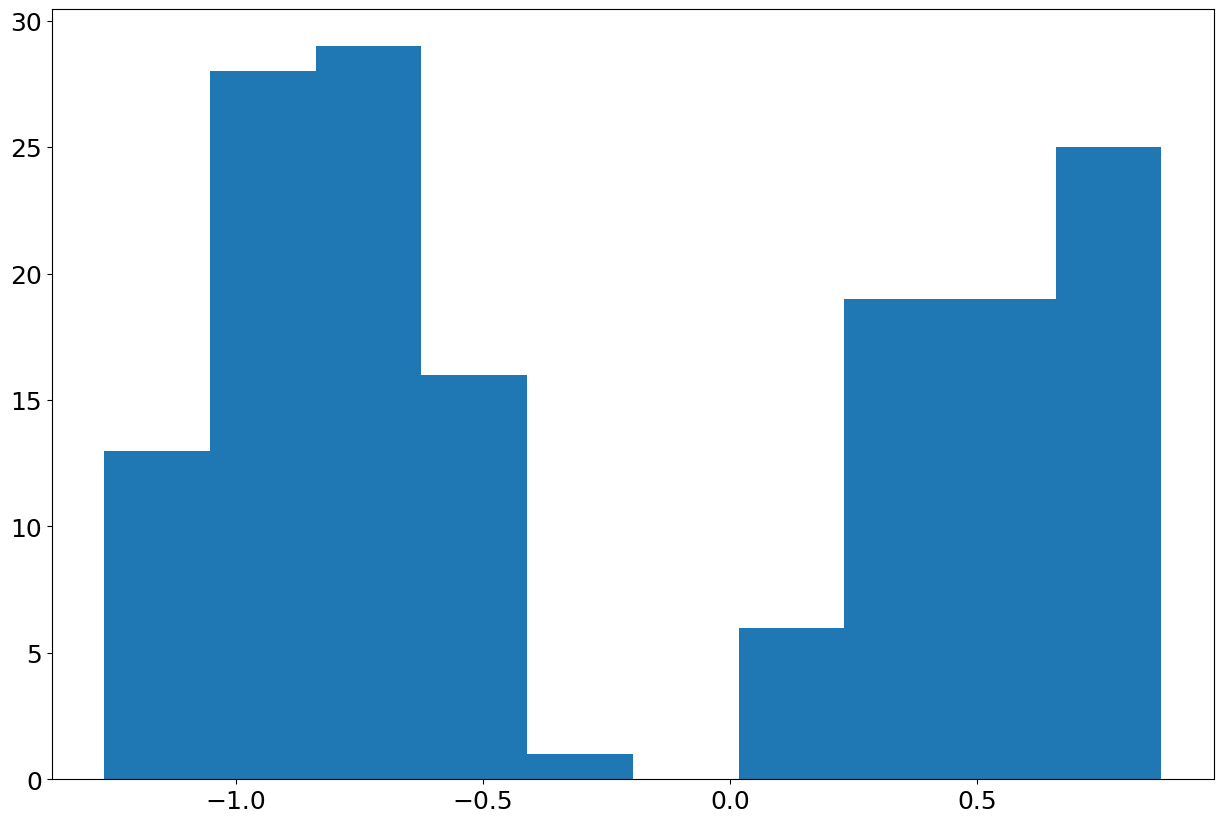

In [44]:
plt.hist(d.oni_psl)

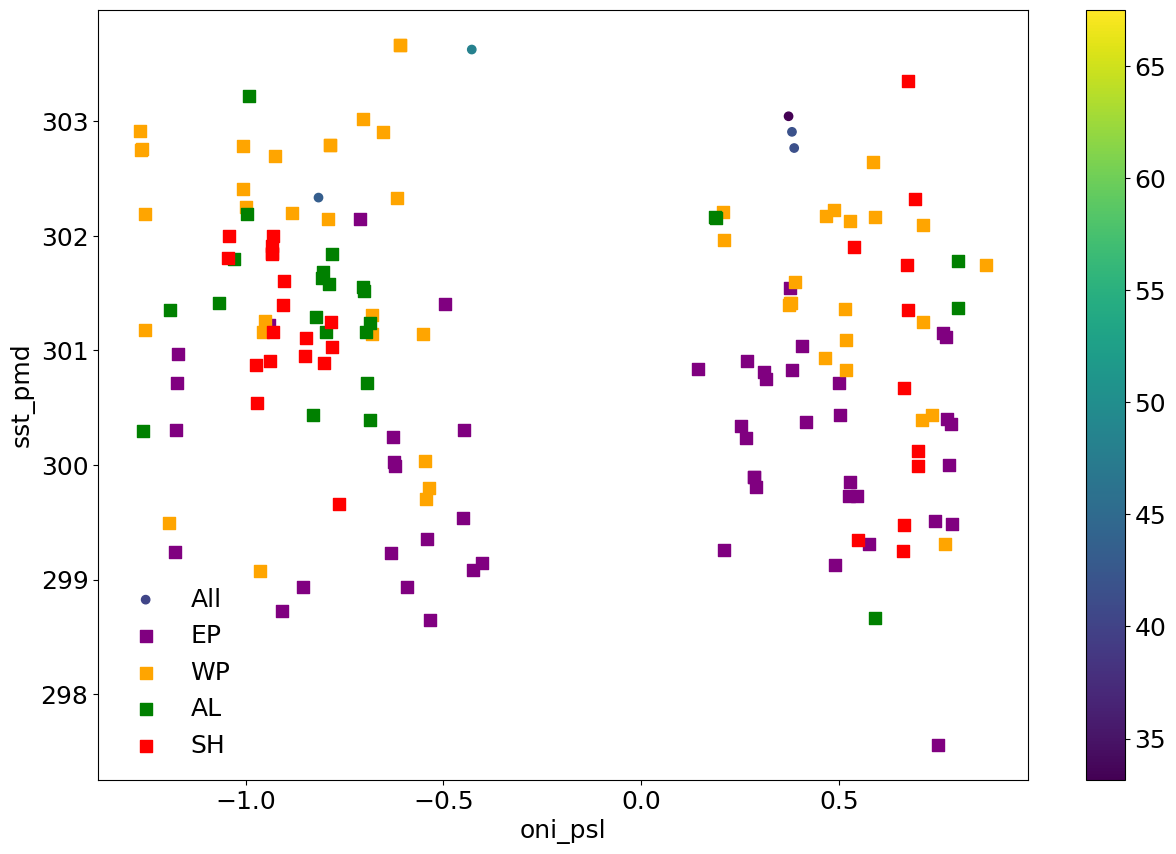

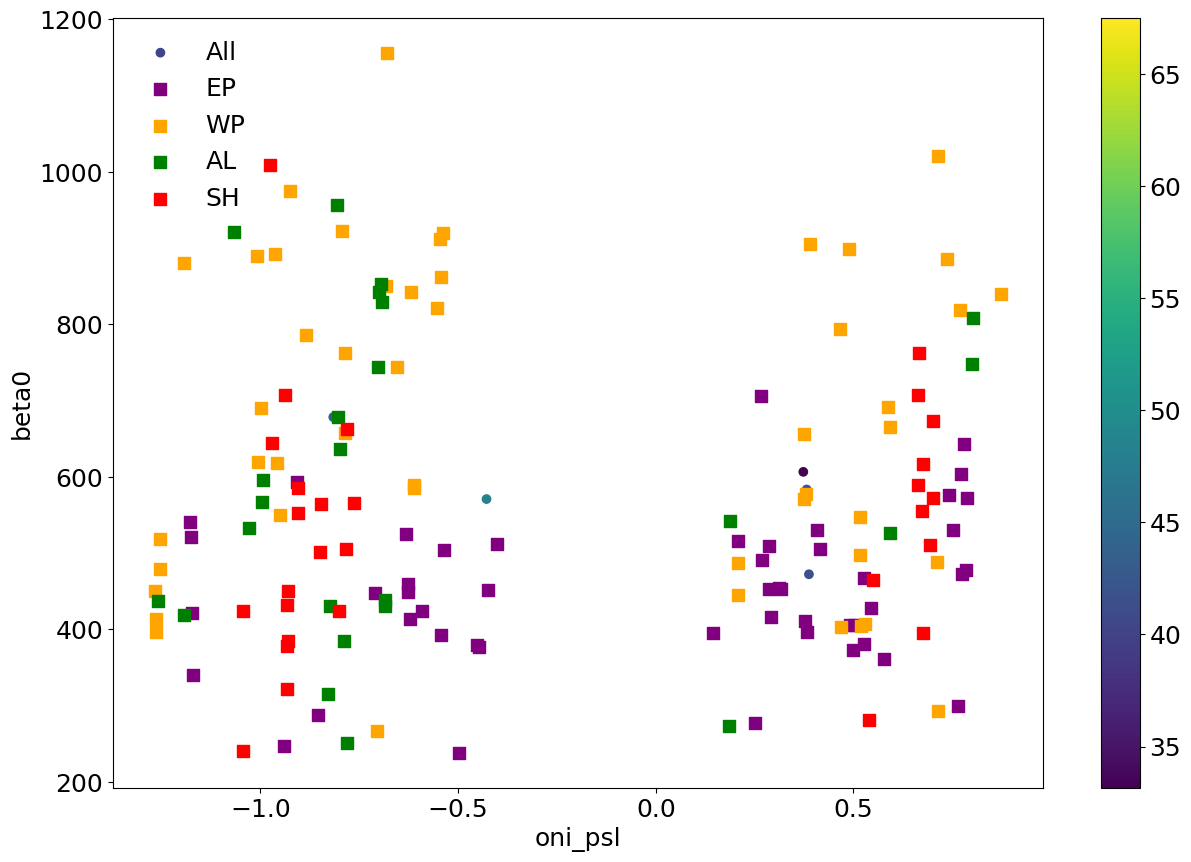

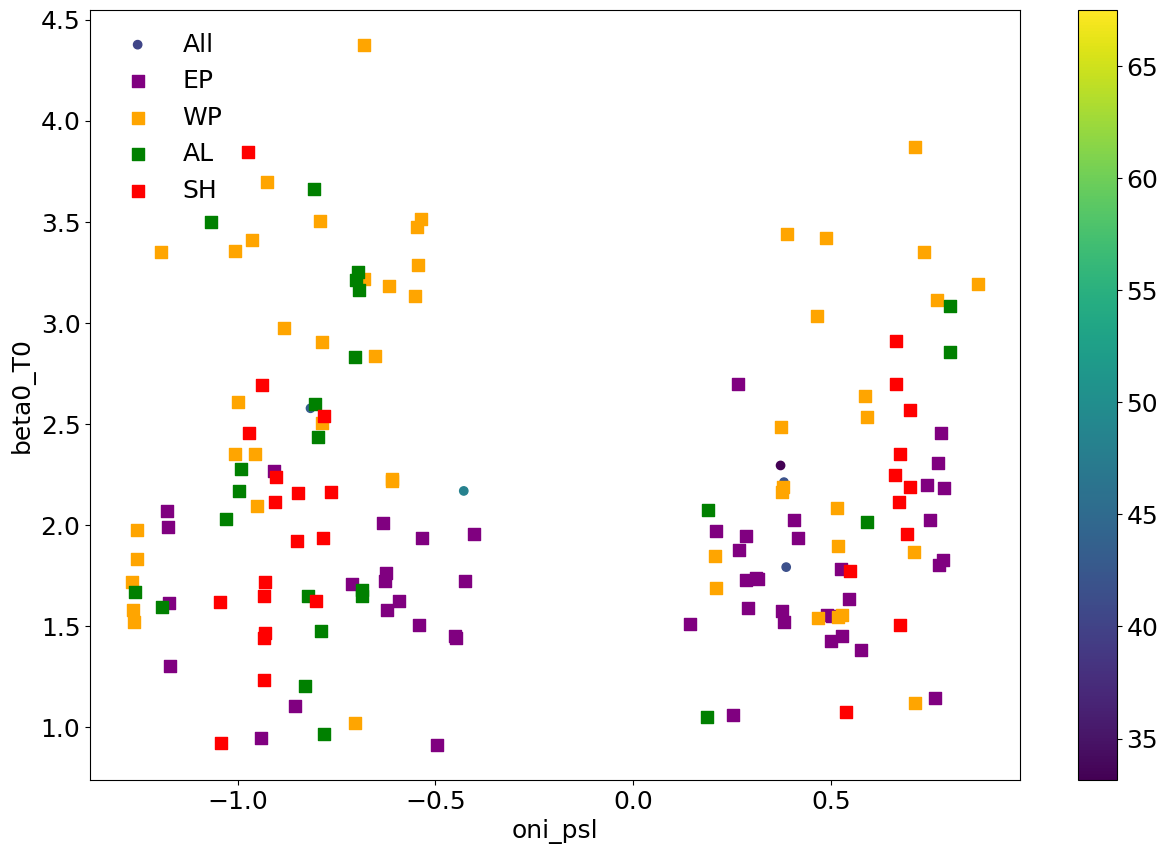

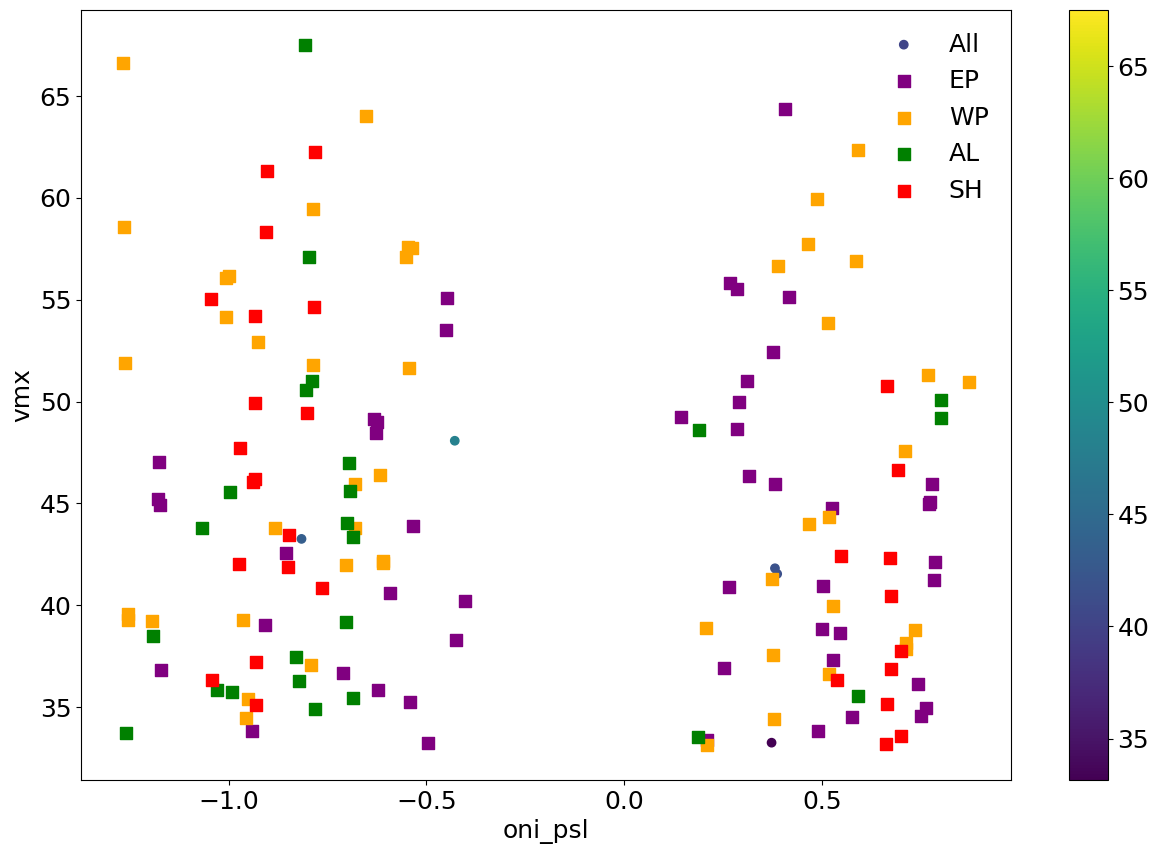

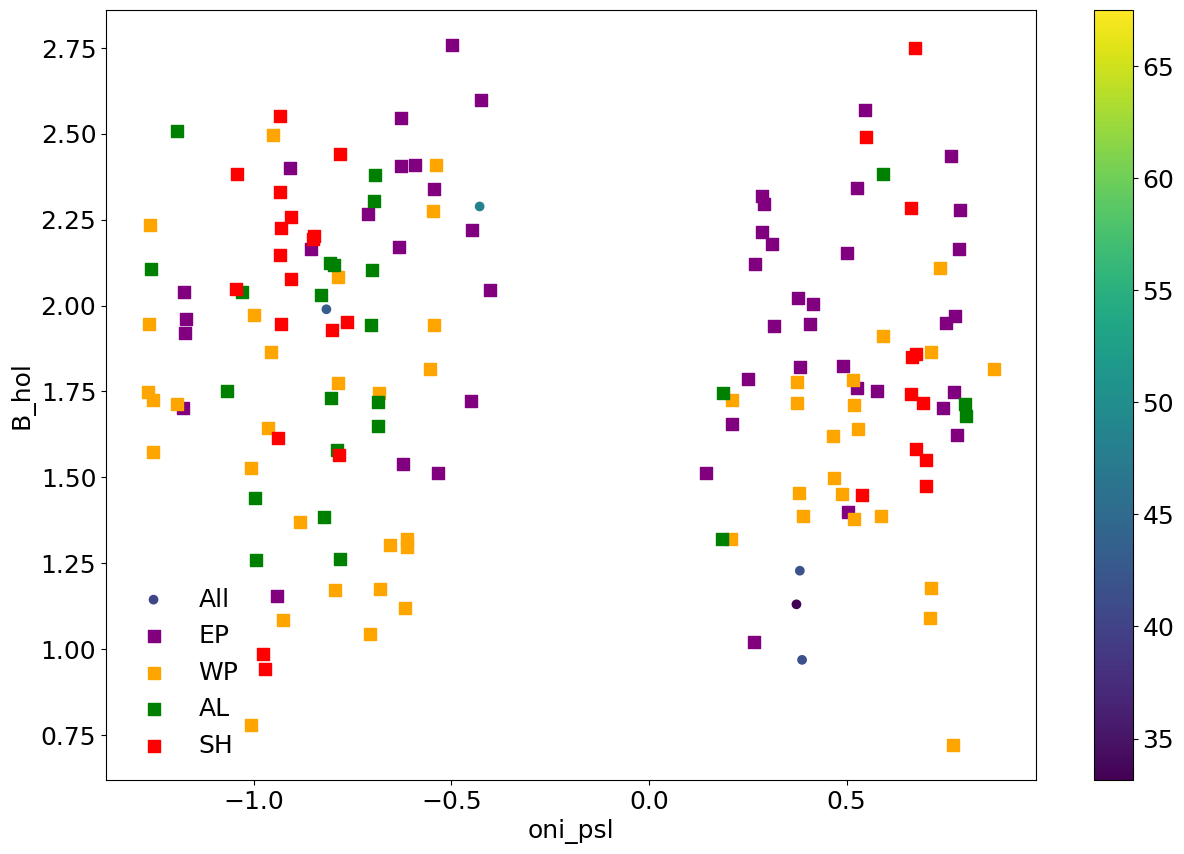

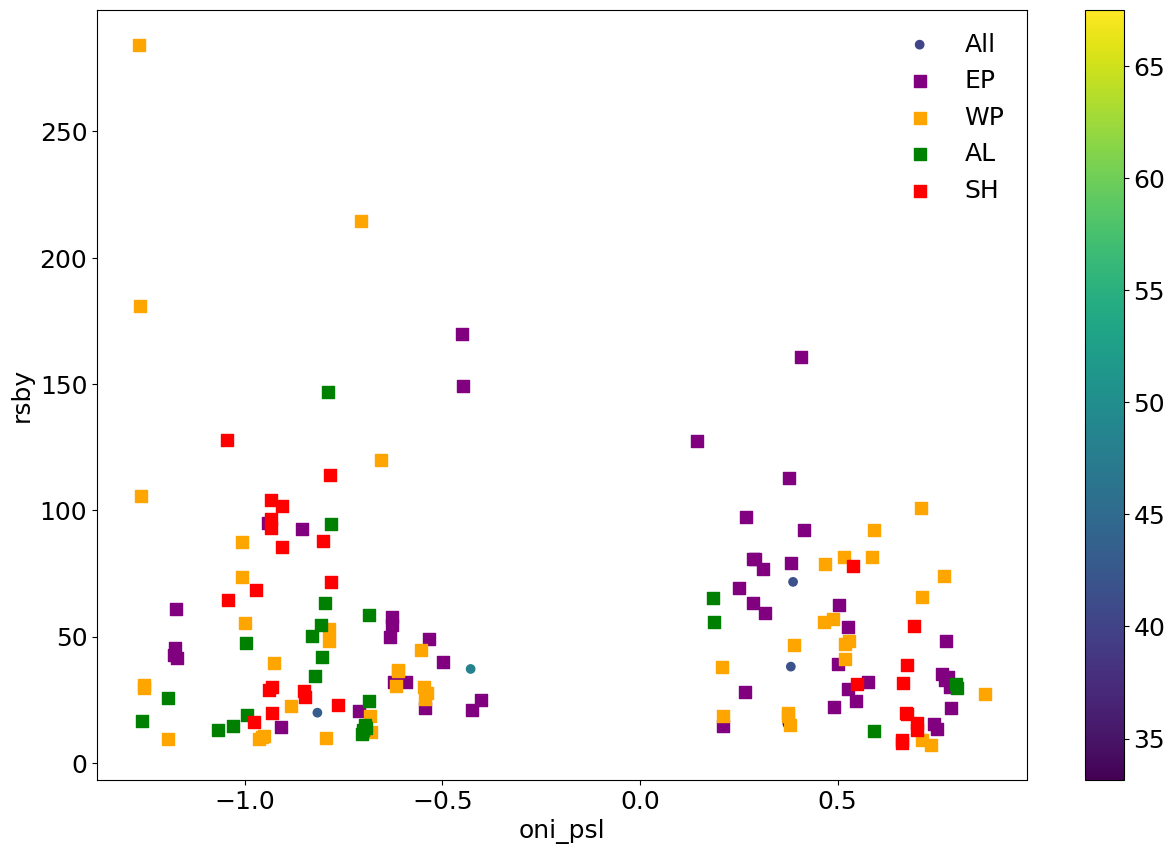

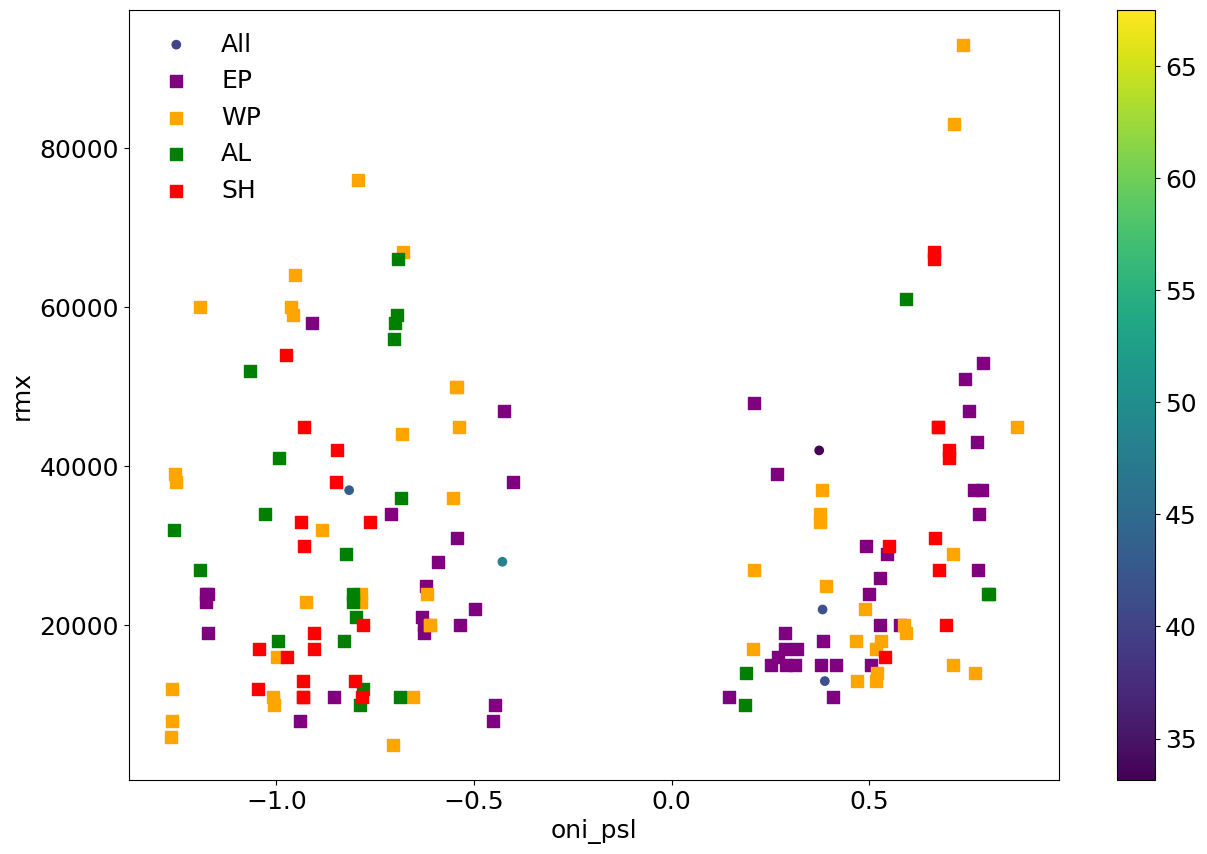

In [48]:
x = 'oni_psl'

for prm in ['sst_pmd', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(d[x],  d[prm],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[x], de[prm], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[x], dw[prm], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[x], da[prm], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[x], ds[prm], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

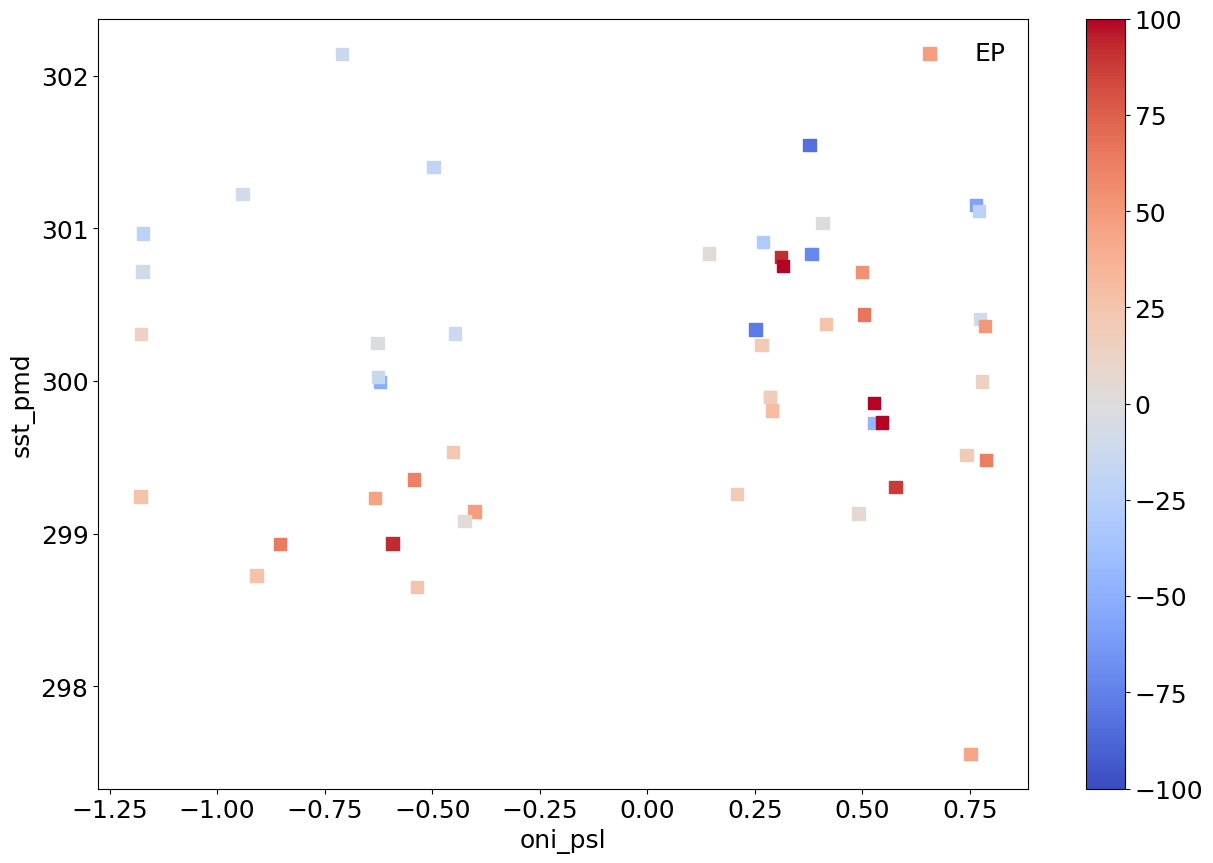

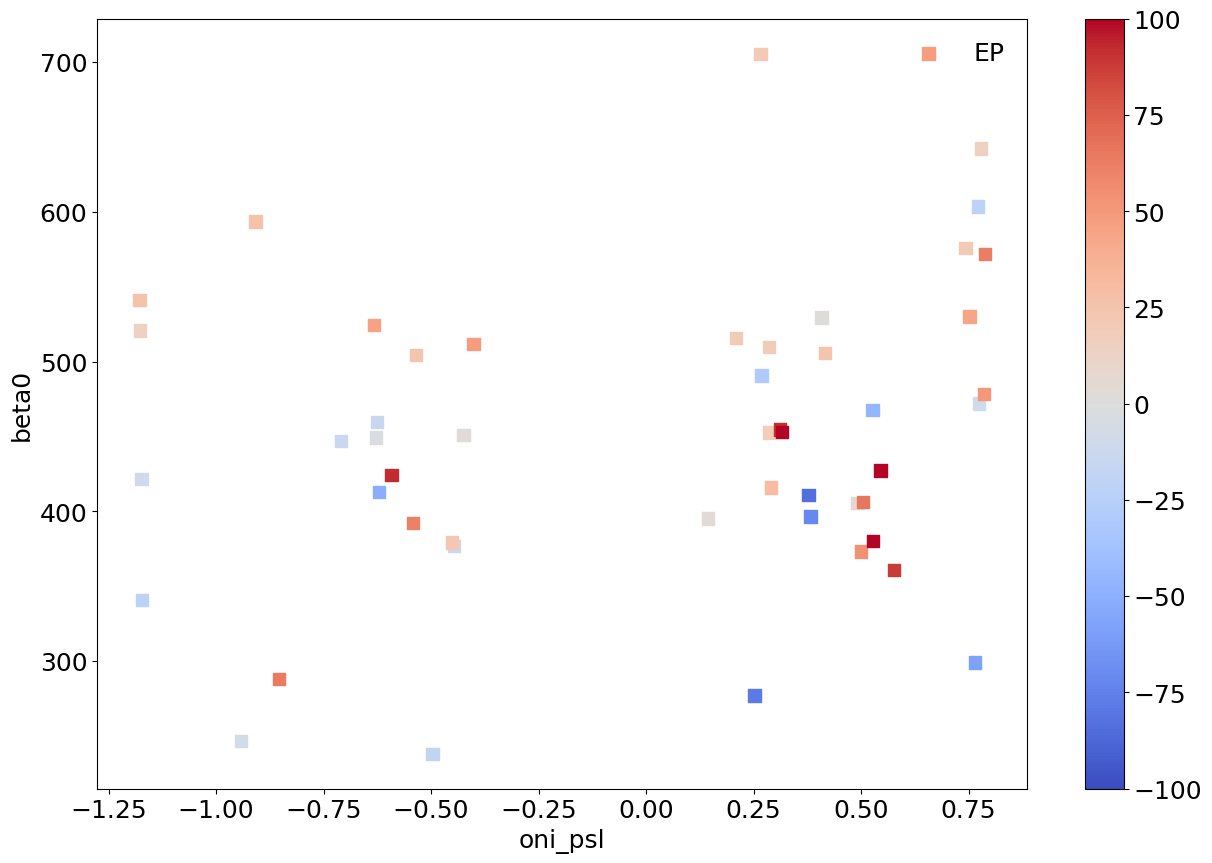

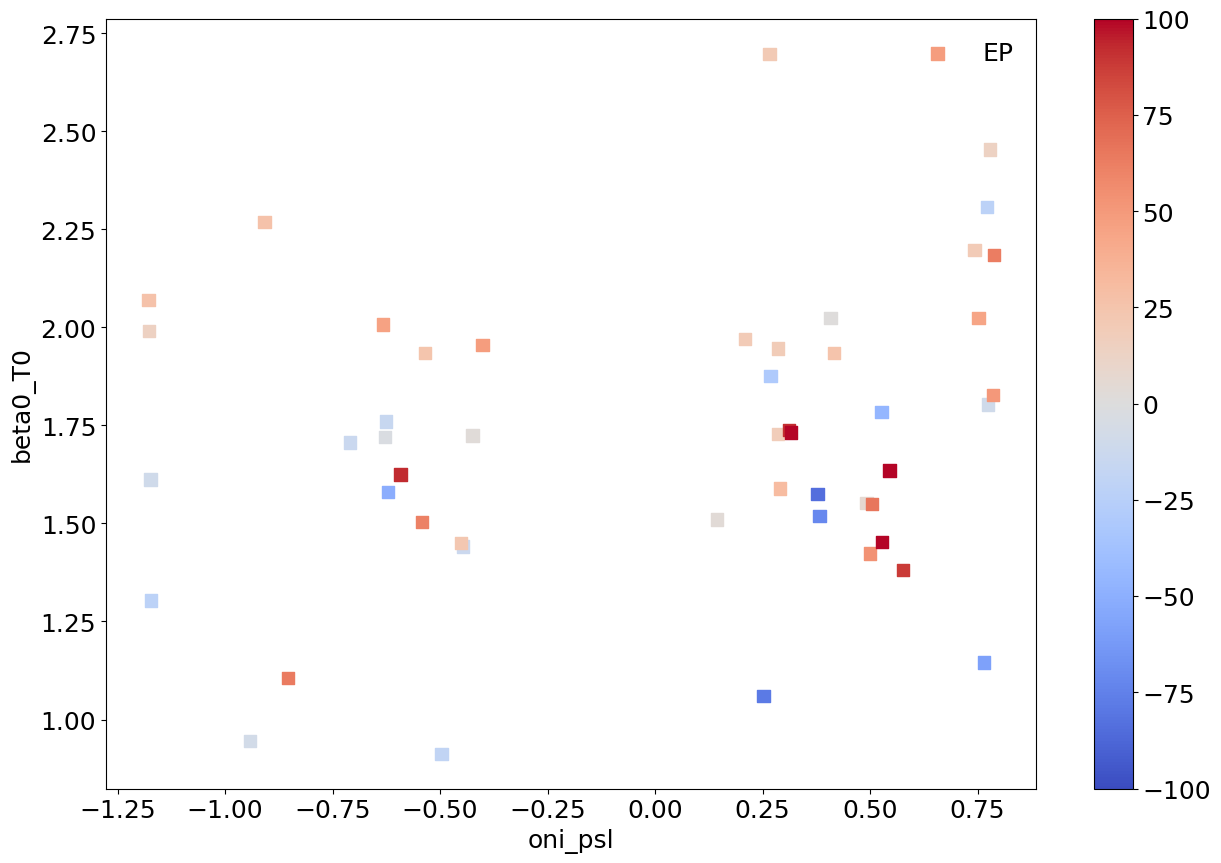

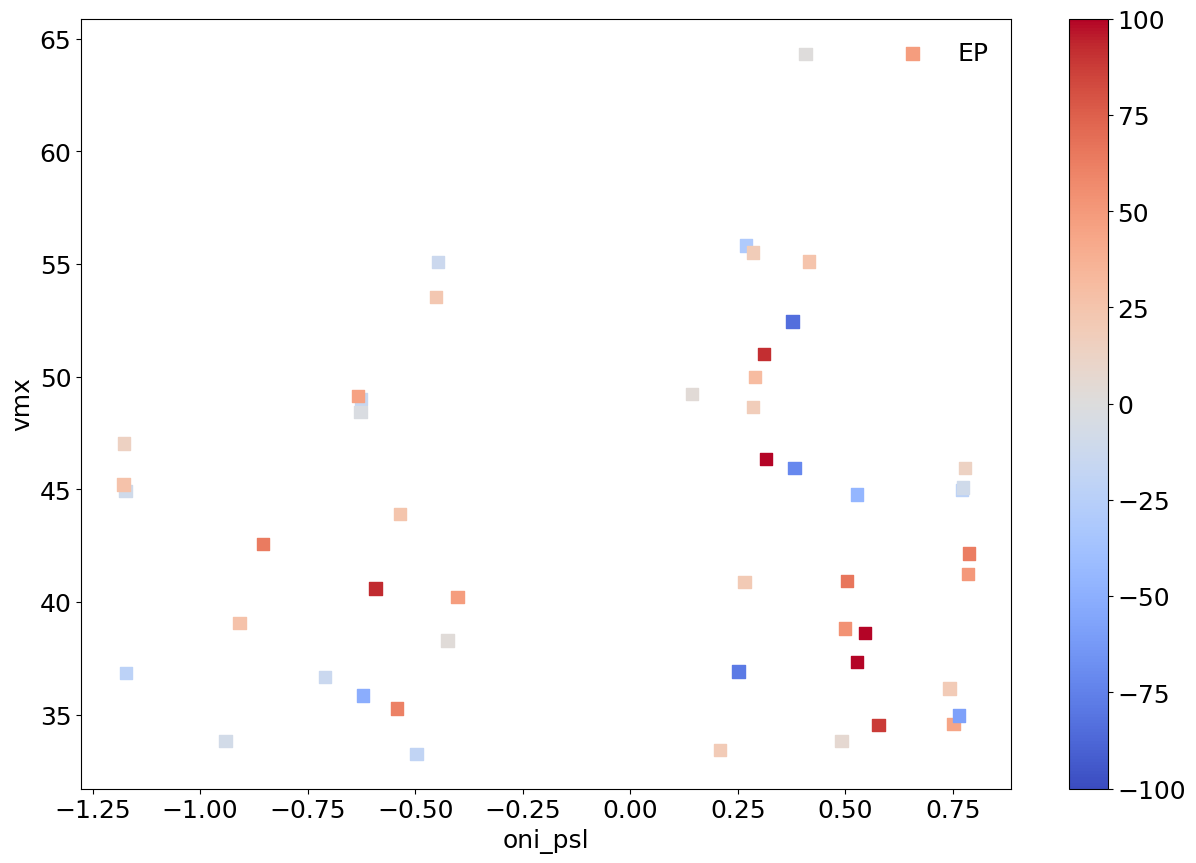

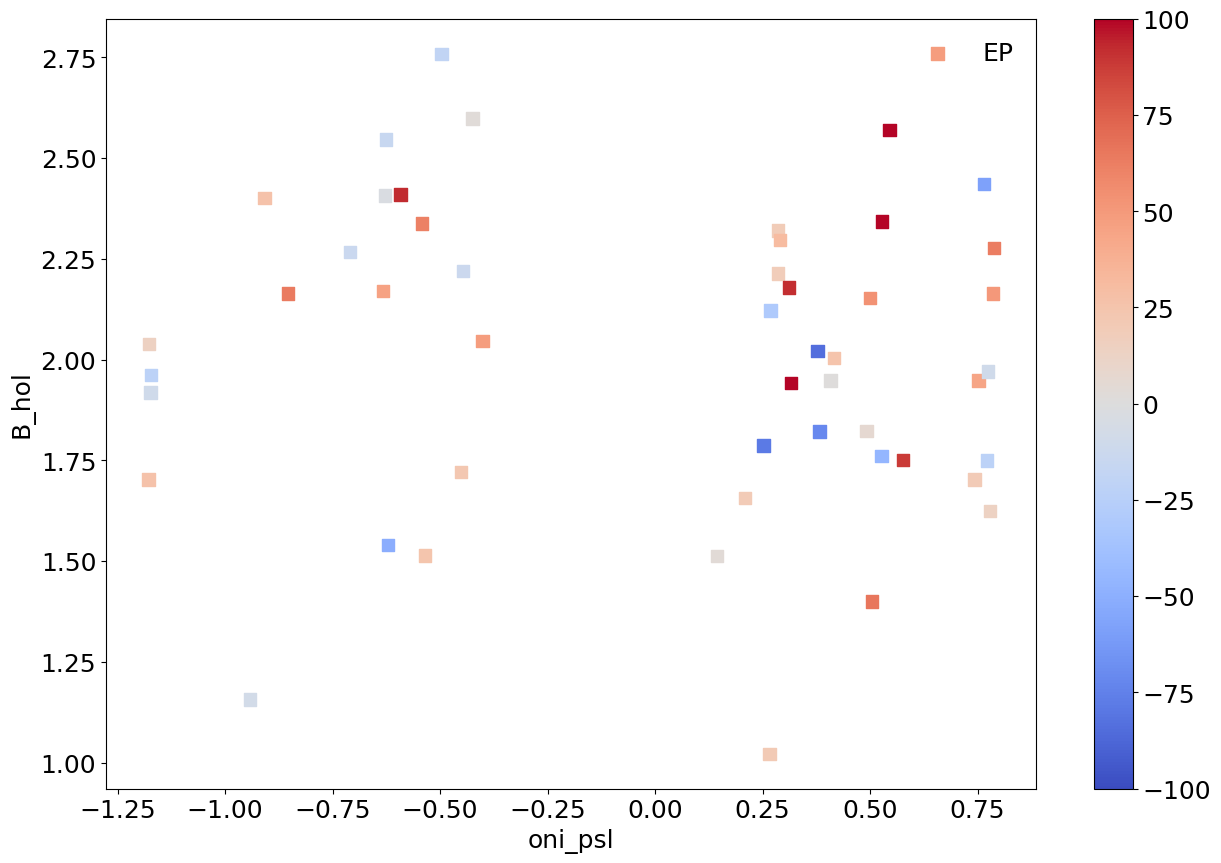

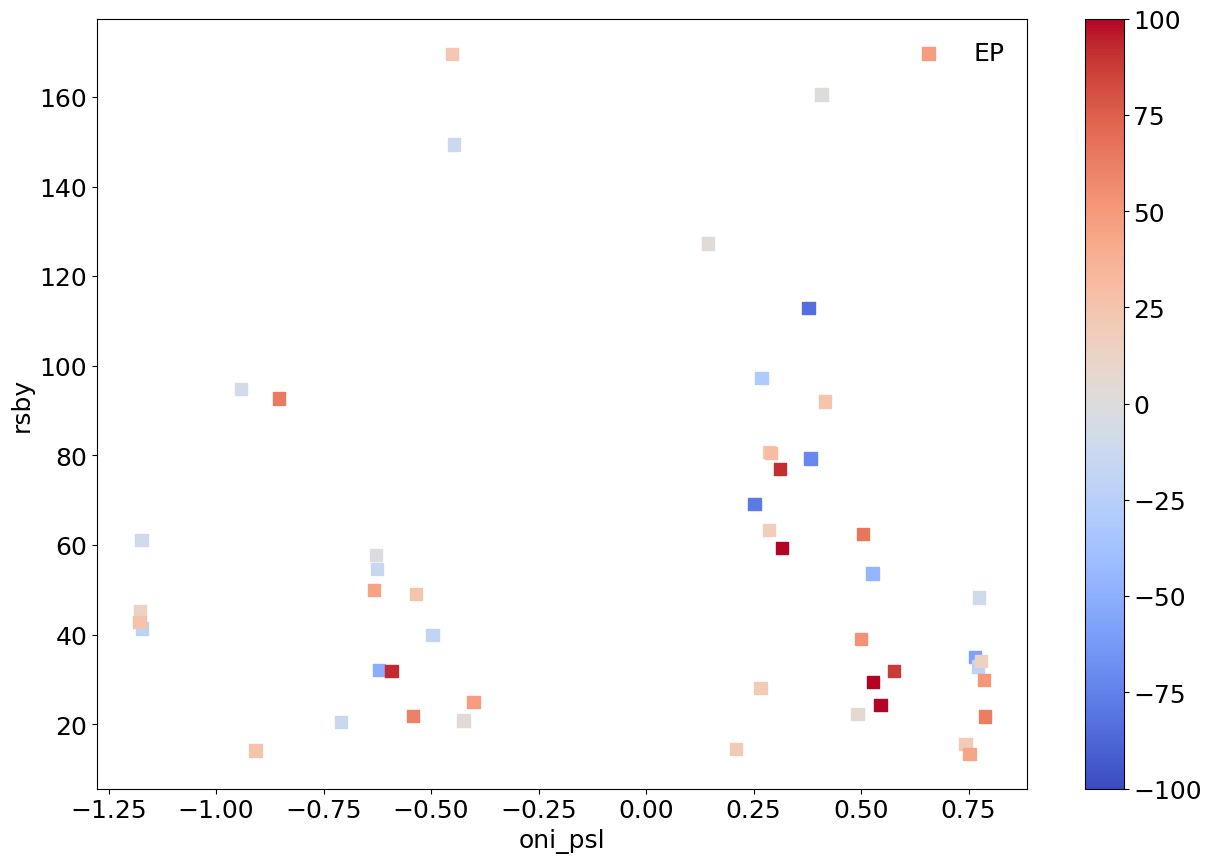

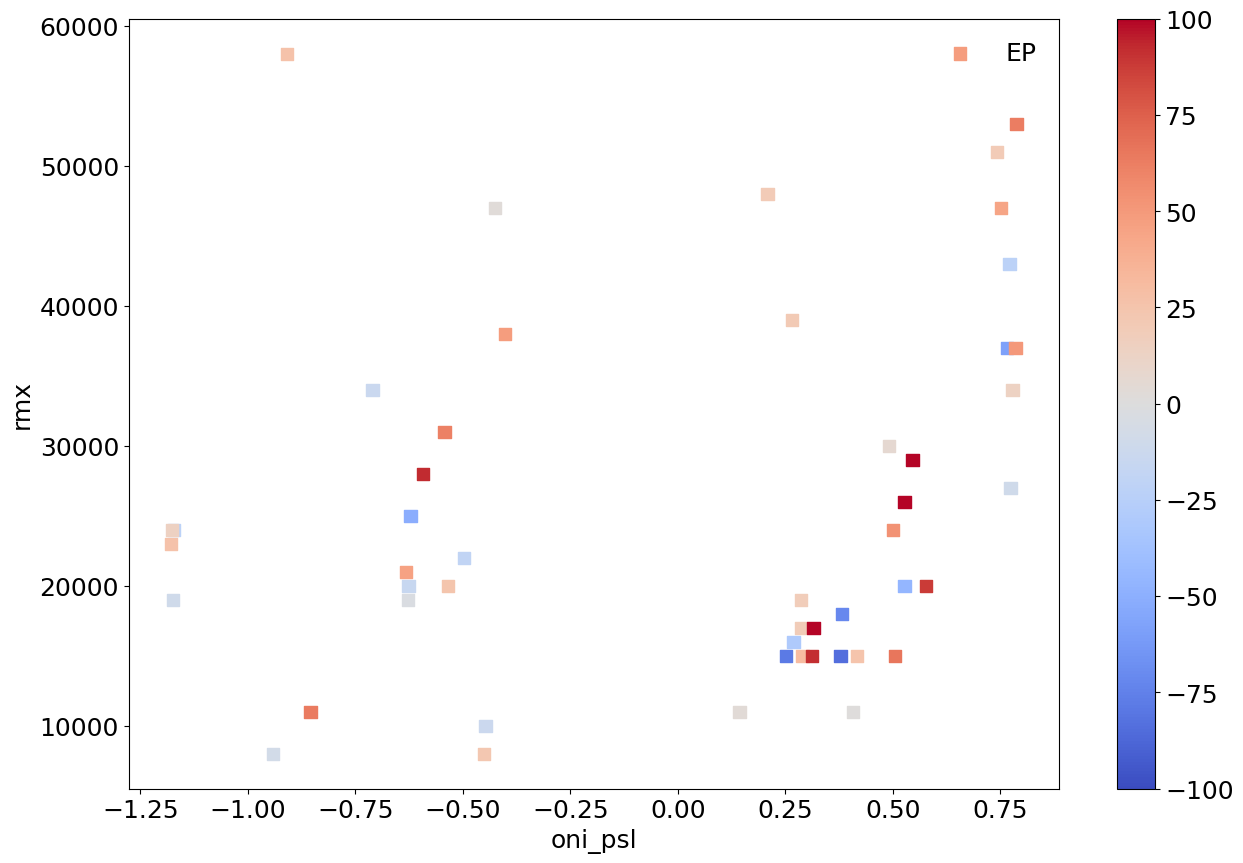

In [61]:
x = 'oni_psl'

for prm in ['sst_pmd', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(de[x], de[prm], c=de.t_since_lmi_ibt / 3600, marker='s', s=80, label='EP', cmap=cm.get_cmap('coolwarm'), vmin=-100, vmax=100)
    plt.colorbar()
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

In [ ]:
plt.scatter(d.sst_pmd, d.B_hol)
plt.scatter(d.rel_sst + 299, d.B_hol, c='r')

In [ ]:
plt.hist(d.beta0 / 10000)

In [ ]:
plt.scatter(d.sst_pmd, d.beta0)

In [ ]:
plt.hist(d.temp_pmd, bins=50)

In [ ]:
d.where(d.name == 'LARRY', drop=True)

In [ ]:
plt.scatter(d.where(d.name == 'LARRY', drop=True).time, d.where(d.name == 'LARRY', drop=True).B_hol)

In [ ]:
plt.scatter(d.sst_pmd, d.B_hol)

In [ ]:
plt.scatter(d.vws_pmd, d.B_hol)

In [ ]:
plt.scatter(abs(d.fcor), d.B_hol)

In [ ]:
plt.scatter(d.sst_pmd, d.uc, c=d.B_hol)

In [ ]:
plt.scatter(d.sst_pmd, d.r34)

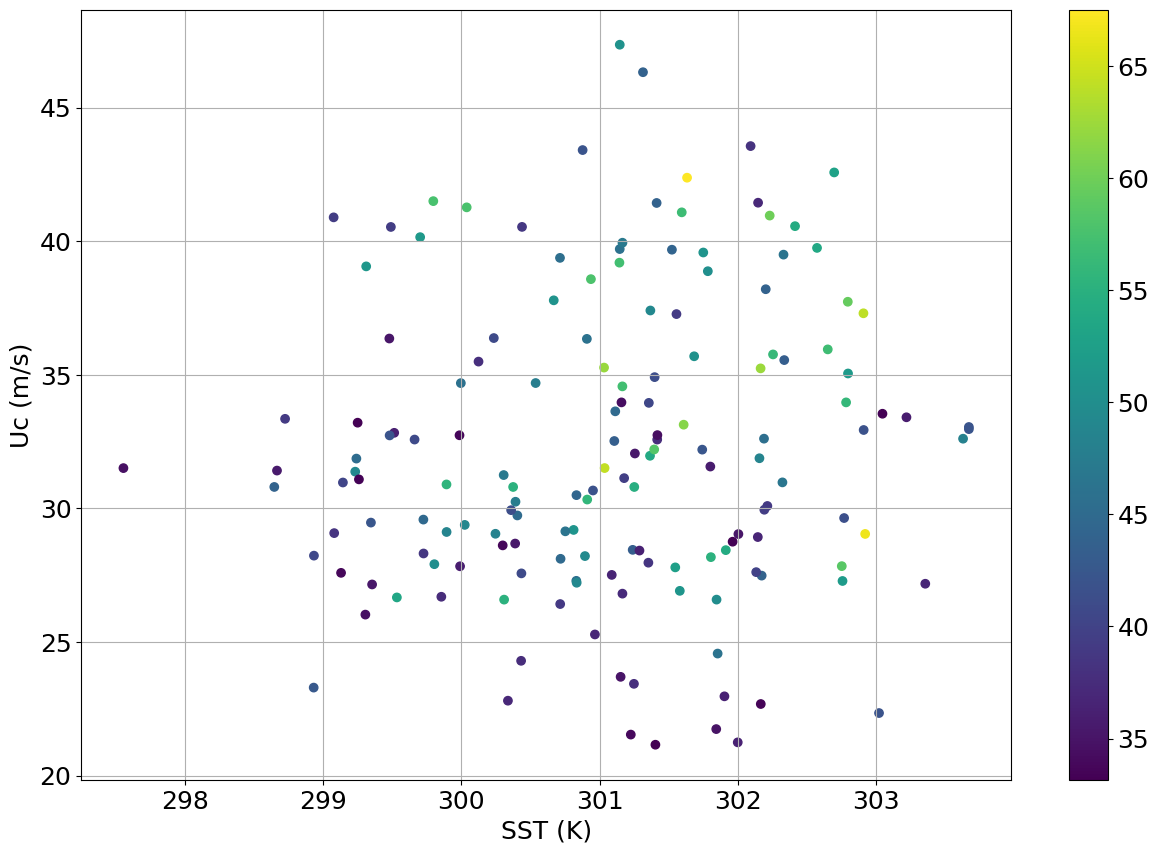

In [4]:
plt.scatter(d.sst_pmd, d.uc, c=d.vmx)
plt.xlabel('SST (K)')
plt.ylabel('Uc (m/s)')
plt.grid()
plt.colorbar()

In [5]:
d.isel(time=0).file.item().item()

'rs2--owi-cm-20160708t024536-20160708t024652-00003-______sw.nc'

In [6]:
d.isel(time=0).file_tcva.item().item()

'rs2--owi-ca-20160708t024536-20160708t024652-00003-______sw_ep032016_cyclone_polar.nc'

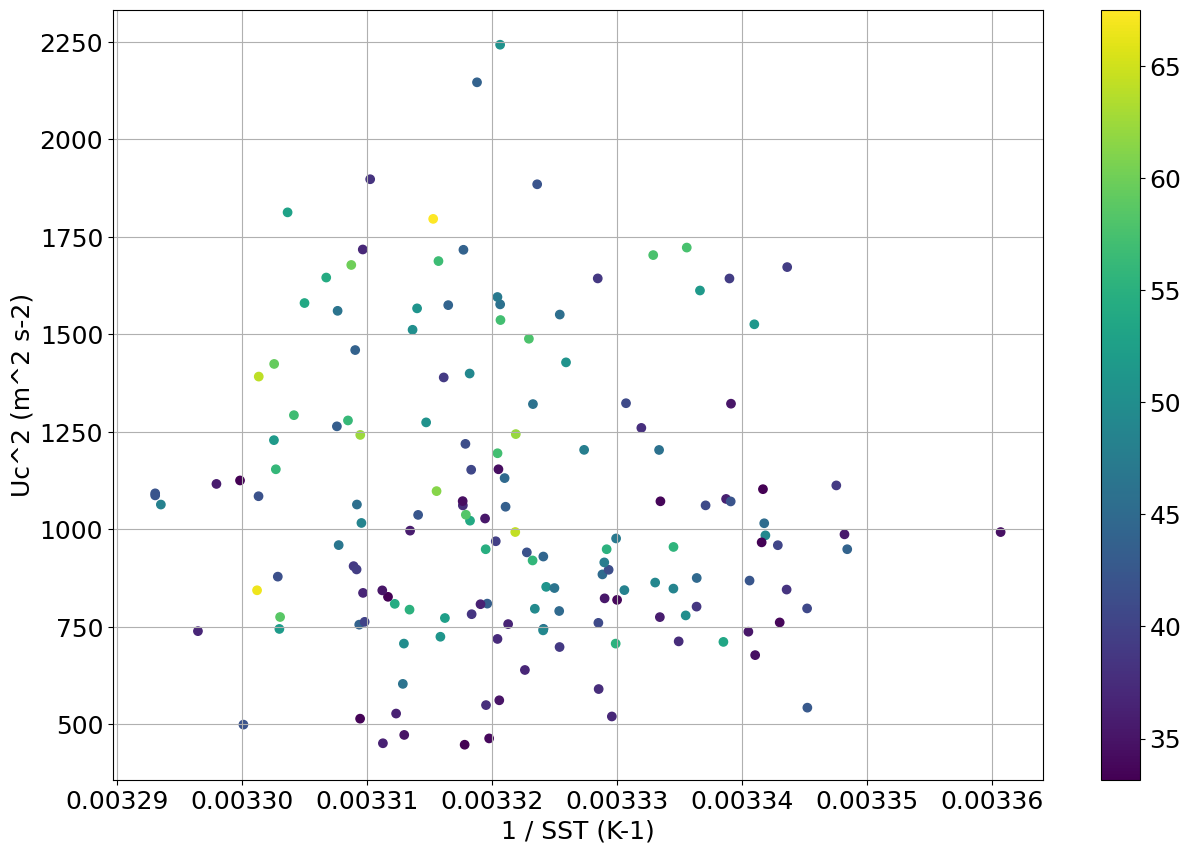

In [7]:
plt.scatter(1 / d.sst_pmd, d.uc ** 2, c=d.vmx)
plt.xlabel('1 / SST (K-1)')
plt.ylabel('Uc^2 (m^2 s-2)')
plt.grid()
plt.colorbar()

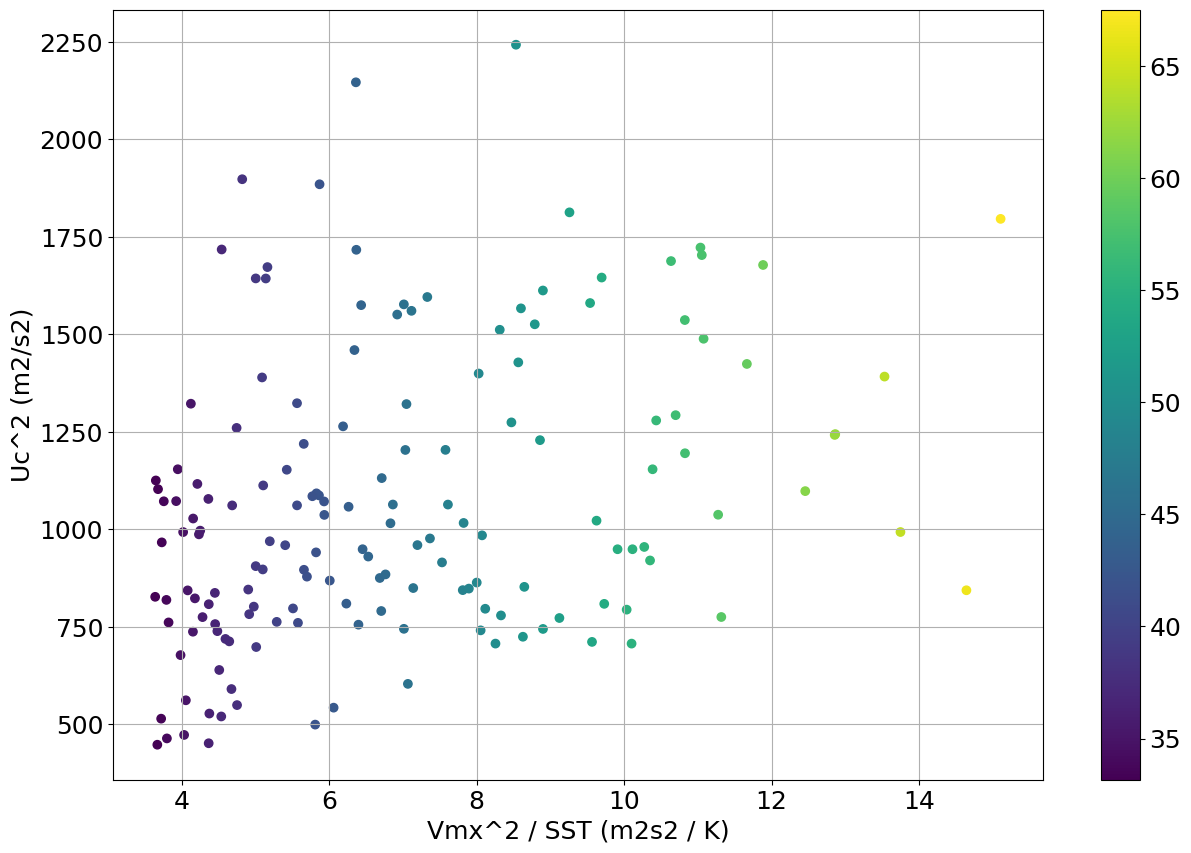

In [8]:
plt.scatter(d.vmx ** 2 / d.sst_pmd, d.uc ** 2, c=d.vmx)
plt.xlabel('Vmx^2 / SST (m2s2 / K)')
plt.ylabel('Uc^2 (m2/s2)')
plt.grid()
plt.colorbar()

In [9]:
da = d.where(d.basin == 'al', drop=True)
dc = d.where(d.basin == 'cp', drop=True)
de = d.where(d.basin == 'ep', drop=True)
di = d.where(d.basin == 'io', drop=True)
ds = d.where(d.basin == 'sh', drop=True)
dw = d.where(d.basin == 'wp', drop=True)

list_of_dbasin = [da, de, dw, dc, di, ds]
basin_names    = ['AL', 'EP', 'WP', 'CP',  'IO', 'SH']

Text(0, 0.5, 'uc')

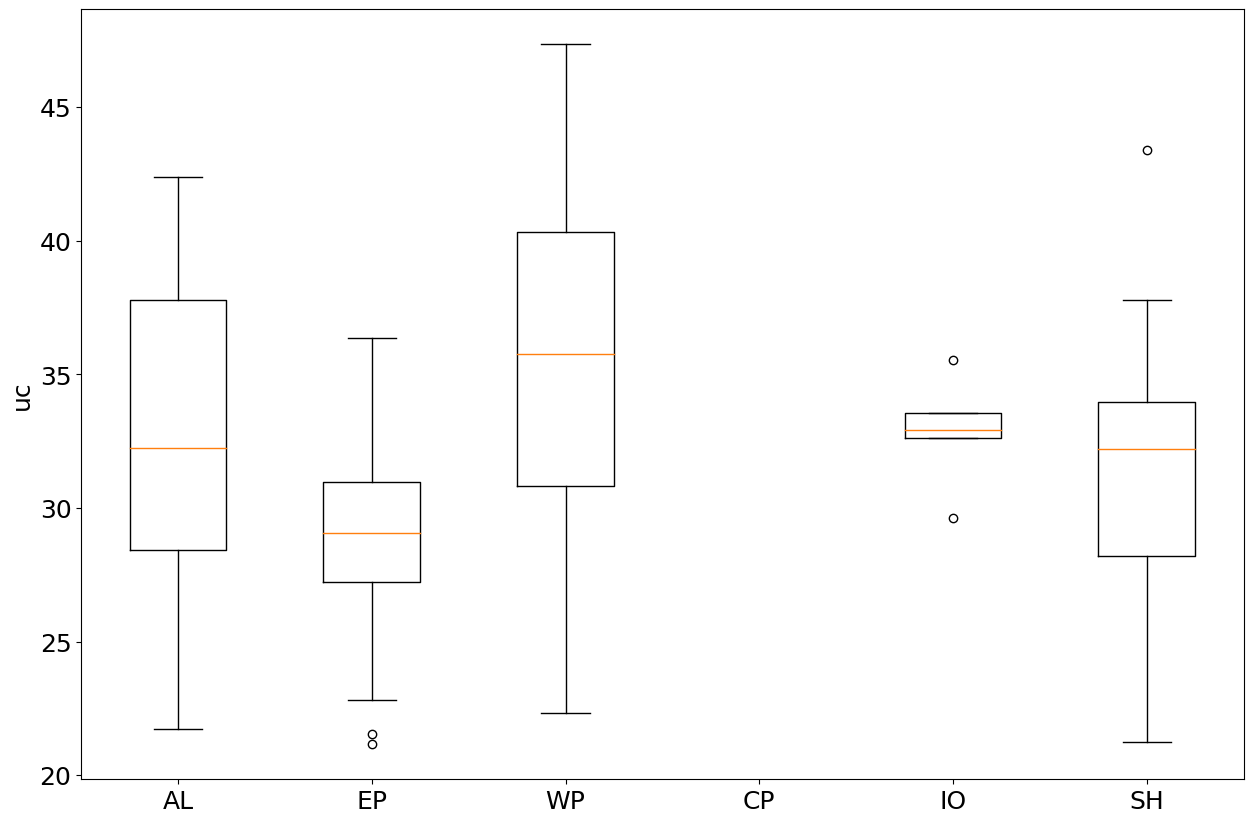

In [10]:
prm      = 'uc'
dict_prm = dict(zip(basin_names, [dbasin[prm] for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()
ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'sst_pmd')

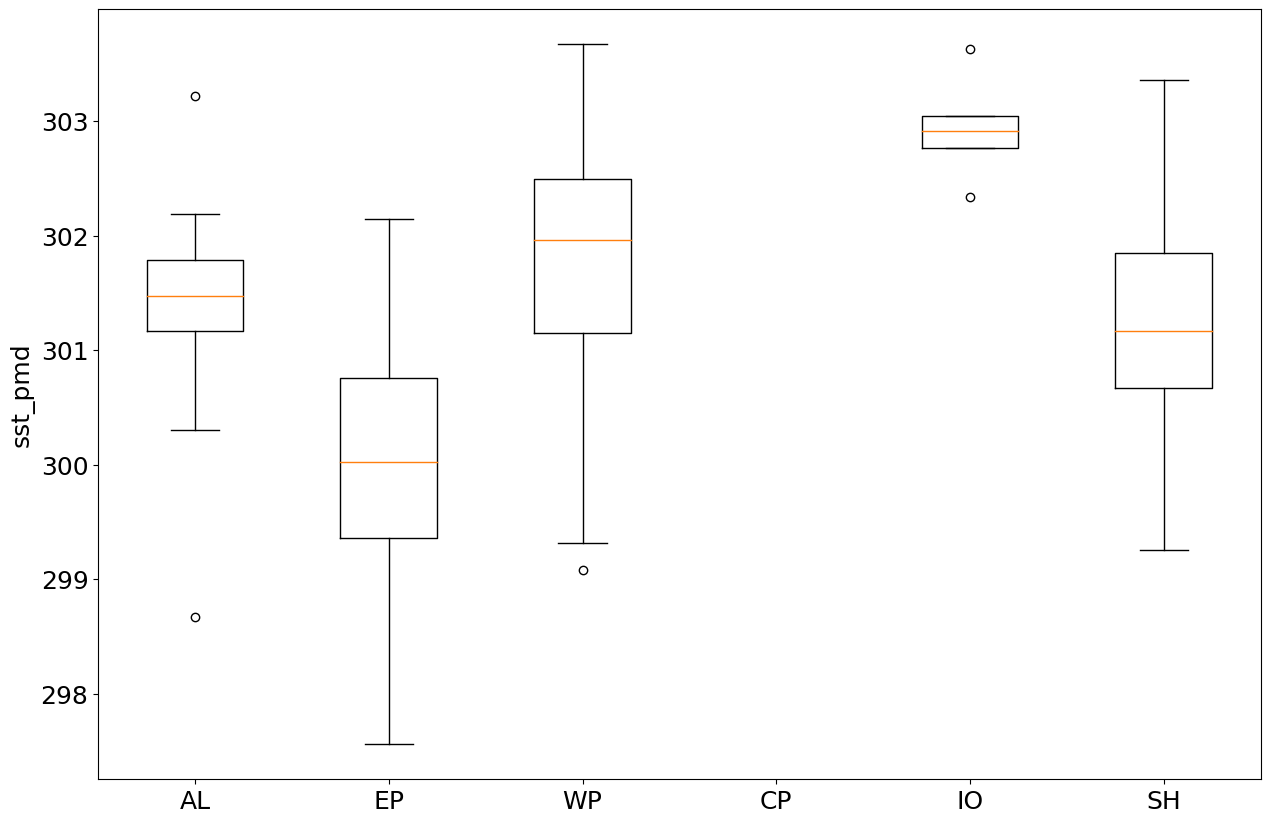

In [11]:
prm      = 'sst_pmd'
dict_prm = dict(zip(basin_names, [dbasin[prm] for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()
ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'vmx')

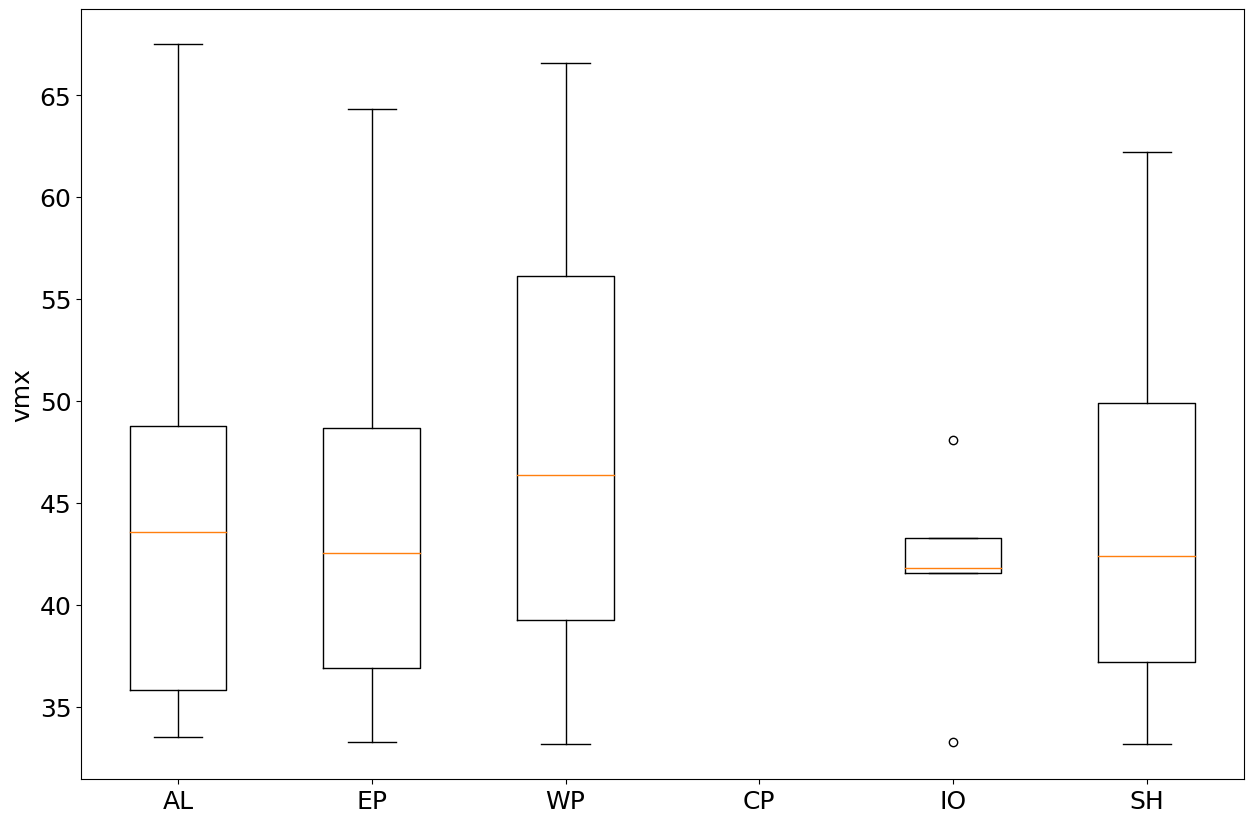

In [12]:
prm      = 'vmx'
dict_prm = dict(zip(basin_names, [dbasin[prm] for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()
ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'rmx')

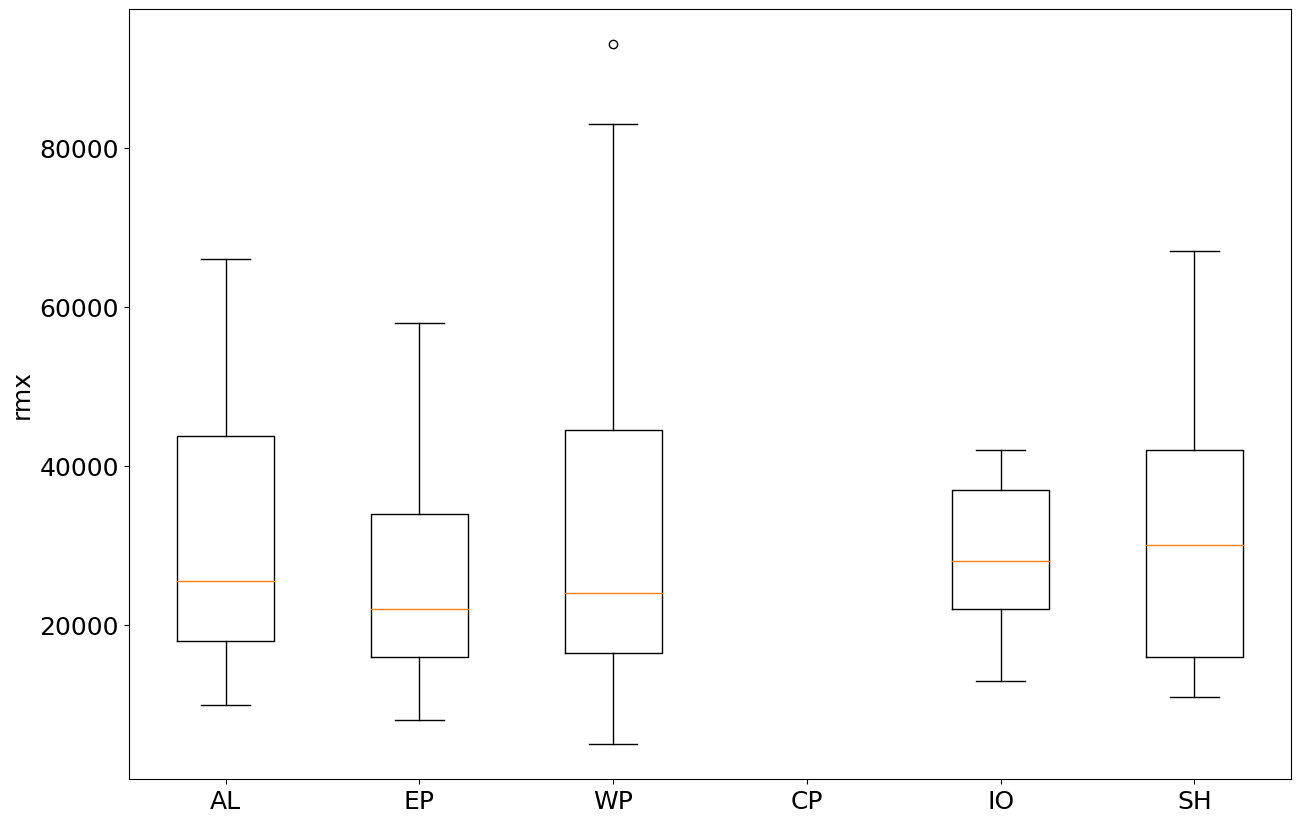

In [13]:
prm      = 'rmx'
dict_prm = dict(zip(basin_names, [dbasin[prm] for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()
ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'fcor')

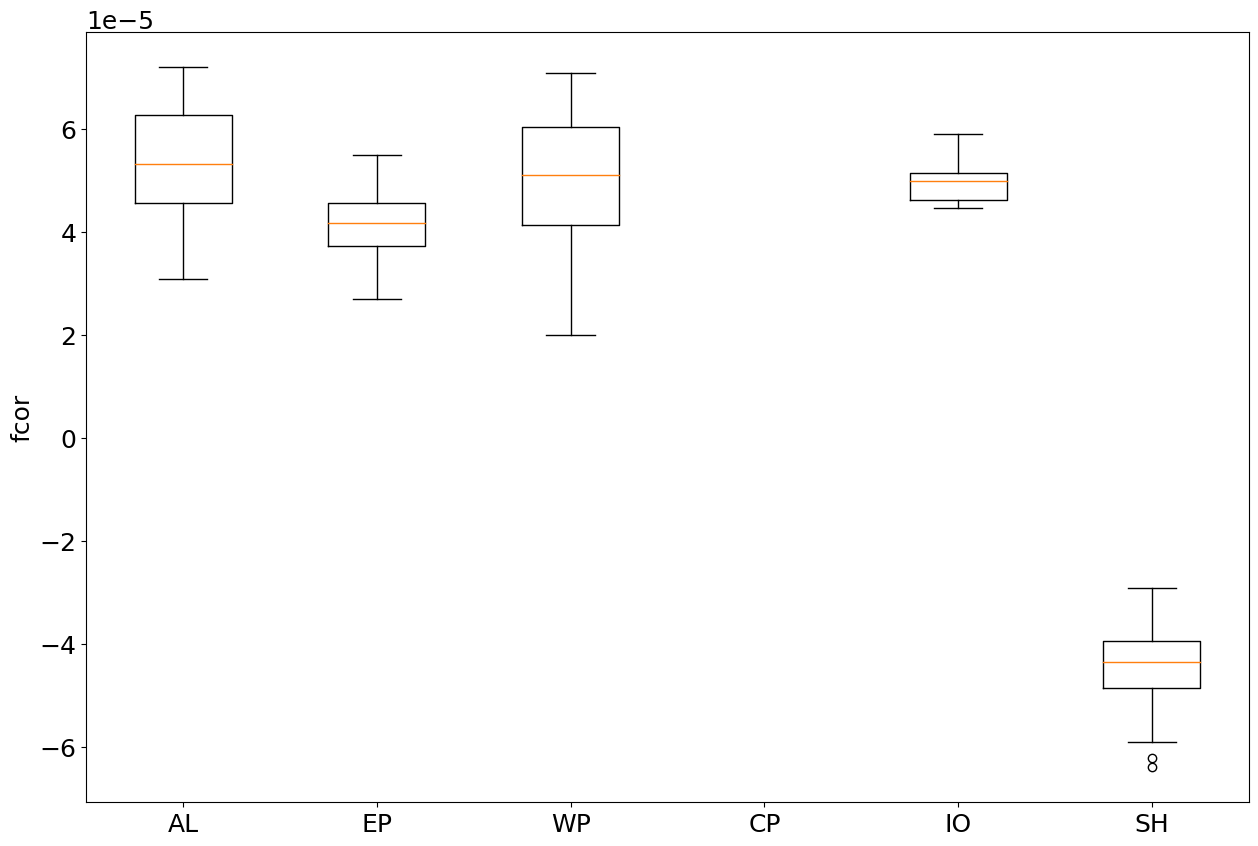

In [14]:
prm      = 'fcor'
dict_prm = dict(zip(basin_names, [dbasin[prm] for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()
ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'B_hol')

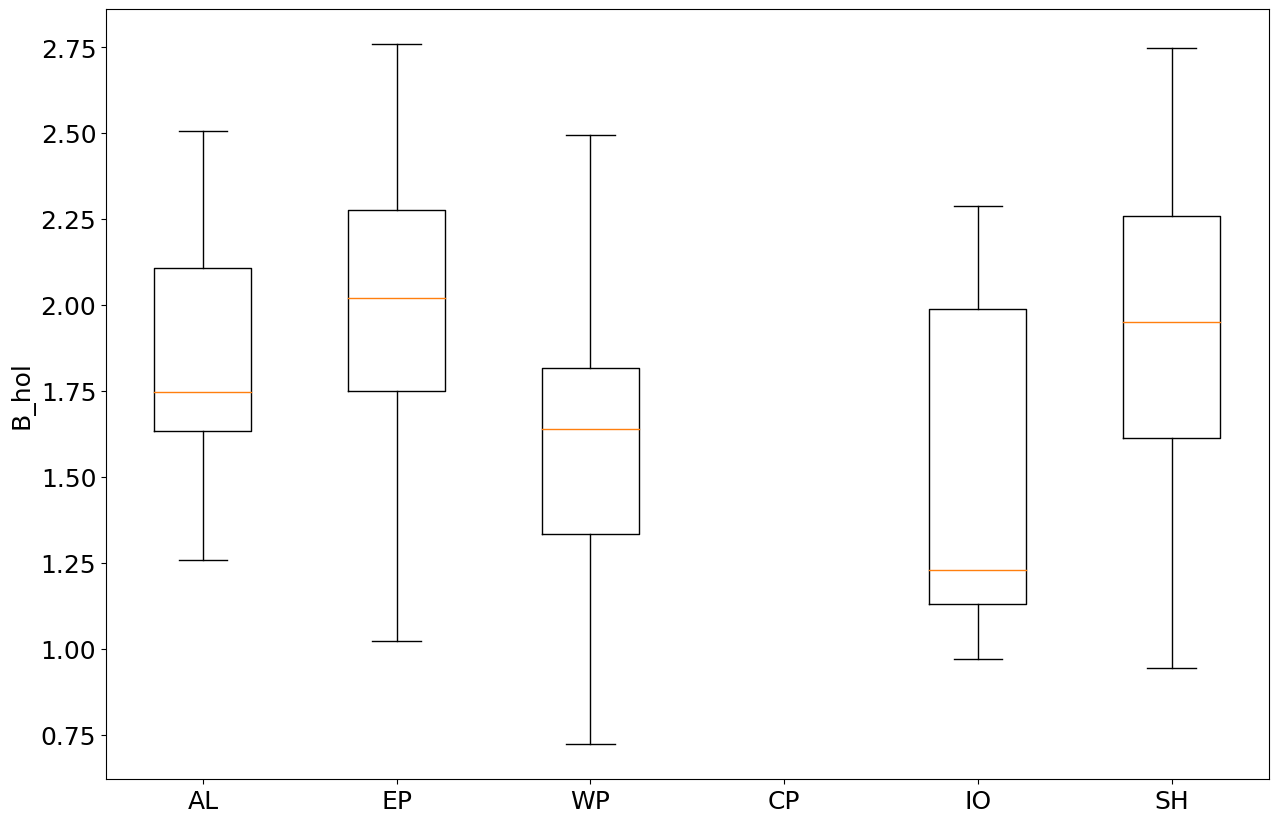

In [15]:
prm      = 'B_hol'
dict_prm = dict(zip(basin_names, [dbasin[prm] for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()
ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'r0')

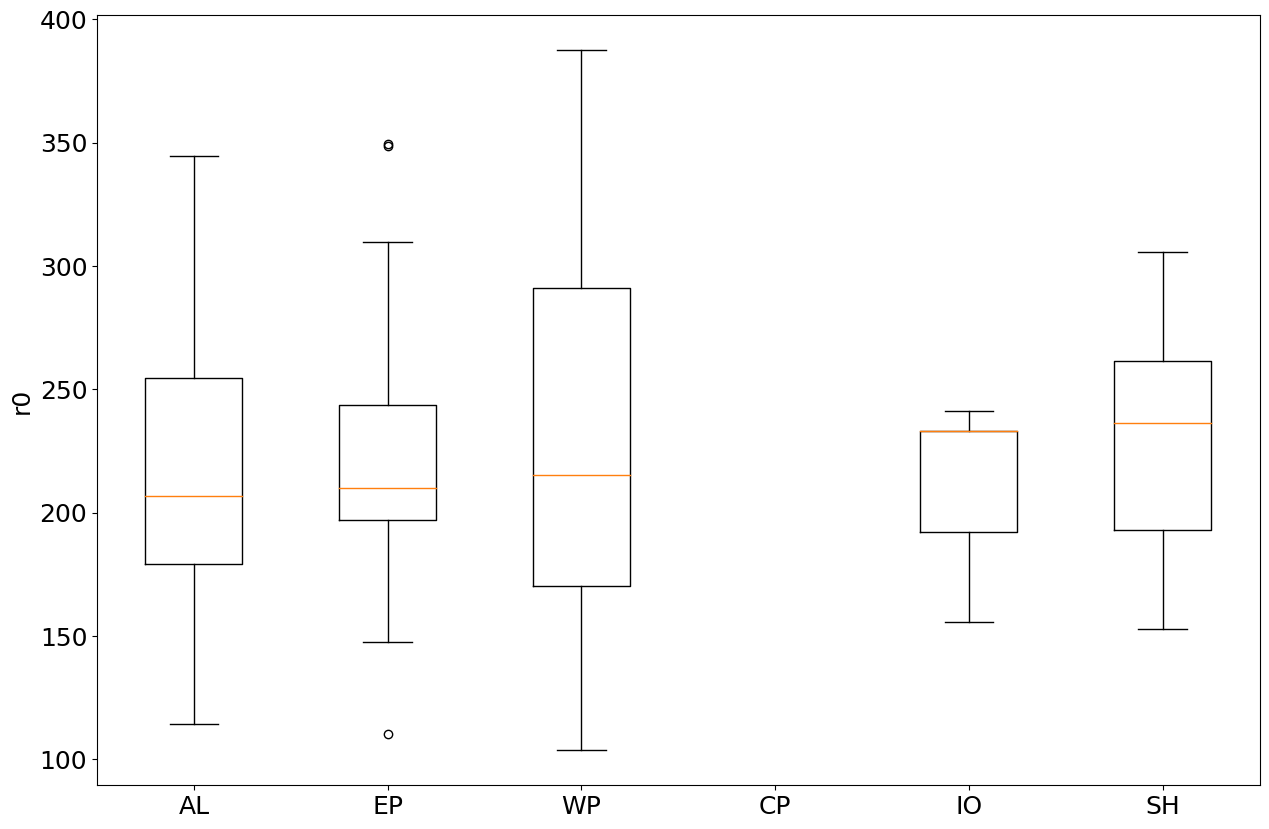

In [16]:
prm      = 'r0'
dict_prm = dict(zip(basin_names, [dbasin[prm] / 1000 for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()

ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'rsby')

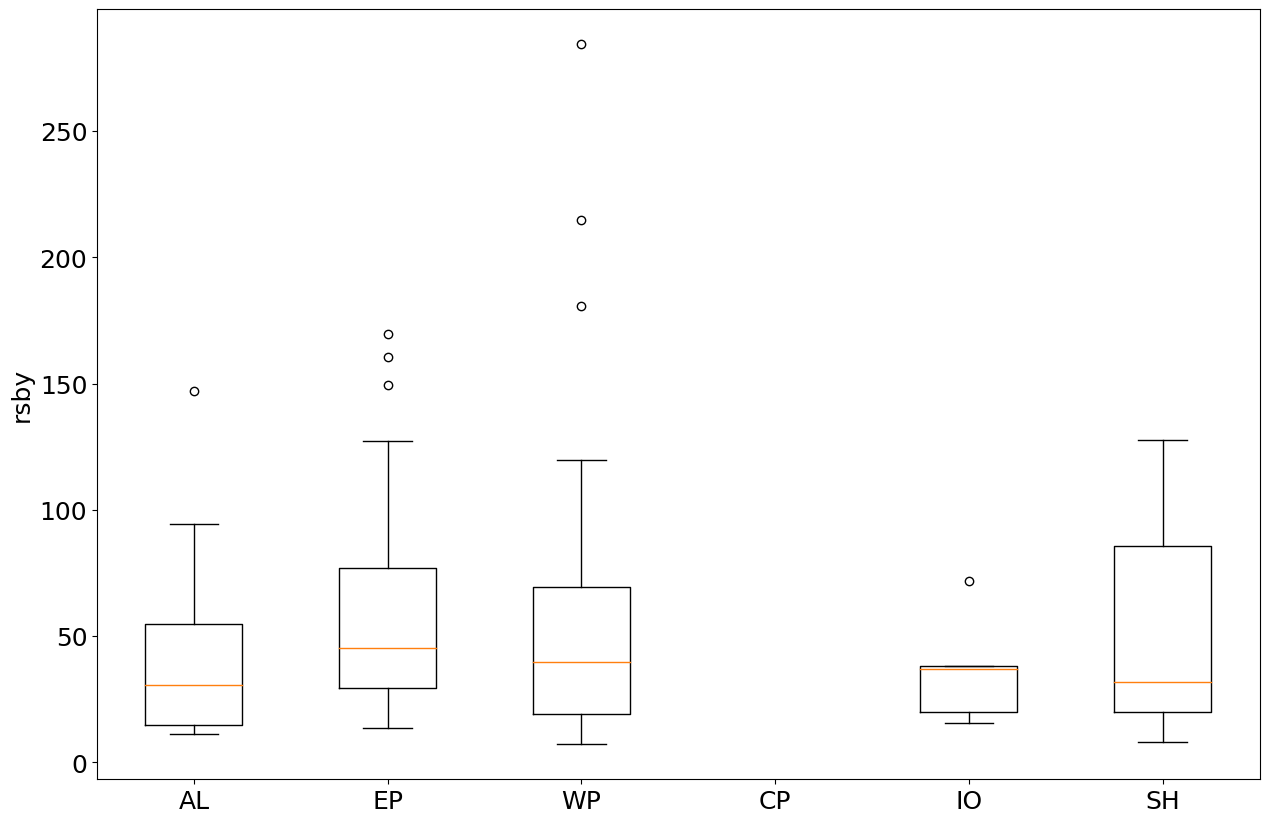

In [24]:
prm      = 'rsby'
dict_prm = dict(zip(basin_names, [dbasin[prm] for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()

ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

Text(0, 0.5, 'r34')

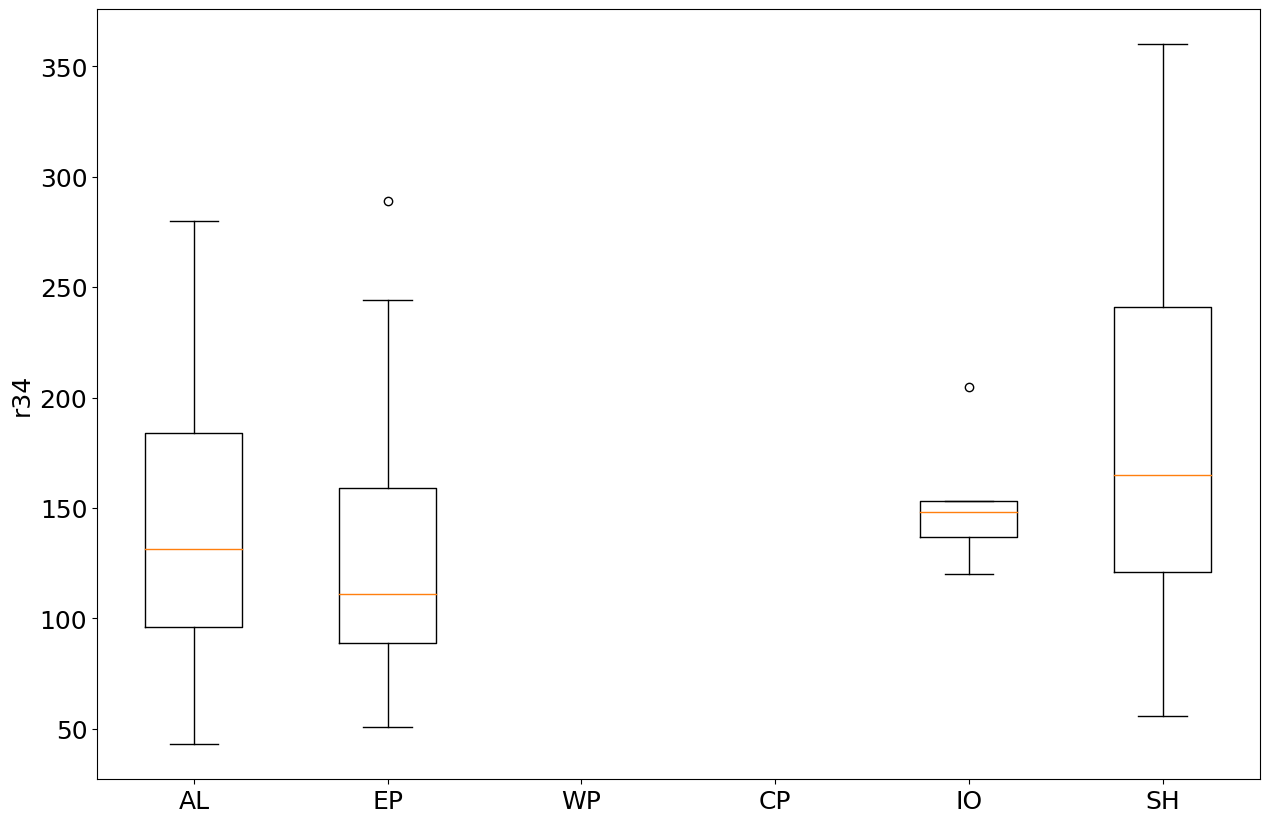

In [17]:
prm      = 'r34'
dict_prm = dict(zip(basin_names, [dbasin[prm] / 1000 for dbasin in list_of_dbasin]))

fig, ax  = plt.subplots()

ax.boxplot(dict_prm.values())
ax.set_xticklabels(dict_prm.keys())
ax.set_ylabel(prm)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f499a467f70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f499a474550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f499a467ca0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f499a474af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f499a474dc0>],
 'means': []}

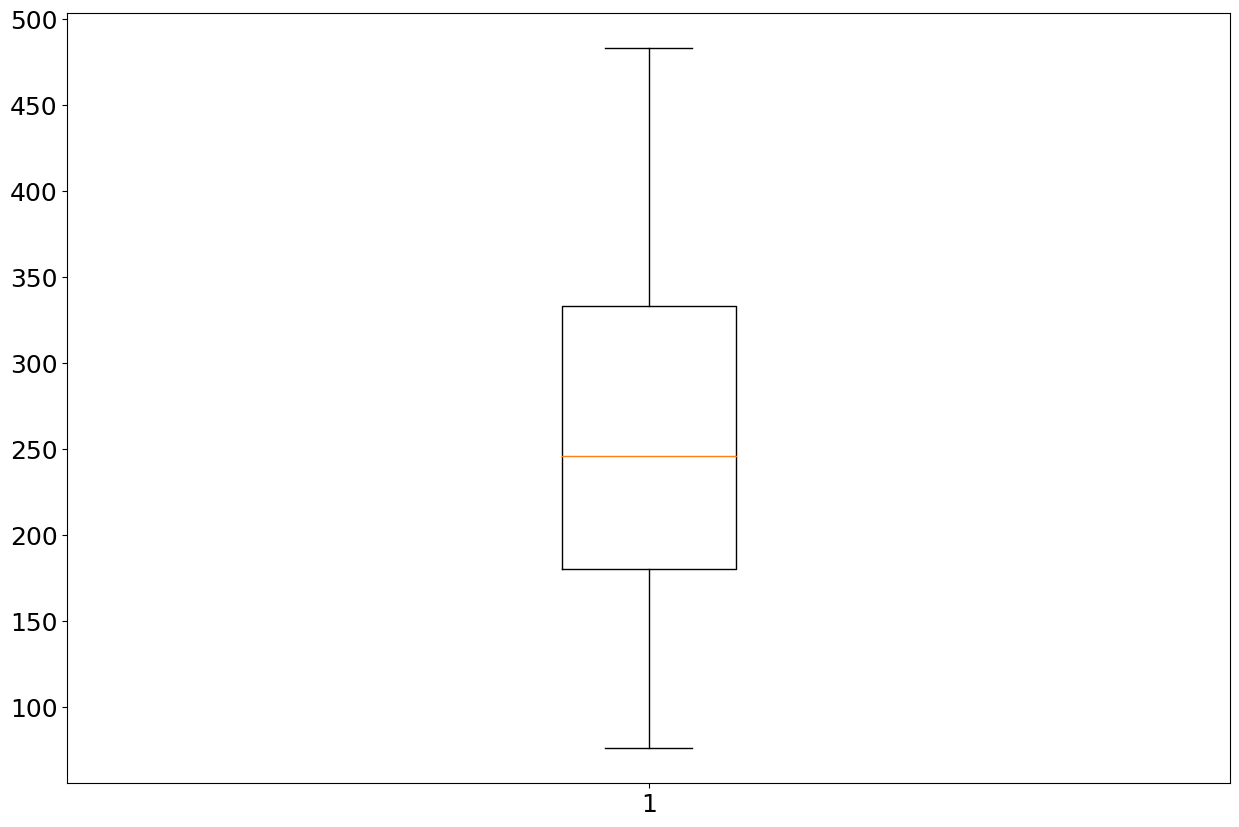

In [18]:
plt.boxplot(d.where(d.basin == 'wp', drop=True).dropna(dim='time').r34 / 1000)

(array([ 5.,  4.,  4., 13.,  7.,  7.,  3.,  3.,  1.,  4.]),
 array([-65.48555557, -49.86283334, -34.24011112, -18.6173889 ,
         -2.99466668,  12.62805554,  28.25077777,  43.87349999,
         59.49622221,  75.11894443,  90.74166666]),
 <BarContainer object of 10 artists>)

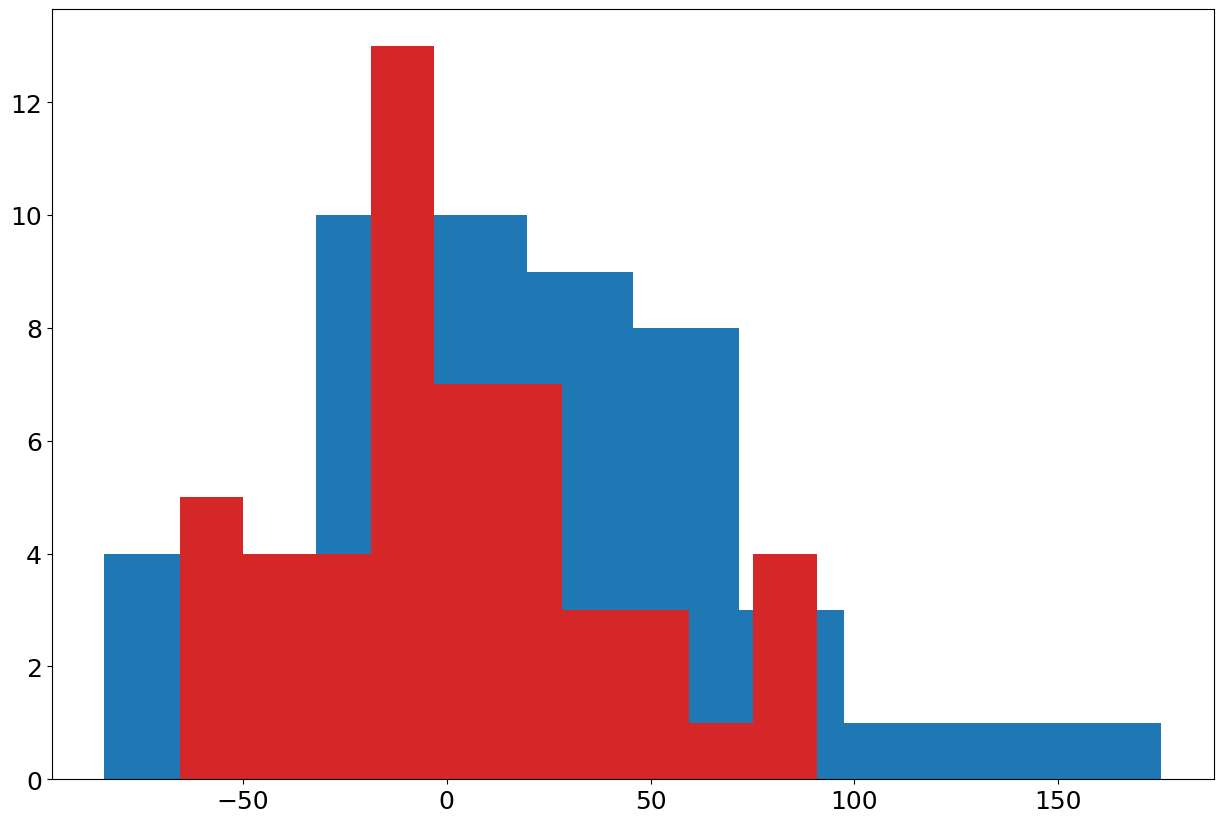

In [19]:
plt.hist(d.where(d.basin == 'ep', drop=True).t_since_lmi_ibt / 3600)
plt.hist(d.where(d.basin == 'wp', drop=True).t_since_lmi_ibt / 3600, color='tab:red')

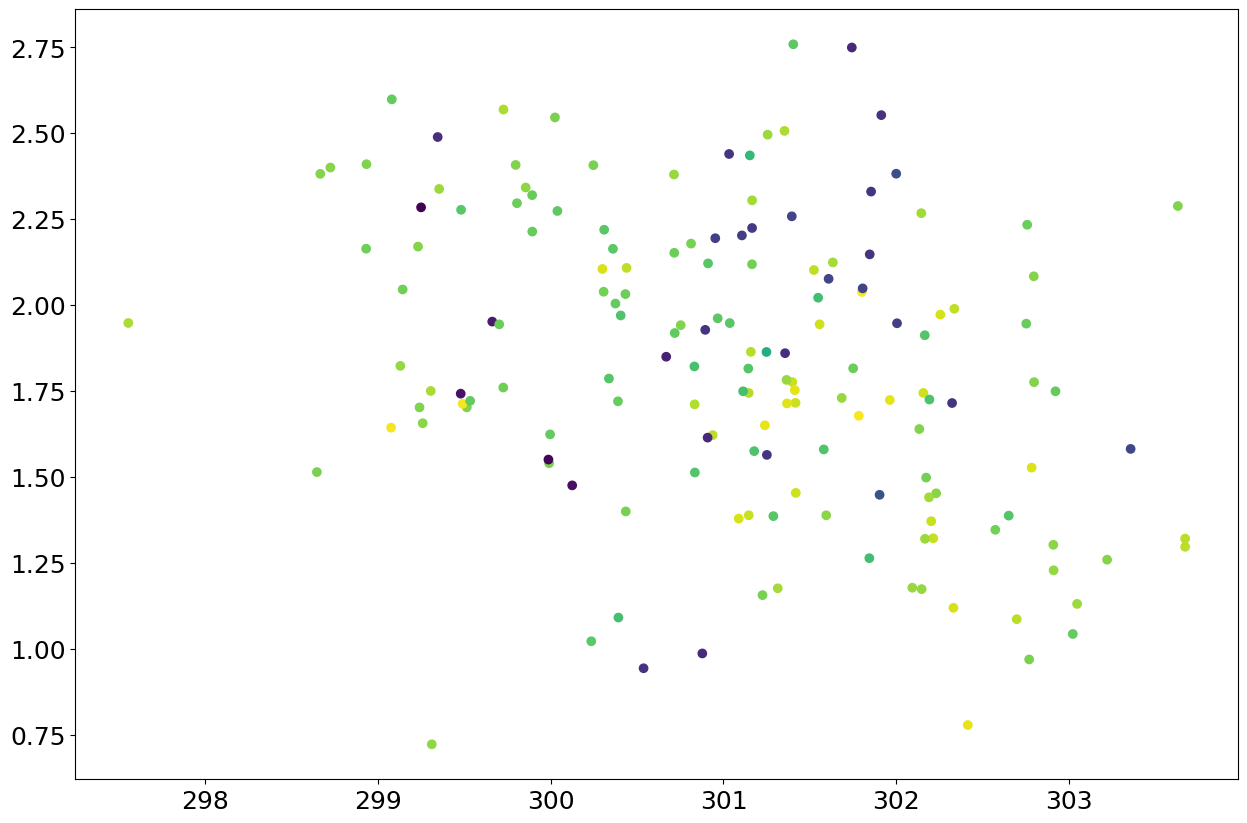

In [20]:
plt.scatter(d.sst_pmd, d.B_hol, c=d.fcor)
# plt.scatter(dw.sst_pmd, dw.B_hol, c='r')

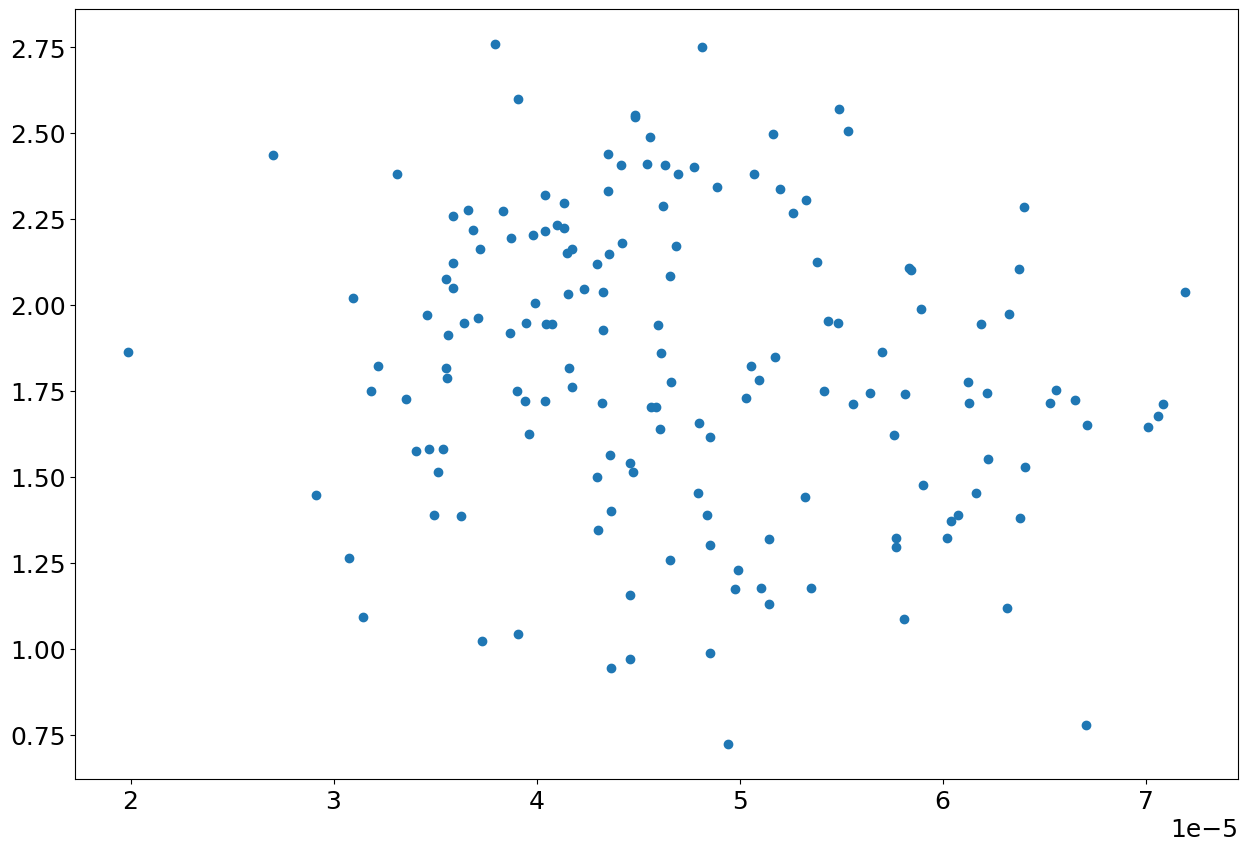

In [63]:
plt.scatter(abs(d.fcor), d.B_hol)
# plt.scatter(dw.sst_pmd, dw.B_hol, c='r')

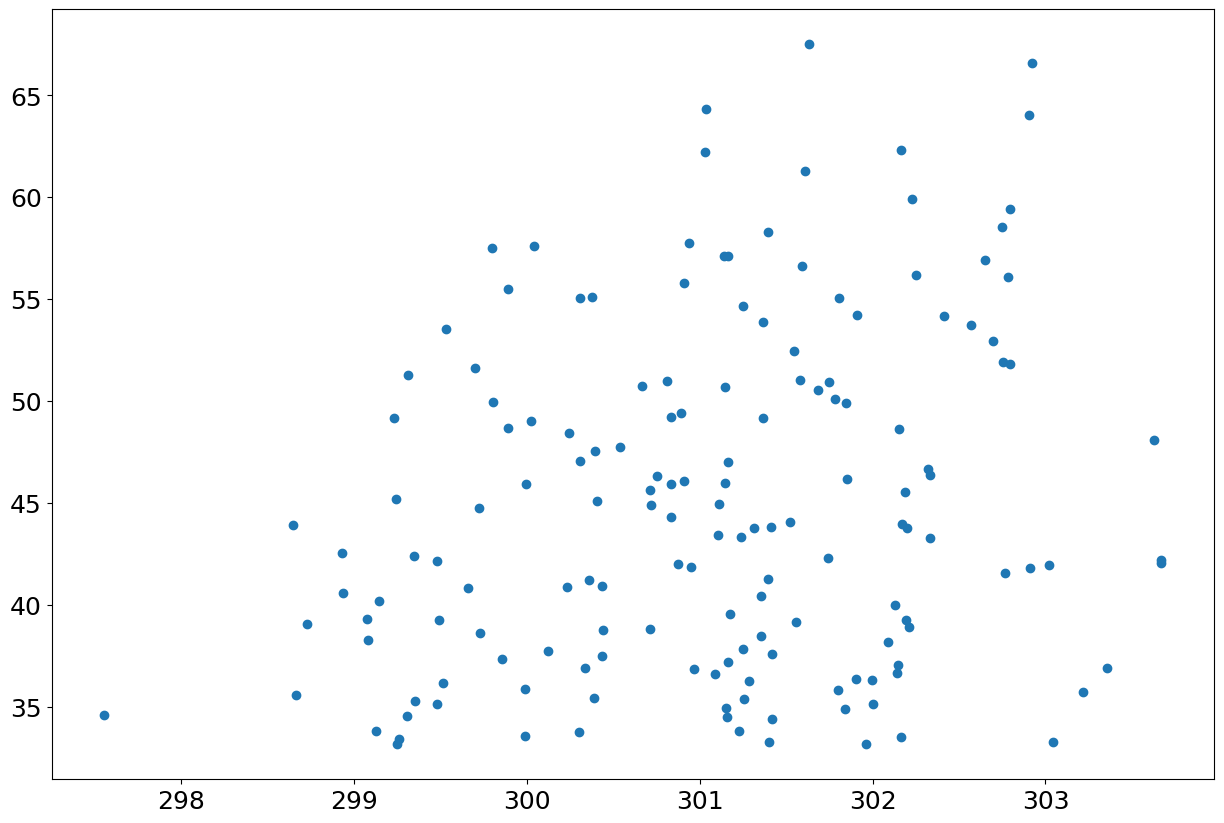

In [57]:
plt.scatter(d.sst_pmd, d.vmx)

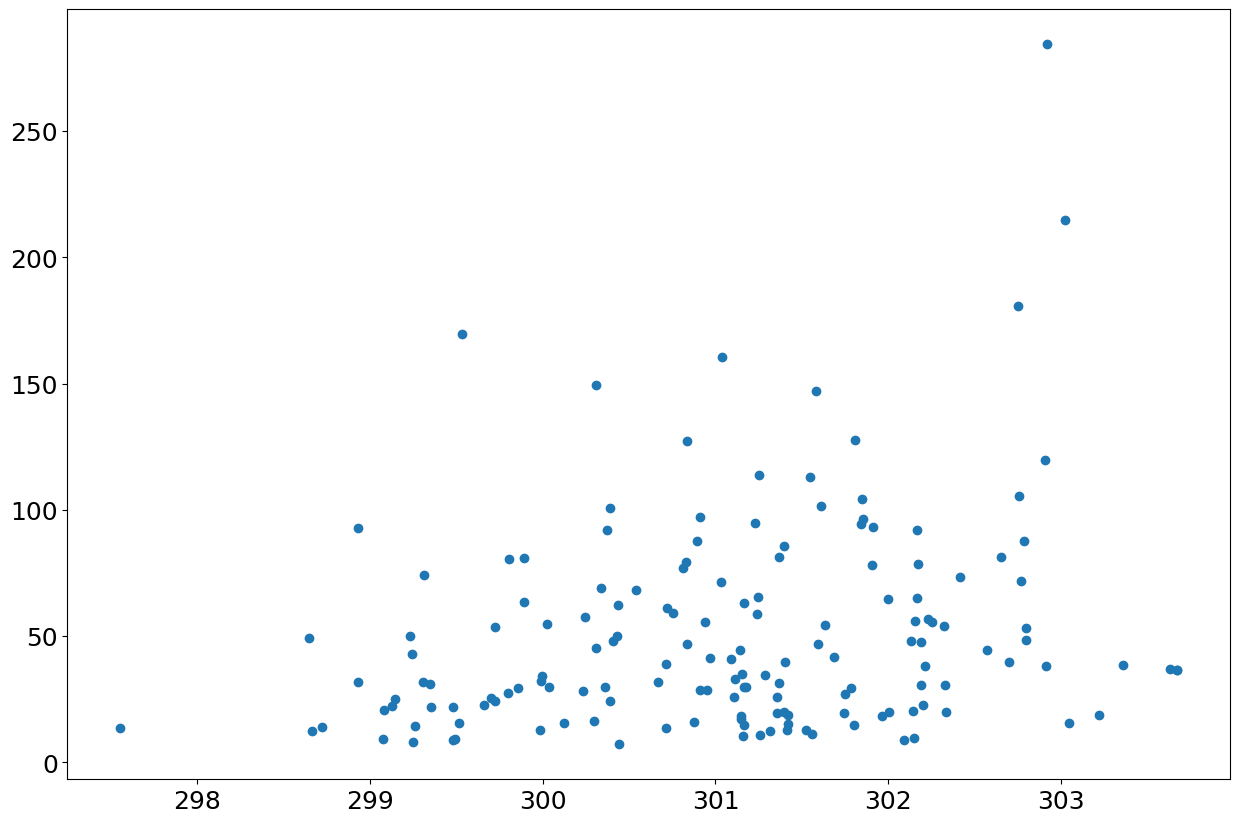

In [60]:
plt.scatter(d.sst_pmd, d.rsby)

(array([ 2.,  3.,  1.,  7.,  9., 10., 10.,  3.,  3.,  1.]),
 array([21.15908323, 22.68103529, 24.20298734, 25.7249394 , 27.24689145,
        28.76884351, 30.29079556, 31.81274762, 33.33469967, 34.85665173,
        36.37860378]),
 <BarContainer object of 10 artists>)

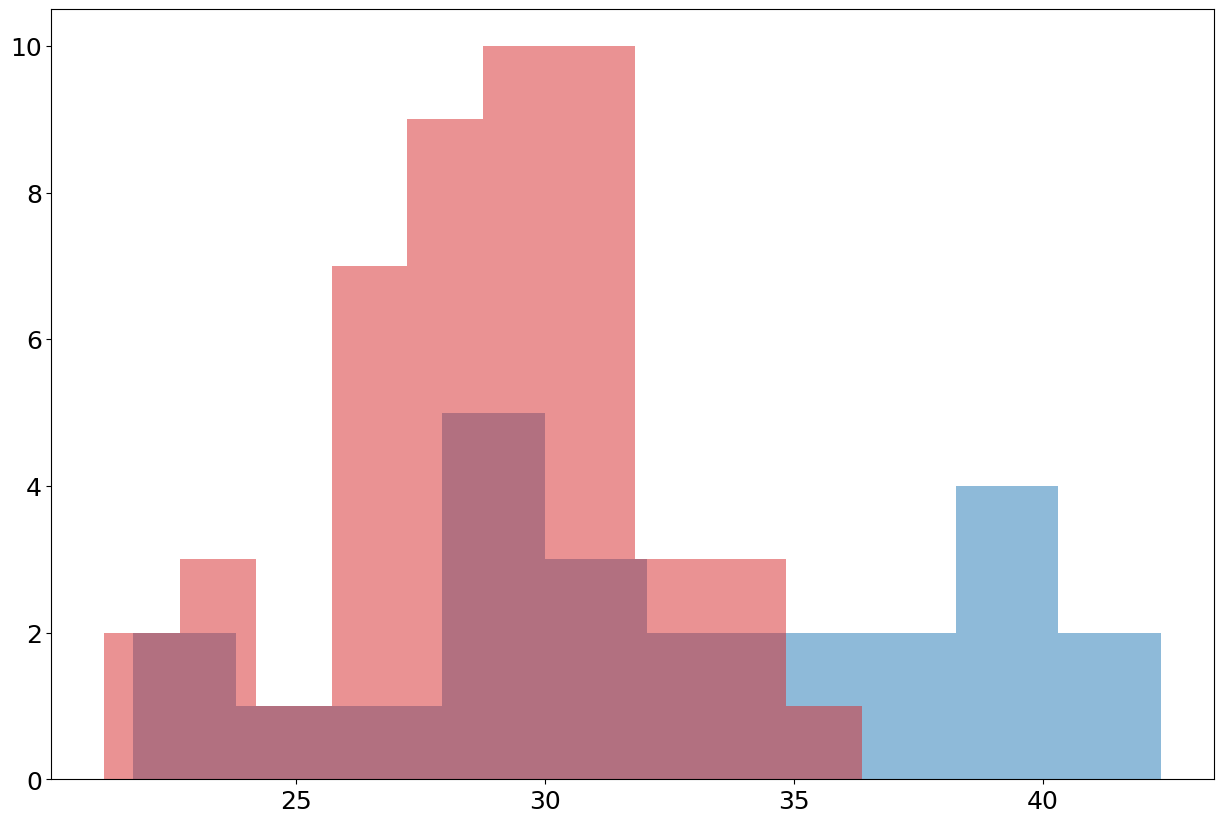

In [16]:
plt.hist(da.uc, alpha=0.5, color='tab:blue')
plt.hist(de.uc, alpha=0.5, color='tab:red')

(array([ 3.,  2.,  5., 11., 10.,  7.,  5.,  4.,  1.,  1.]),
 array([134940.45838545, 161179.65883541, 187418.85928537, 213658.05973533,
        239897.2601853 , 266136.46063526, 292375.66108522, 318614.86153518,
        344854.06198514, 371093.2624351 , 397332.46288506]),
 <BarContainer object of 10 artists>)

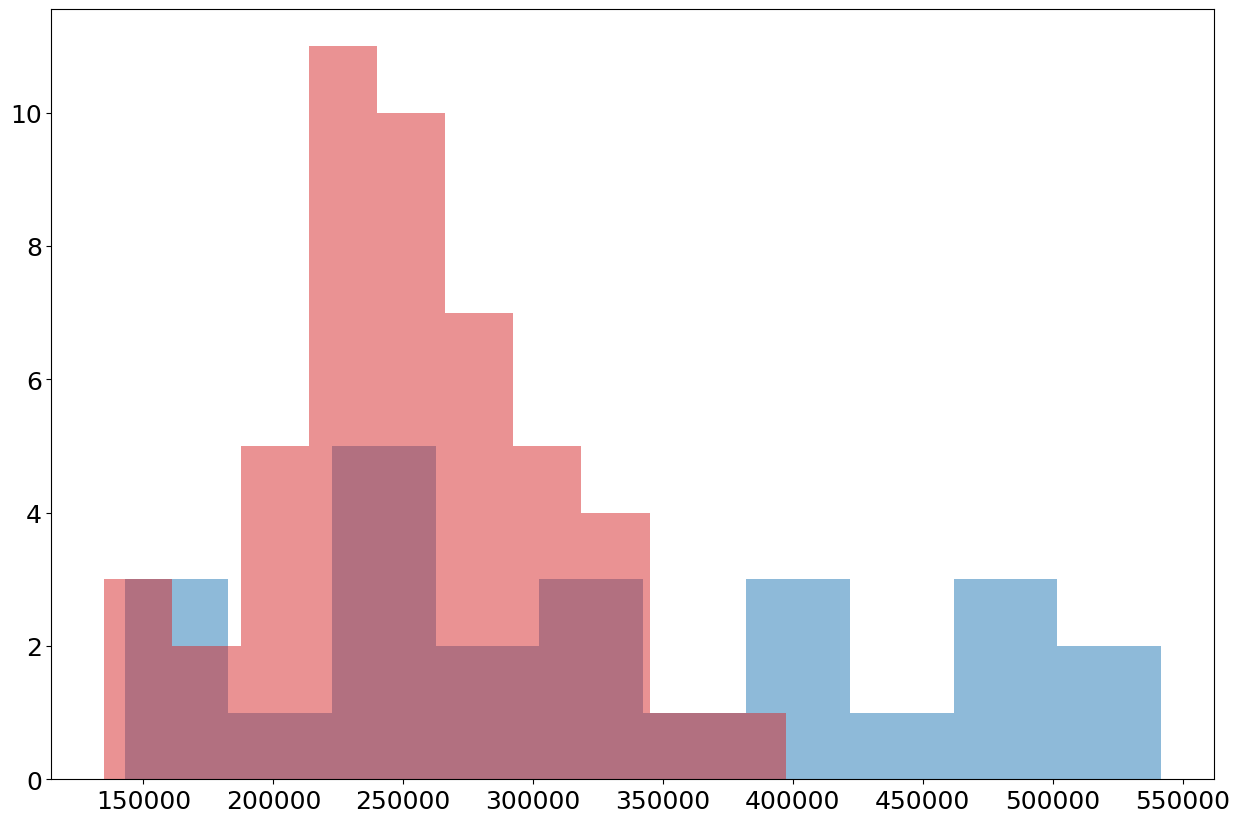

In [17]:
plt.hist(da.sst_pmd * da.uc ** 2, alpha=0.5, color='tab:blue')
plt.hist(de.sst_pmd * de.uc ** 2, alpha=0.5, color='tab:red')

(array([ 2.,  0.,  4.,  4.,  7., 10.,  8.,  9.,  3.,  2.]),
 array([1.02202243, 1.19570705, 1.36939166, 1.54307628, 1.71676089,
        1.89044551, 2.06413013, 2.23781474, 2.41149936, 2.58518397,
        2.75886859]),
 <BarContainer object of 10 artists>)

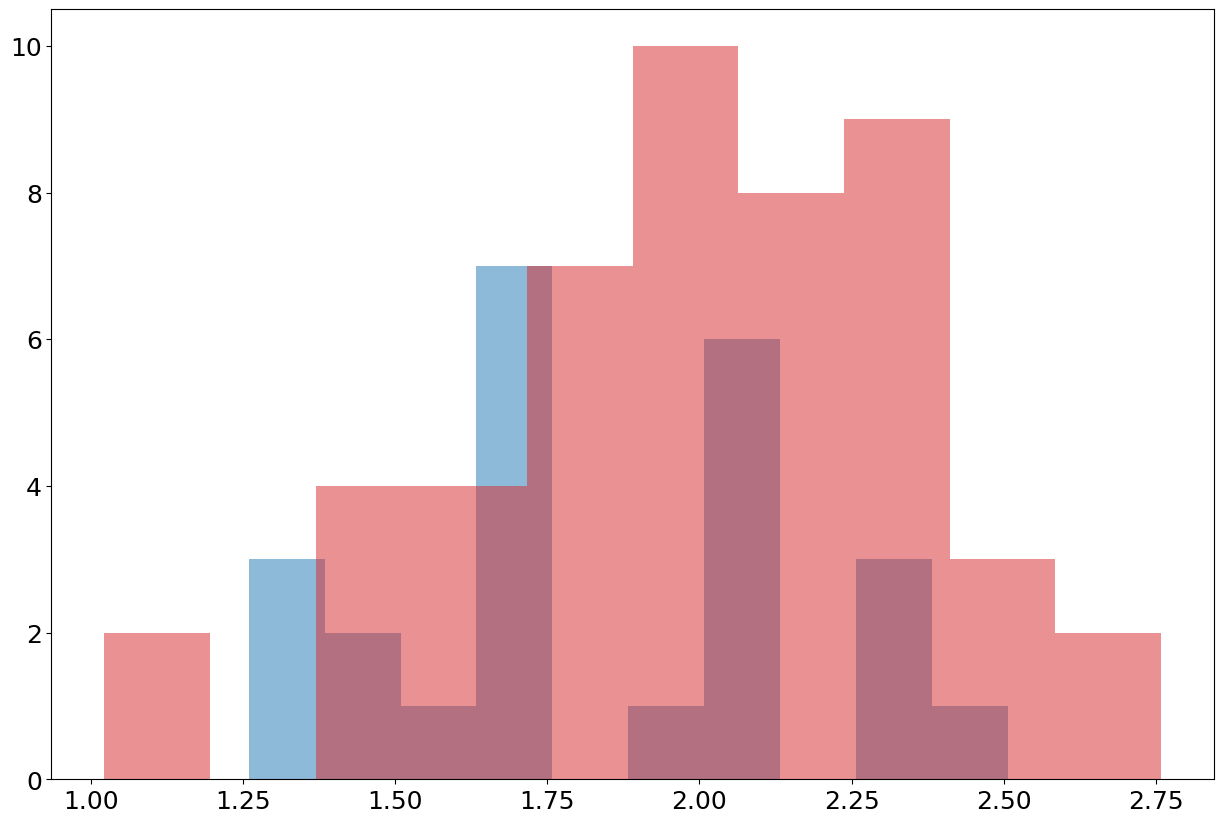

In [18]:
plt.hist(da.B_hol, alpha=0.5, color='tab:blue')
plt.hist(de.B_hol, alpha=0.5, color='tab:red')

(array([ 6., 11., 13.,  4.,  5.,  4.,  3.,  1.,  1.,  1.]),
 array([ 51000.,  74800.,  98600., 122400., 146200., 170000., 193800.,
        217600., 241400., 265200., 289000.]),
 <BarContainer object of 10 artists>)

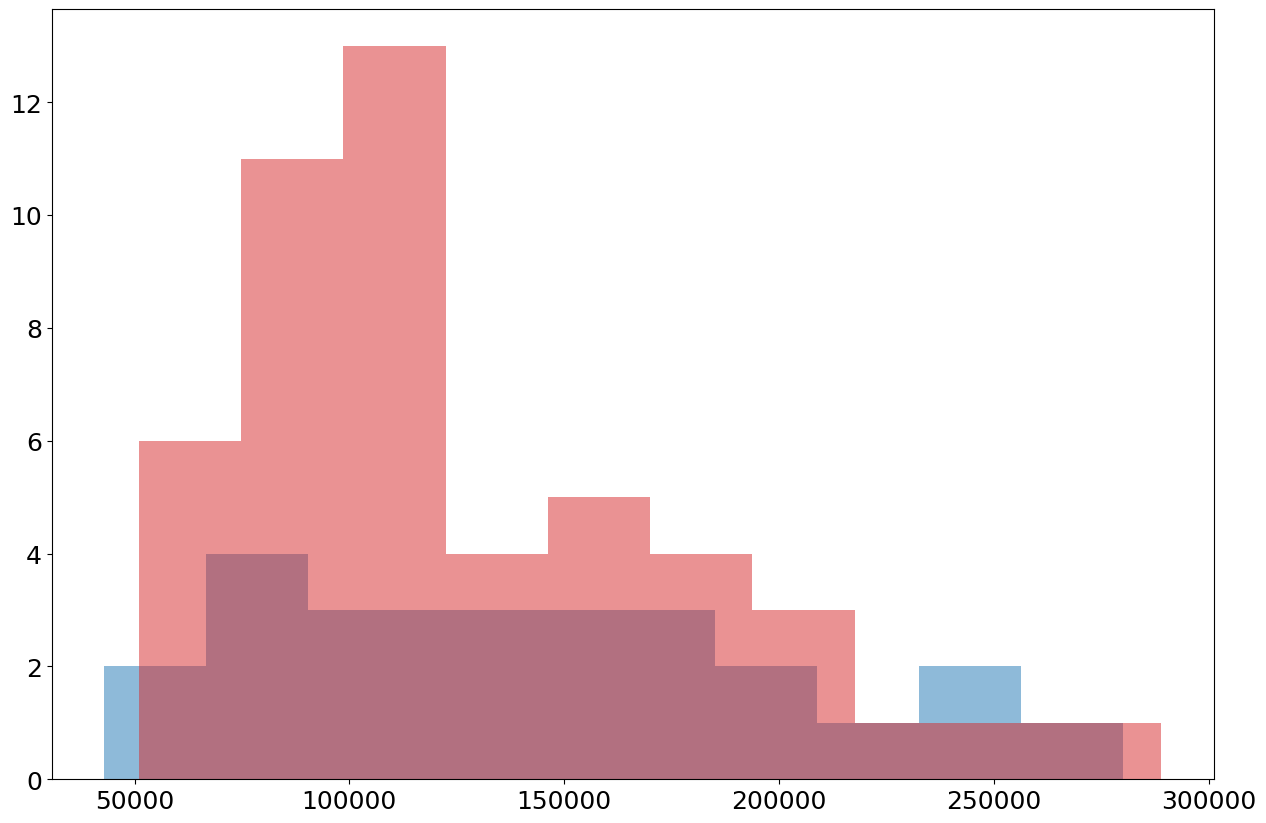

In [19]:
plt.hist(da.r34, alpha=0.5, color='tab:blue')
plt.hist(de.r34, alpha=0.5, color='tab:red')

(array([1., 0., 3., 9., 6., 9., 9., 9., 2., 1.]),
 array([297.5580458 , 298.01663158, 298.47521737, 298.93380315,
        299.39238893, 299.85097471, 300.3095605 , 300.76814628,
        301.22673206, 301.68531784, 302.14390363]),
 <BarContainer object of 10 artists>)

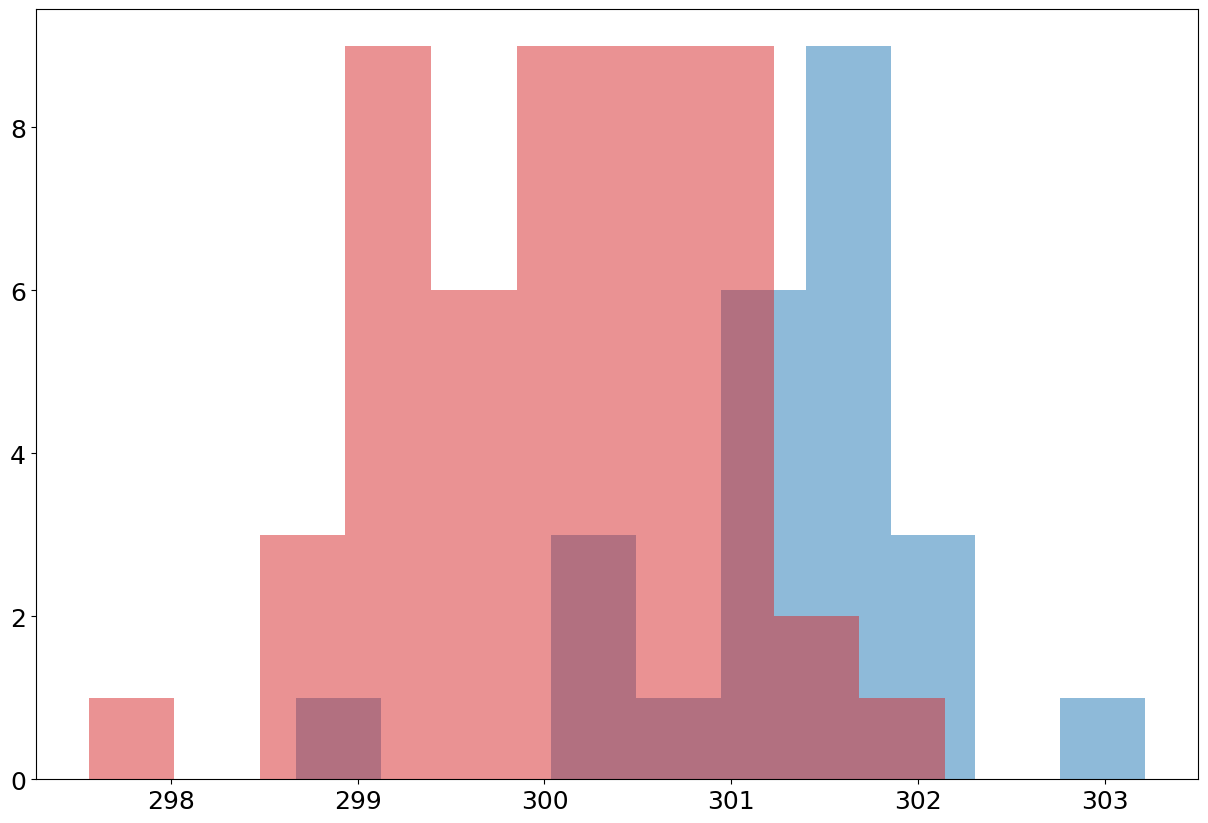

In [20]:
plt.hist(da.sst_pmd, alpha=0.5, color='tab:blue')
plt.hist(de.sst_pmd, alpha=0.5, color='tab:red')

(array([ 1.,  2.,  5., 13., 15.,  1.,  3.,  4.,  3.,  2.]),
 array([110173.95304157, 134094.16319706, 158014.37335256, 181934.58350805,
        205854.79366355, 229775.00381904, 253695.21397454, 277615.42413003,
        301535.63428553, 325455.84444102, 349376.05459652]),
 <BarContainer object of 10 artists>)

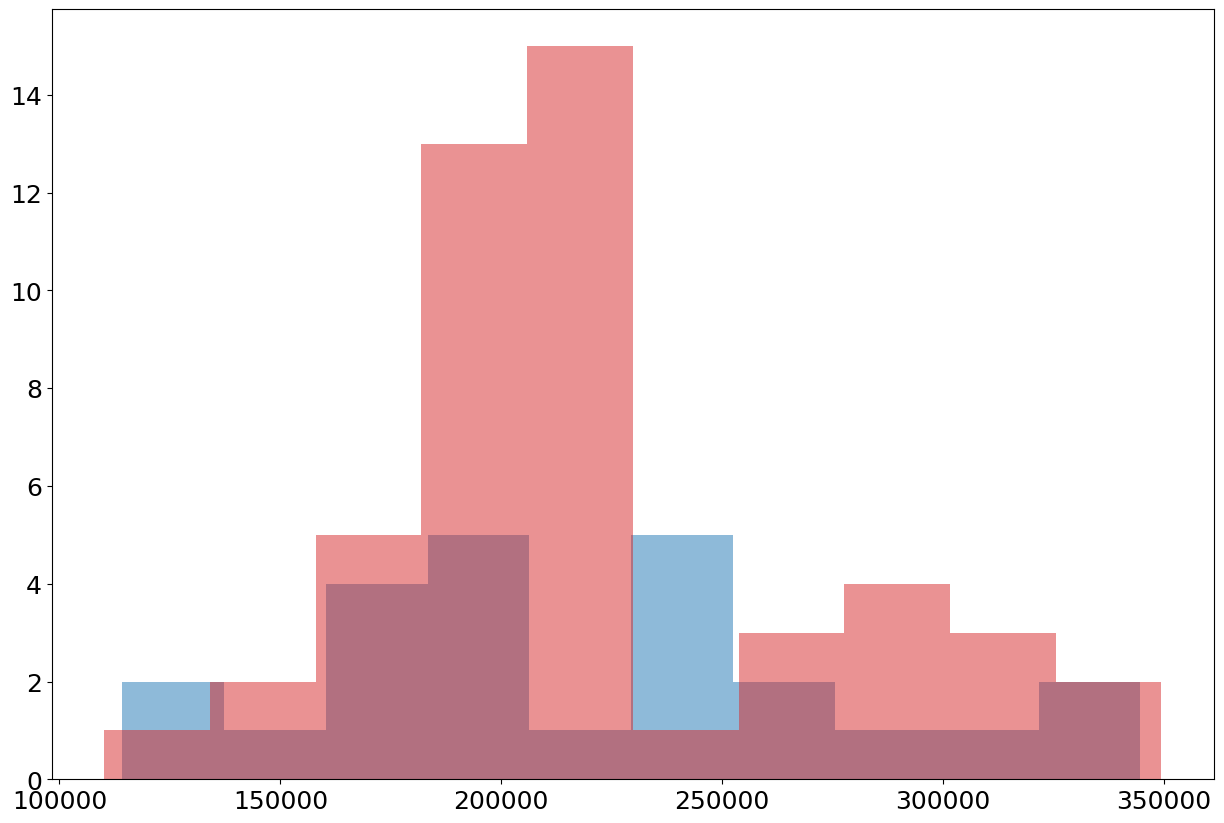

In [21]:
plt.hist(da.r0, alpha=0.5, color='tab:blue')
plt.hist(de.r0, alpha=0.5, color='tab:red')

In [22]:
amsr = xr.open_dataset('/home/arthur/Téléchargements/20210820185438_2021225N15313_AMSR2-REMSS-L2P-v8.2.nc')

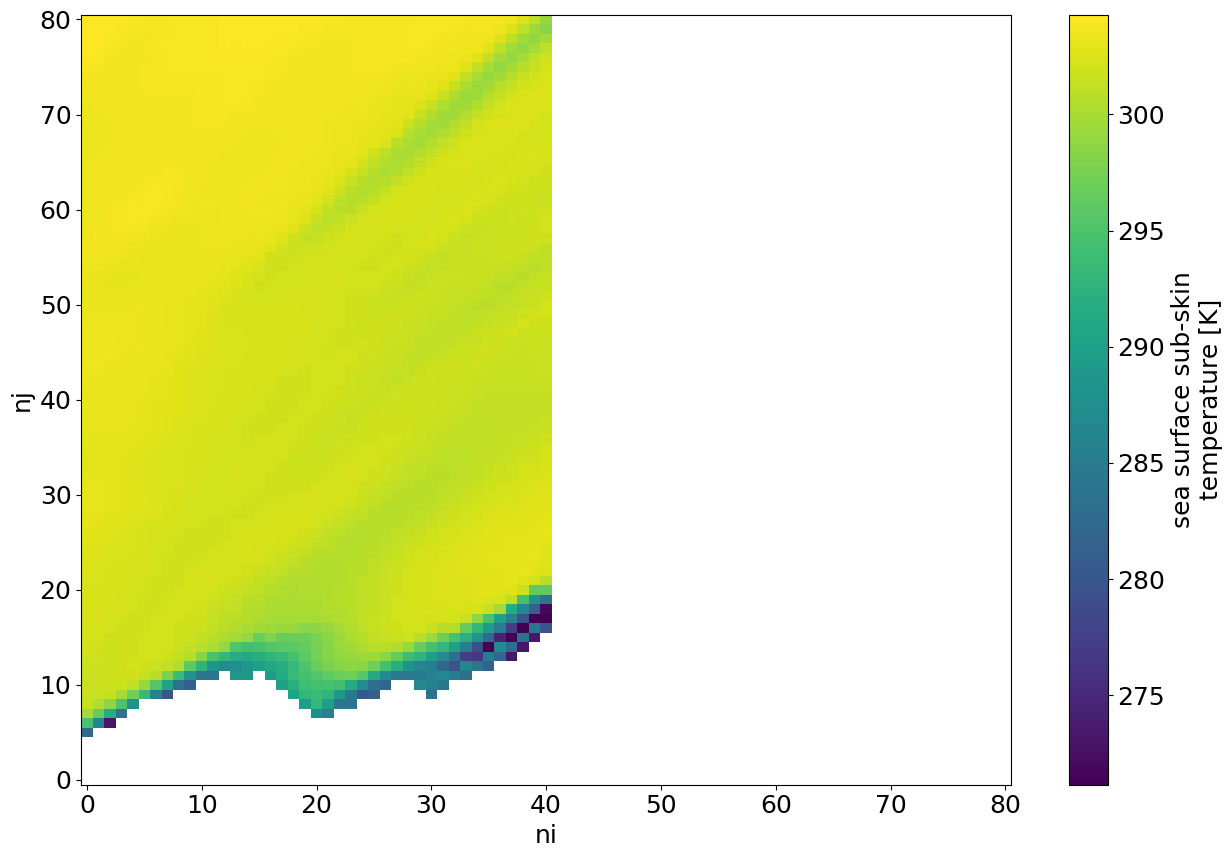

In [23]:
amsr.sea_surface_temperature.plot()

Text(0, 0.5, 'Holland B parameter')

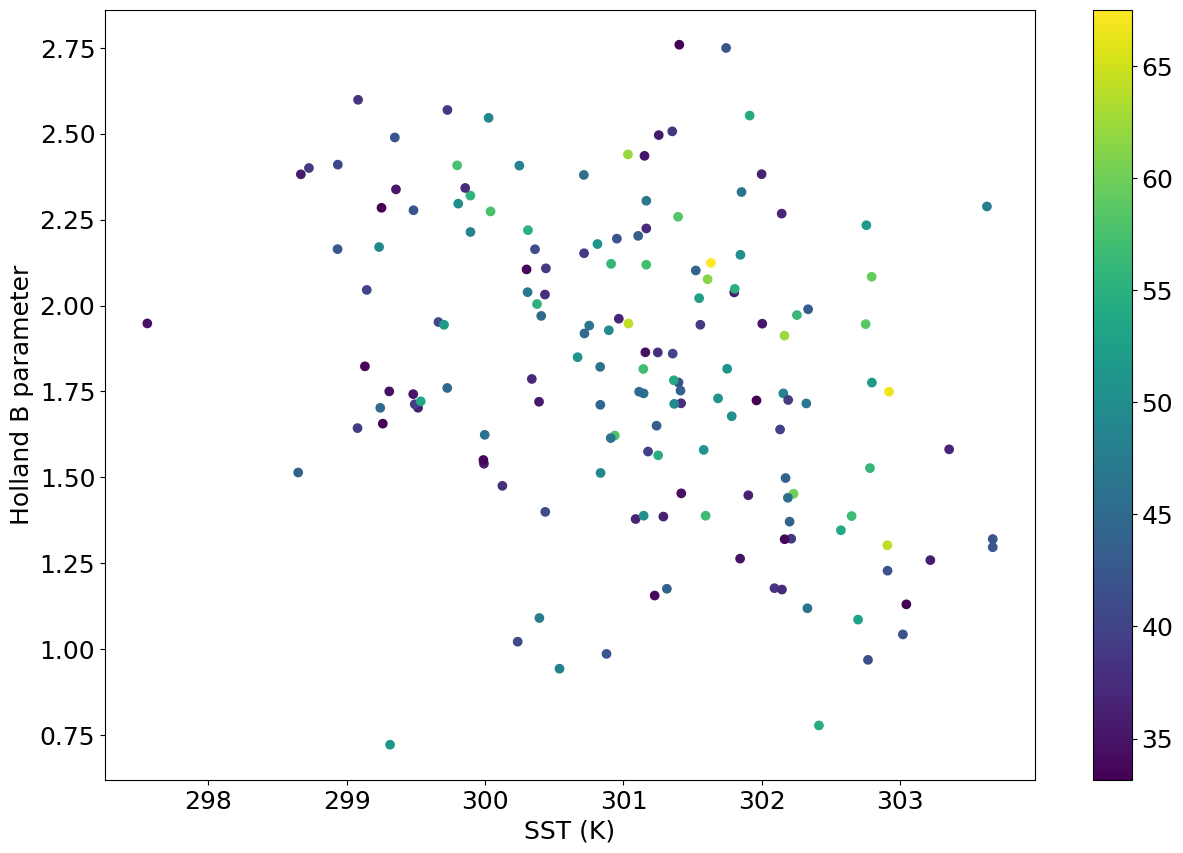

In [24]:
plt.scatter(d.sst_pmd, d.B_hol, c=d.vmx)
plt.colorbar()
plt.xlabel('SST (K)')
plt.ylabel('Holland B parameter')

Text(0, 0.5, 'Vmax (m/s)')

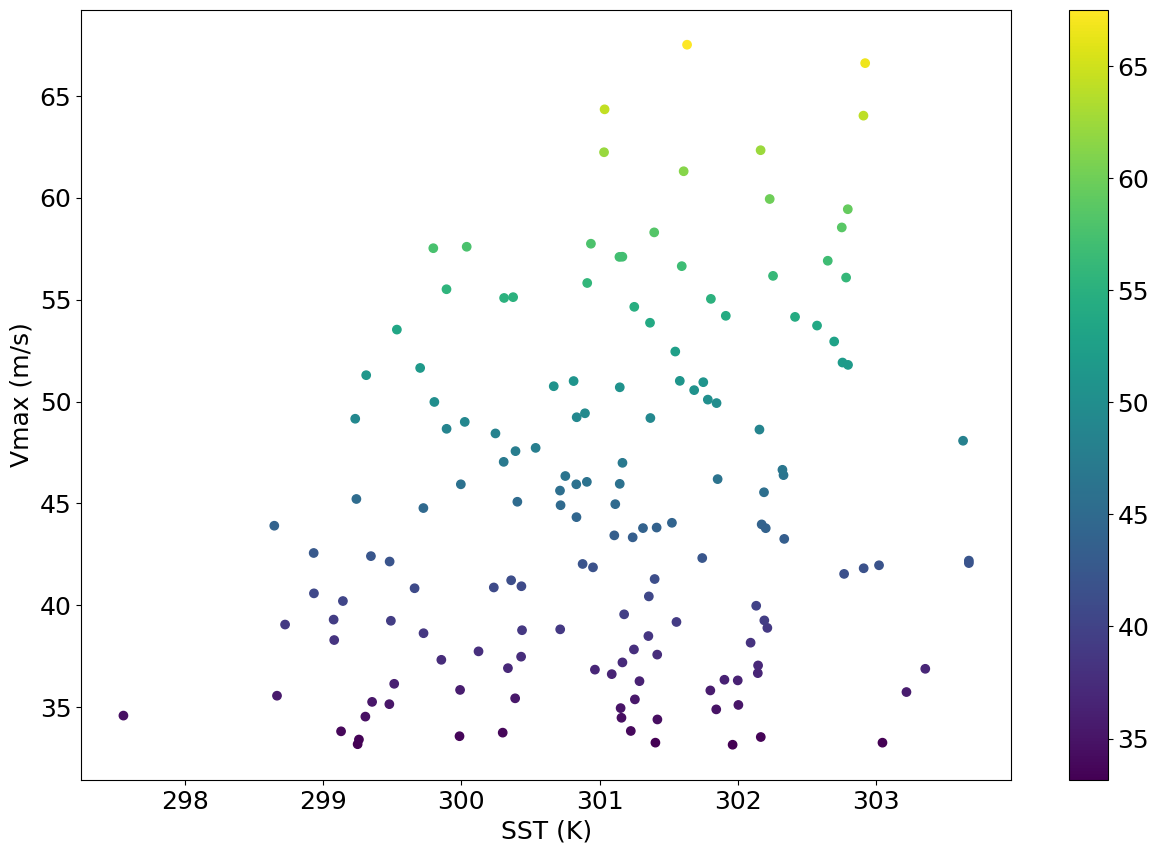

In [25]:
plt.scatter(d.sst_pmd, d.vmx, c=d.vmx)
plt.colorbar()
plt.xlabel('SST (K)')
plt.ylabel('Vmax (m/s)')

Text(0, 0.5, 'Rmax (km)')

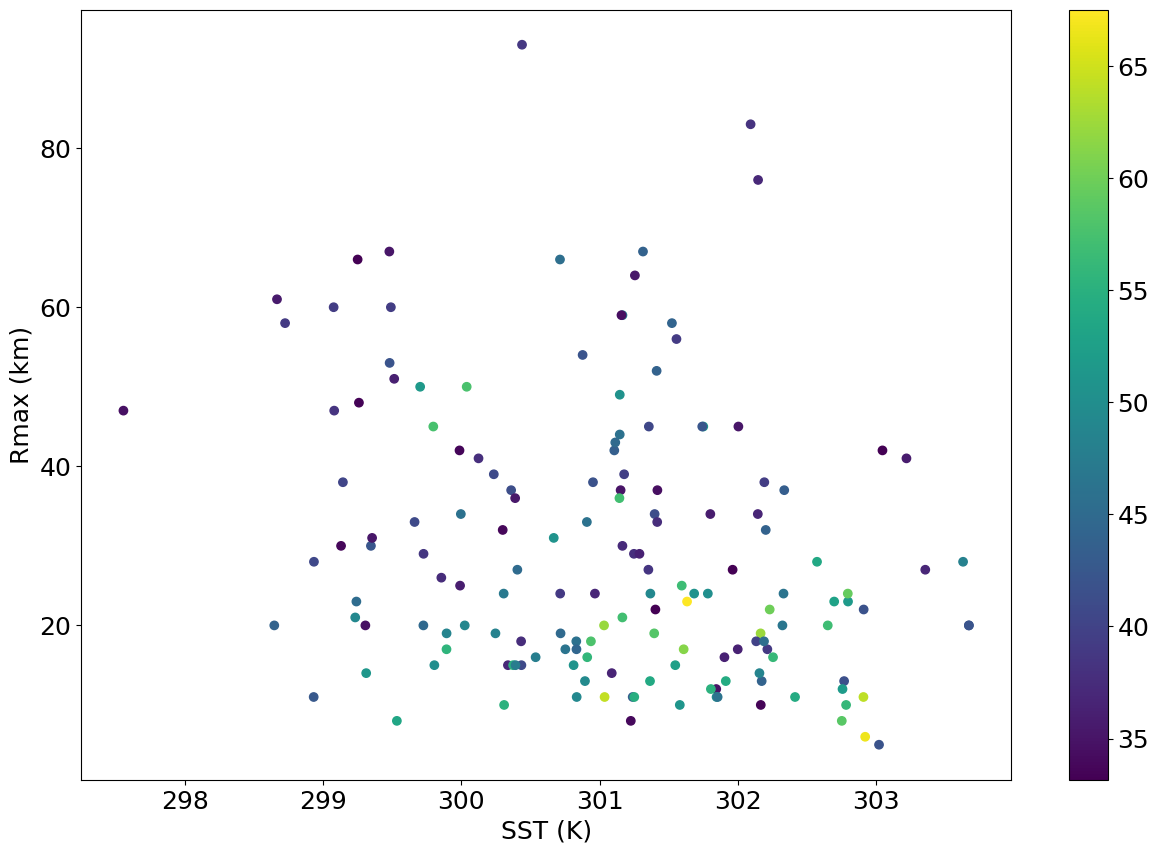

In [26]:
plt.scatter(d.sst_pmd, d.rmx / 1000, c=d.vmx)
plt.colorbar()
plt.xlabel('SST (K)')
plt.ylabel('Rmax (km)')

Text(0, 0.5, 'Rossby number')

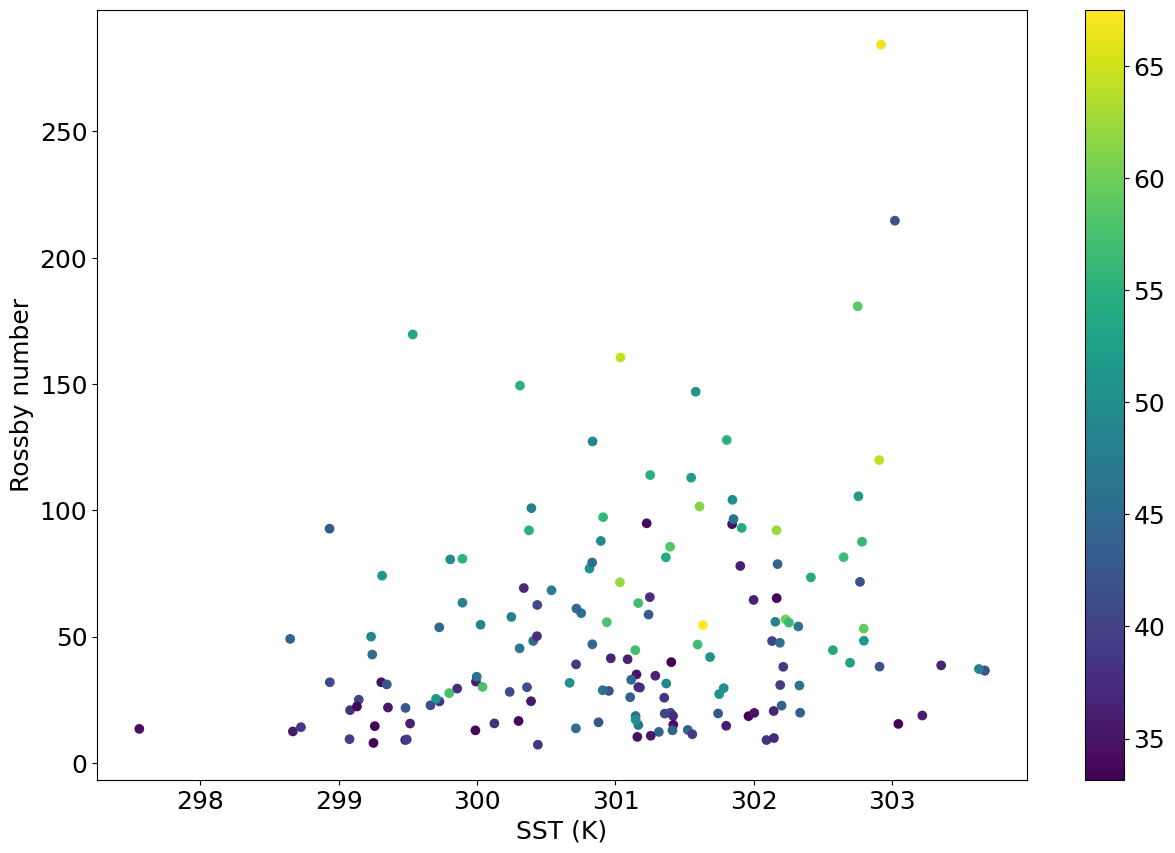

In [27]:
plt.scatter(d.sst_pmd, d.rsby, c=d.vmx)
plt.colorbar()
plt.xlabel('SST (K)')
plt.ylabel('Rossby number')

Text(0, 0.5, 'R0 (km)')

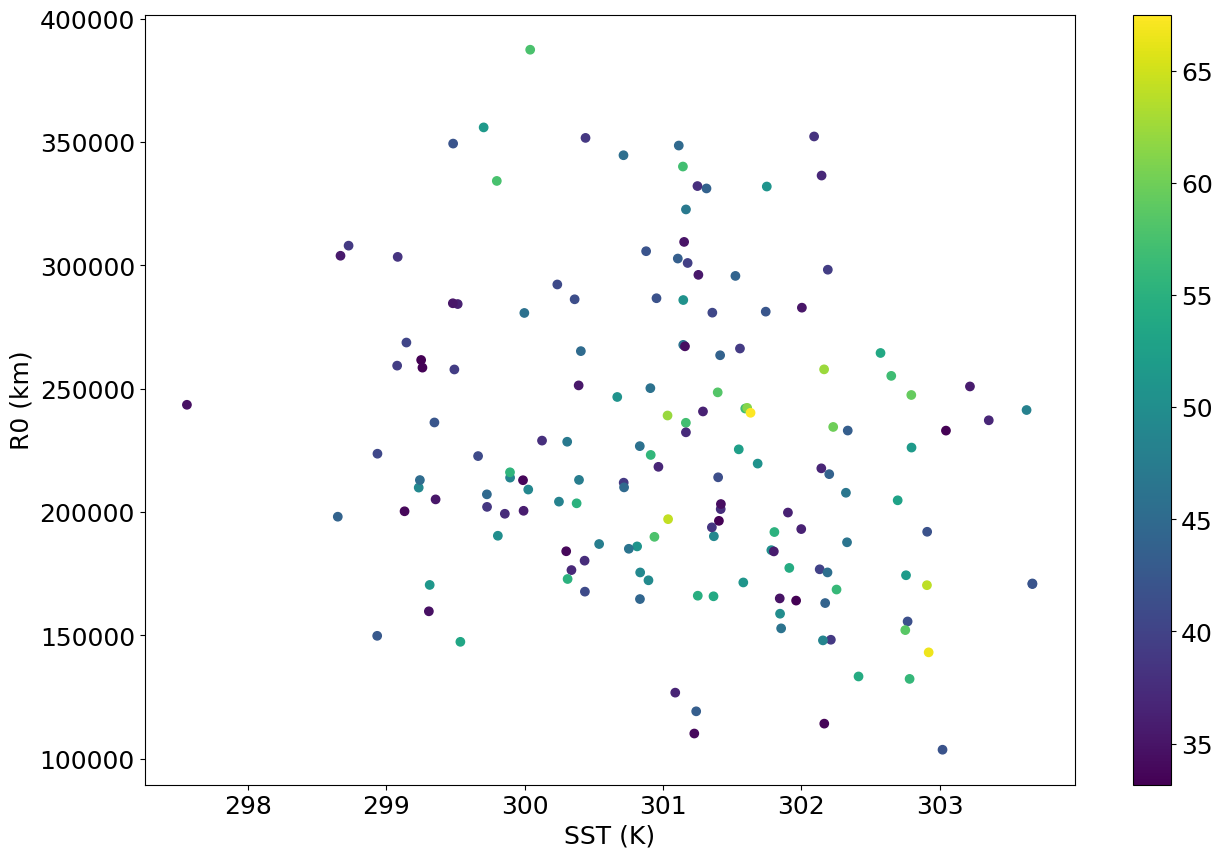

In [28]:
plt.scatter(d.sst_pmd, d.r0, c=d.vmx)
plt.colorbar()
plt.xlabel('SST (K)')
plt.ylabel('R0 (km)')

Text(0, 0.5, 'R+ (km)')

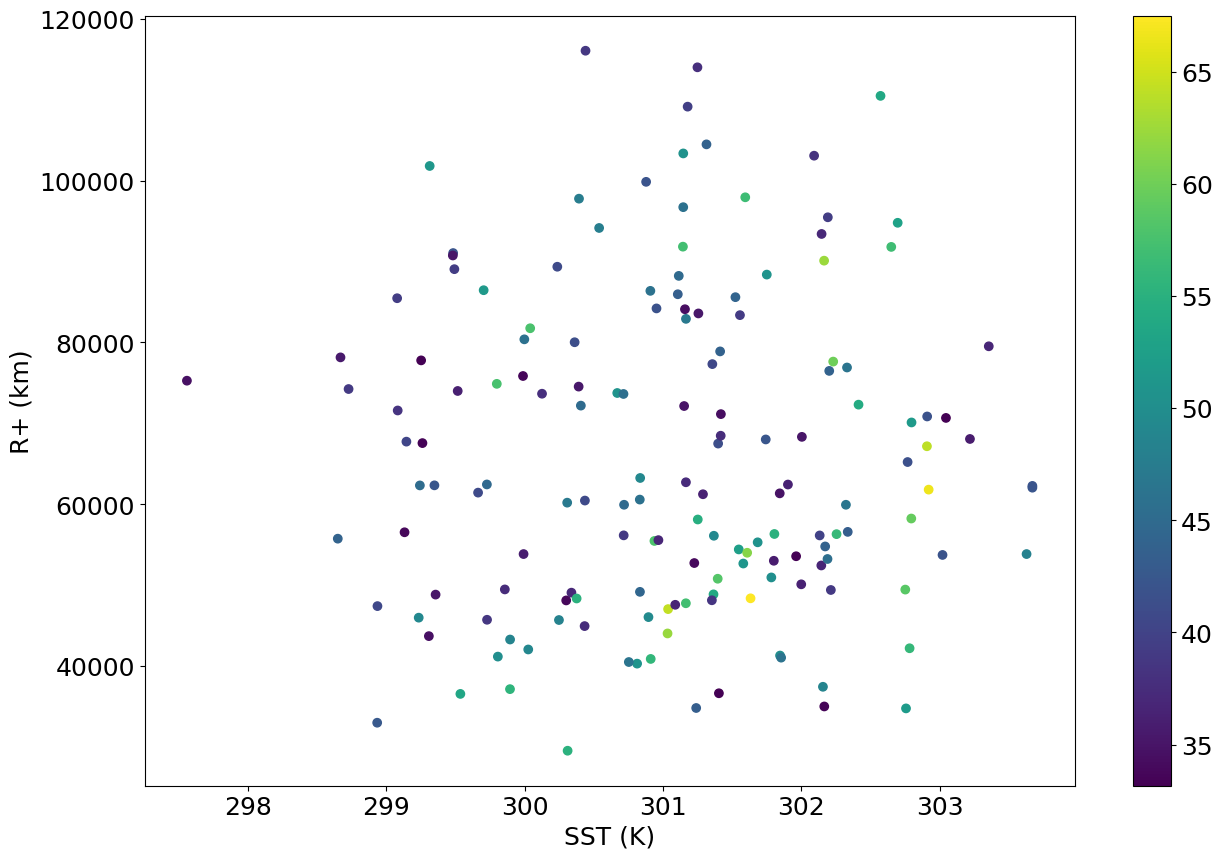

In [29]:
plt.scatter(d.sst_pmd, d.rps, c=d.vmx)
plt.colorbar()
plt.xlabel('SST (K)')
plt.ylabel('R+ (km)')